In [5]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from coco_dataset import *
from utils import *

In [6]:
path2data = "./data/train2017"
path2json = "./data/annotations/instances_train2017.json"

# Model parameters
n_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Learning parameters
checkpoint = None
#checkpoint = './Checkpoint_temp/checkpoint_epoch_27_ssd300.pth.tar' # path to model checkpoint
#checkpoint = './checkpoint_epoch_44_ssd300.pth.tar'
#checkpoint = './Trained_models/checkpoint_epoch_66_ssd300.pth.tar'
batch_size = 32
iterations = 400000
workers = 4
print_freq = 200
lr = 1e-3
lr_decay_point = [80000, 160000, 240000, 340000]
lr_decay_ratio = 0.1
momentum = 0.9
weight_decay = 5e-4
grad_clip = True
clip = 5.0
cudnn.benchmark = True

cuda


In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train() # training mode enables dropout
    
    batch_time = AverageMeter() # foward prop + backward prop time
    data_time = AverageMeter() # data loading time
    losses = AverageMeter()
    losses_c = AverageMeter()
    losses_l = AverageMeter()
    start = time.time()
    
    old_state_dict = {}
    for key in model.state_dict():
        old_state_dict[key] = model.state_dict()[key].clone()
        
    for i, data in enumerate(train_loader):
        data_time.update(time.time() - start)
        
        images, boxes, labels = data
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        optimizer.zero_grad()
        # Forward prop
        predicted_locs, predicted_scores = model(images)
        # Loss
        loss_c, loss_l = criterion(predicted_locs, predicted_scores, boxes, labels) # scalar
        loss = loss_c + loss_l
        # Backward prop
        
        loss.backward()
        
        # Clip gradients, if necessary
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            #clip_gradient(optimizer, grad_clip)
            
        # Update model
        optimizer.step()
        
        losses.update(loss.item(), images.size(0))
        losses_c.update(loss_c.item(), images.size(0))
        losses_l.update(loss_l.item(), images.size(0))
        batch_time.update(time.time() - start)
        
        start = time.time()
        
        #if model.pred_convs.loc_conv11_2.weight.grad.sum() != 0:
            #print("pred_conv11_2 has grad != 0.")
            #print(model.pred_convs.loc_conv11_2.weight.grad[model.pred_convs.loc_conv11_2.weight.grad.nonzero(as_tuple=True)])

        
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Loss_c {loss_c.val:.4f} ({loss_c.avg:.4f})\t'
                  'Loss_l {loss_l.val:.4f} ({loss_l.avg:.4f})\t'.format(epoch, i, len(train_loader), batch_time = batch_time, data_time = data_time, loss = losses, loss_c = losses_c, loss_l = losses_l))
            
        if i % (5 * print_freq) == 0:
            # Save new params
            new_state_dict = {}
            for key in model.state_dict():
                new_state_dict[key] = model.state_dict()[key].clone()
            # Compare params
            for key in old_state_dict:
                if (old_state_dict[key] == new_state_dict[key]).all():
                    print('Same in {}'.format(key))
            old_state_dict = new_state_dict
            plot_grad_flow(model.named_parameters())
    del predicted_locs, predicted_scores, images, boxes, labels
        


Loaded checkpoing from epoch 67.

DECAYING learning rate.
 The new LR is 0.000020

loading annotations into memory...
Done (t=8.16s)
creating index...
index created!
Epoch: [67][0/3697]	Batch Time 4.646 (4.646)	Data Time 1.425 (1.425)	Loss 3.2216 (3.2216)	Loss_c 2.8344 (2.8344)	Loss_l 0.3872 (0.3872)	


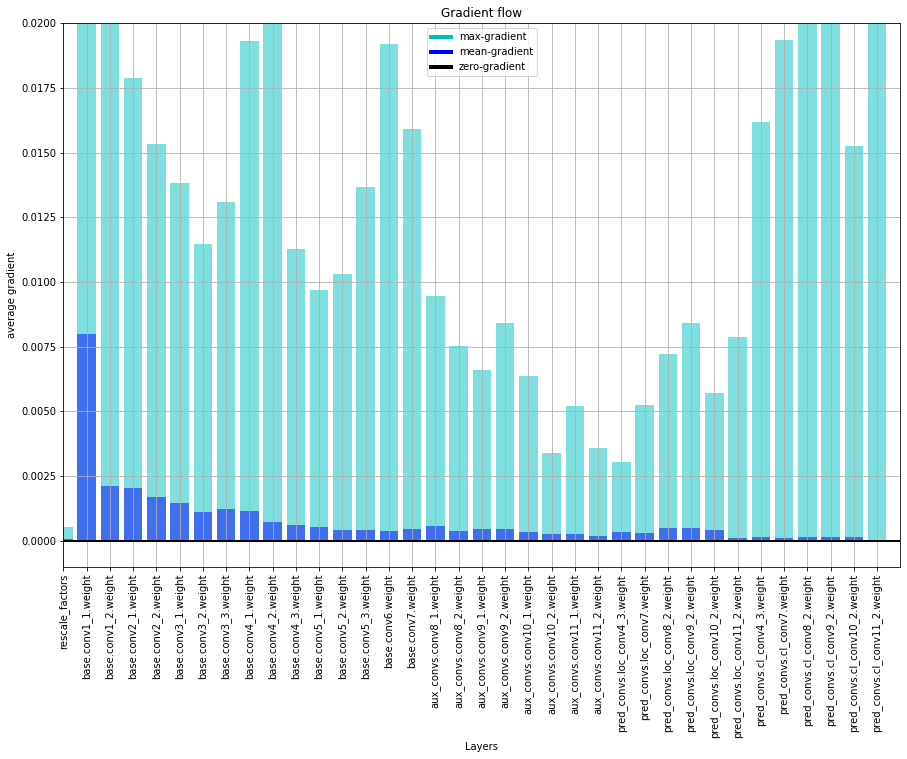

Epoch: [67][200/3697]	Batch Time 0.422 (0.444)	Data Time 0.000 (0.009)	Loss 3.3089 (3.1342)	Loss_c 2.8707 (2.7428)	Loss_l 0.4382 (0.3914)	
Epoch: [67][400/3697]	Batch Time 0.422 (0.434)	Data Time 0.000 (0.005)	Loss 2.7944 (3.1367)	Loss_c 2.4358 (2.7454)	Loss_l 0.3587 (0.3913)	
Epoch: [67][600/3697]	Batch Time 0.423 (0.431)	Data Time 0.000 (0.003)	Loss 3.5882 (3.1315)	Loss_c 3.1544 (2.7404)	Loss_l 0.4337 (0.3910)	
Epoch: [67][800/3697]	Batch Time 0.424 (0.429)	Data Time 0.000 (0.002)	Loss 3.3679 (3.1322)	Loss_c 2.9848 (2.7426)	Loss_l 0.3831 (0.3896)	
Epoch: [67][1000/3697]	Batch Time 0.423 (0.428)	Data Time 0.000 (0.002)	Loss 3.2118 (3.1355)	Loss_c 2.7945 (2.7452)	Loss_l 0.4173 (0.3903)	


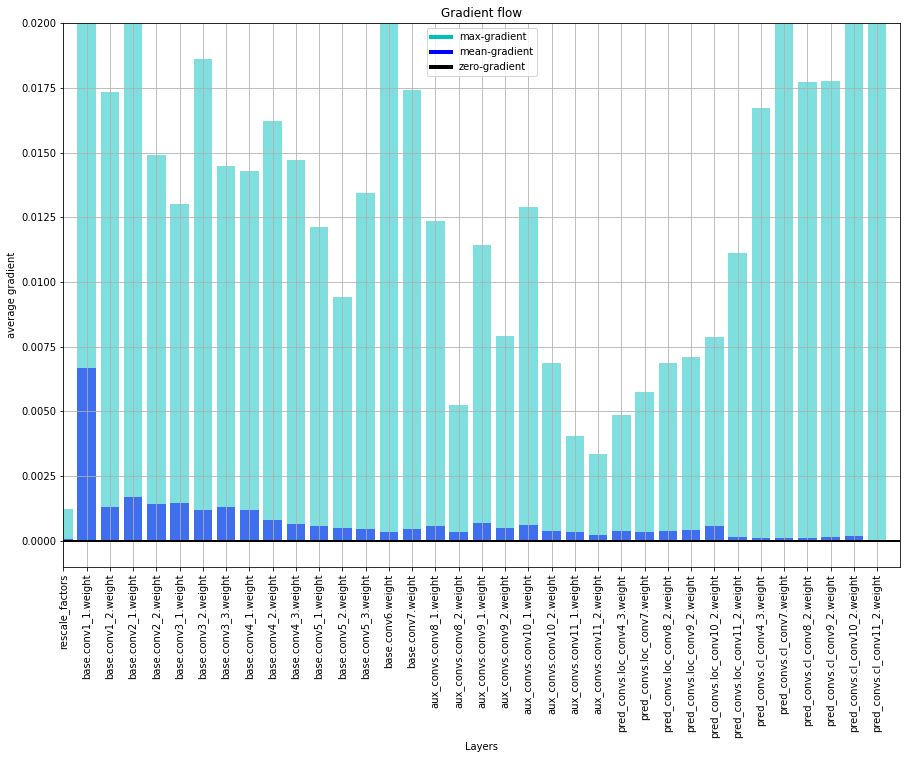

Epoch: [67][1200/3697]	Batch Time 0.426 (0.428)	Data Time 0.000 (0.002)	Loss 3.0744 (3.1342)	Loss_c 2.6651 (2.7436)	Loss_l 0.4093 (0.3906)	
Epoch: [67][1400/3697]	Batch Time 0.423 (0.428)	Data Time 0.000 (0.002)	Loss 3.4233 (3.1319)	Loss_c 3.0206 (2.7415)	Loss_l 0.4027 (0.3904)	
Epoch: [67][1600/3697]	Batch Time 0.423 (0.427)	Data Time 0.000 (0.002)	Loss 3.1429 (3.1328)	Loss_c 2.7433 (2.7430)	Loss_l 0.3996 (0.3898)	
Epoch: [67][1800/3697]	Batch Time 0.424 (0.427)	Data Time 0.000 (0.001)	Loss 3.1939 (3.1337)	Loss_c 2.8623 (2.7433)	Loss_l 0.3317 (0.3904)	
Epoch: [67][2000/3697]	Batch Time 0.423 (0.427)	Data Time 0.000 (0.001)	Loss 3.0949 (3.1316)	Loss_c 2.7294 (2.7415)	Loss_l 0.3655 (0.3901)	


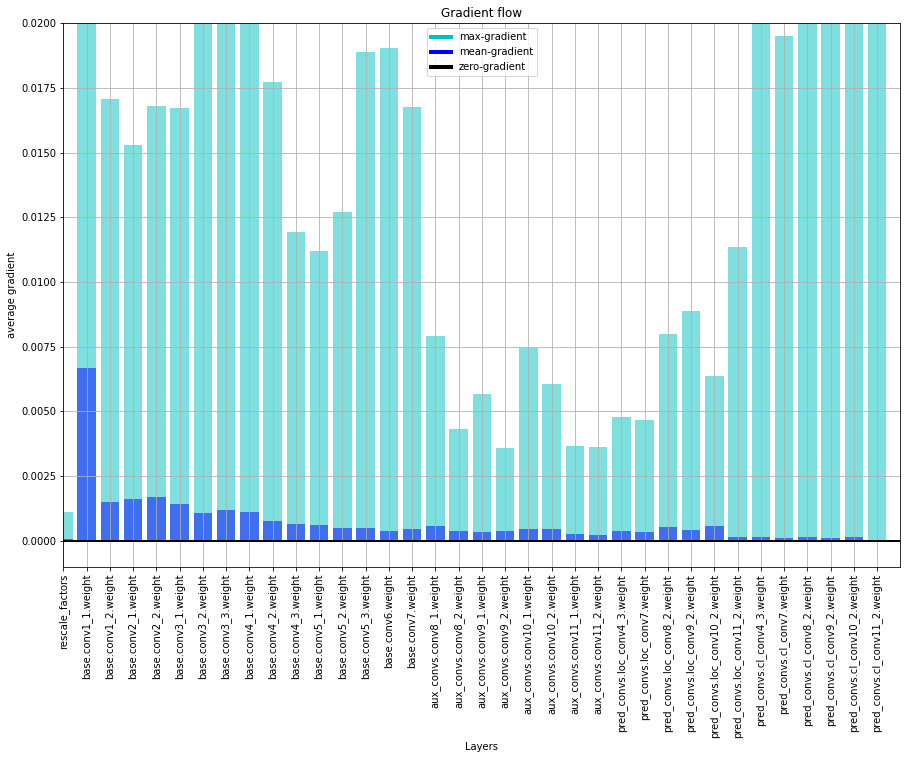

Epoch: [67][2200/3697]	Batch Time 0.421 (0.427)	Data Time 0.000 (0.002)	Loss 3.2135 (3.1276)	Loss_c 2.7742 (2.7382)	Loss_l 0.4394 (0.3894)	
Epoch: [67][2400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.002)	Loss 3.1683 (3.1272)	Loss_c 2.7925 (2.7380)	Loss_l 0.3758 (0.3892)	
Epoch: [67][2600/3697]	Batch Time 0.422 (0.426)	Data Time 0.000 (0.002)	Loss 3.3780 (3.1283)	Loss_c 2.9252 (2.7386)	Loss_l 0.4527 (0.3897)	
Epoch: [67][2800/3697]	Batch Time 0.422 (0.426)	Data Time 0.000 (0.001)	Loss 3.1990 (3.1273)	Loss_c 2.7896 (2.7376)	Loss_l 0.4094 (0.3897)	
Epoch: [67][3000/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.001)	Loss 3.1871 (3.1290)	Loss_c 2.7768 (2.7388)	Loss_l 0.4103 (0.3902)	


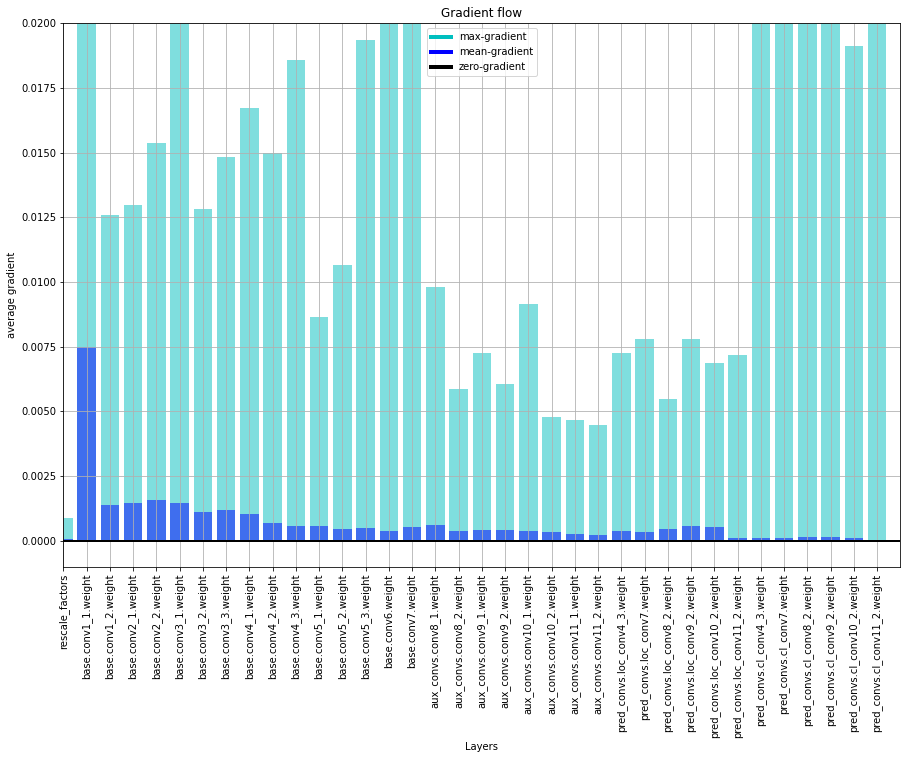

Epoch: [67][3200/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.001)	Loss 3.2754 (3.1286)	Loss_c 2.8817 (2.7384)	Loss_l 0.3937 (0.3903)	
Epoch: [67][3400/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.001)	Loss 3.0052 (3.1300)	Loss_c 2.6923 (2.7393)	Loss_l 0.3129 (0.3907)	
Epoch: [67][3600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.001)	Loss 3.2151 (3.1307)	Loss_c 2.8300 (2.7399)	Loss_l 0.3851 (0.3907)	
Epoch: [68][0/3697]	Batch Time 1.941 (1.941)	Data Time 1.481 (1.481)	Loss 3.1296 (3.1296)	Loss_c 2.7230 (2.7230)	Loss_l 0.4066 (0.4066)	


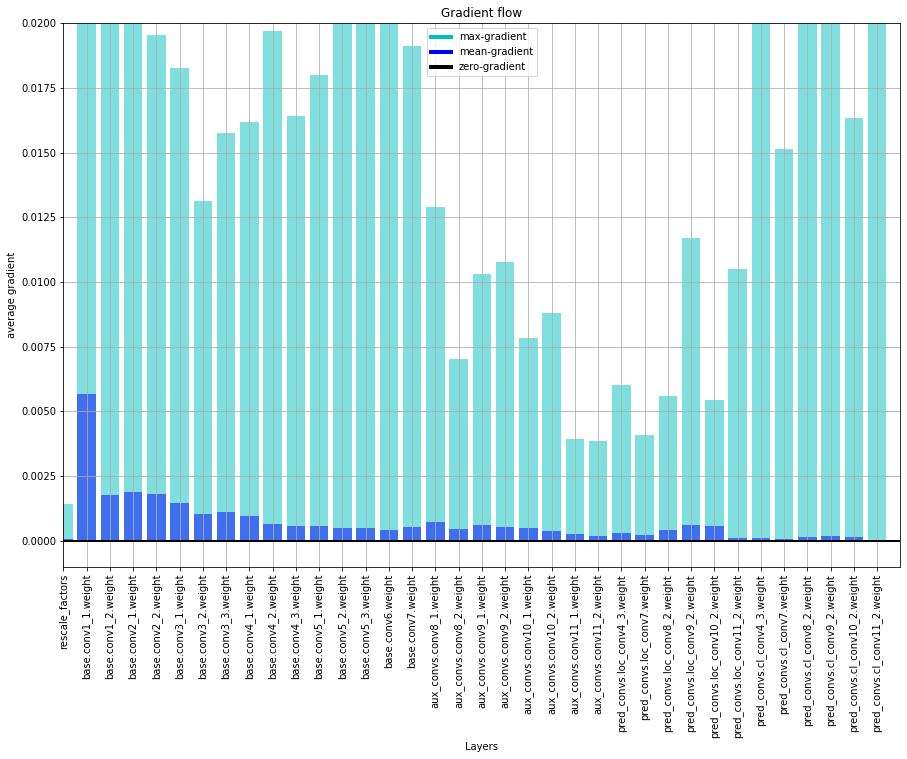

Epoch: [68][200/3697]	Batch Time 0.430 (0.432)	Data Time 0.000 (0.010)	Loss 2.9428 (3.1416)	Loss_c 2.6034 (2.7496)	Loss_l 0.3394 (0.3921)	
Epoch: [68][400/3697]	Batch Time 0.421 (0.428)	Data Time 0.000 (0.005)	Loss 3.0308 (3.1322)	Loss_c 2.6472 (2.7425)	Loss_l 0.3835 (0.3897)	
Epoch: [68][600/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.003)	Loss 3.0179 (3.1295)	Loss_c 2.6476 (2.7395)	Loss_l 0.3703 (0.3901)	
Epoch: [68][800/3697]	Batch Time 0.423 (0.425)	Data Time 0.000 (0.003)	Loss 2.8897 (3.1286)	Loss_c 2.5510 (2.7384)	Loss_l 0.3386 (0.3902)	
Epoch: [68][1000/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.002)	Loss 3.1146 (3.1221)	Loss_c 2.6792 (2.7328)	Loss_l 0.4355 (0.3892)	


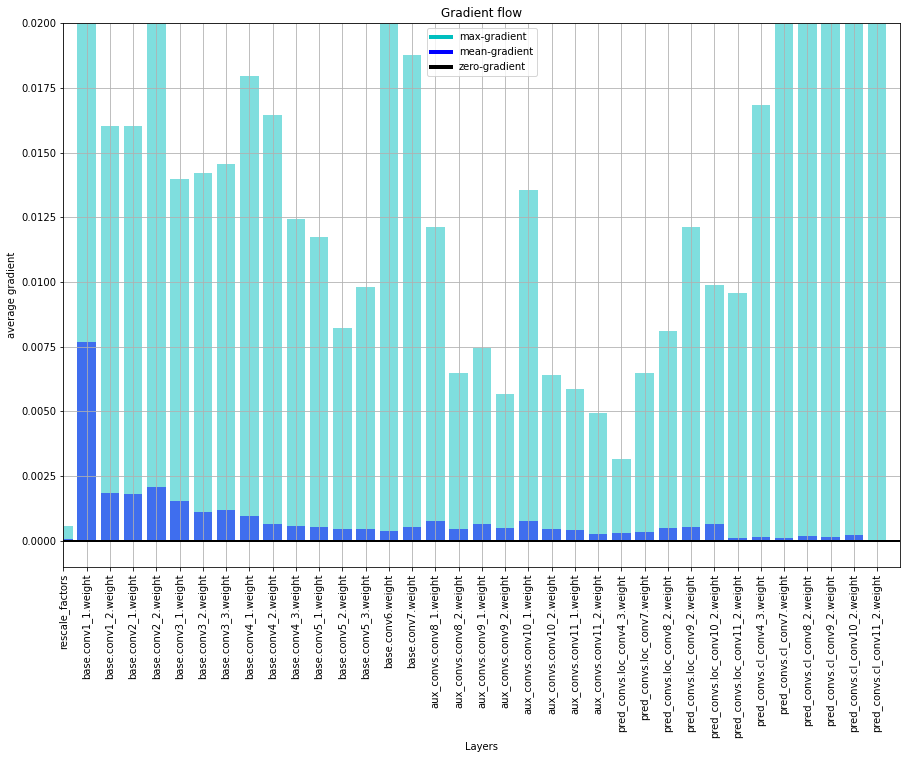

Epoch: [68][1200/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.002)	Loss 3.1184 (3.1278)	Loss_c 2.7785 (2.7370)	Loss_l 0.3398 (0.3908)	
Epoch: [68][1400/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.0159 (3.1300)	Loss_c 2.6481 (2.7392)	Loss_l 0.3678 (0.3908)	
Epoch: [68][1600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1020 (3.1318)	Loss_c 2.7483 (2.7406)	Loss_l 0.3538 (0.3912)	
Epoch: [68][1800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.001)	Loss 3.2762 (3.1317)	Loss_c 2.8587 (2.7401)	Loss_l 0.4175 (0.3917)	
Epoch: [68][2000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.001)	Loss 3.2797 (3.1312)	Loss_c 2.9100 (2.7393)	Loss_l 0.3697 (0.3919)	


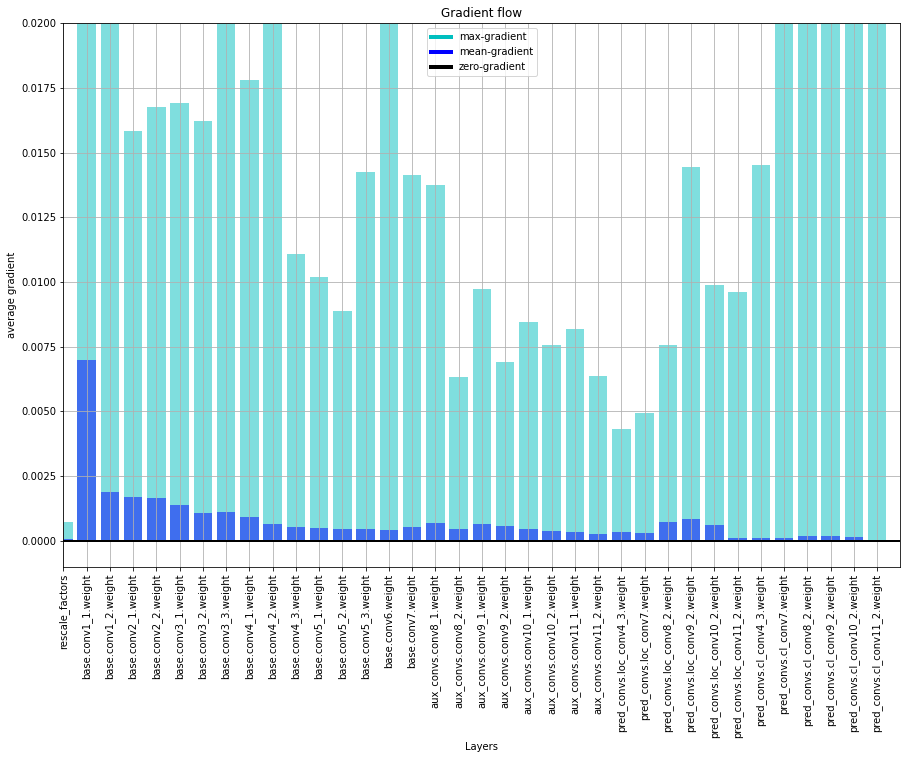

Epoch: [68][2200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 2.9264 (3.1299)	Loss_c 2.5896 (2.7382)	Loss_l 0.3368 (0.3916)	
Epoch: [68][2400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.8883 (3.1311)	Loss_c 2.5230 (2.7392)	Loss_l 0.3653 (0.3918)	
Epoch: [68][2600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.6380 (3.1311)	Loss_c 2.3556 (2.7391)	Loss_l 0.2824 (0.3920)	
Epoch: [68][2800/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.3012 (3.1325)	Loss_c 2.9004 (2.7402)	Loss_l 0.4008 (0.3923)	
Epoch: [68][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0023 (3.1326)	Loss_c 2.6276 (2.7400)	Loss_l 0.3747 (0.3926)	


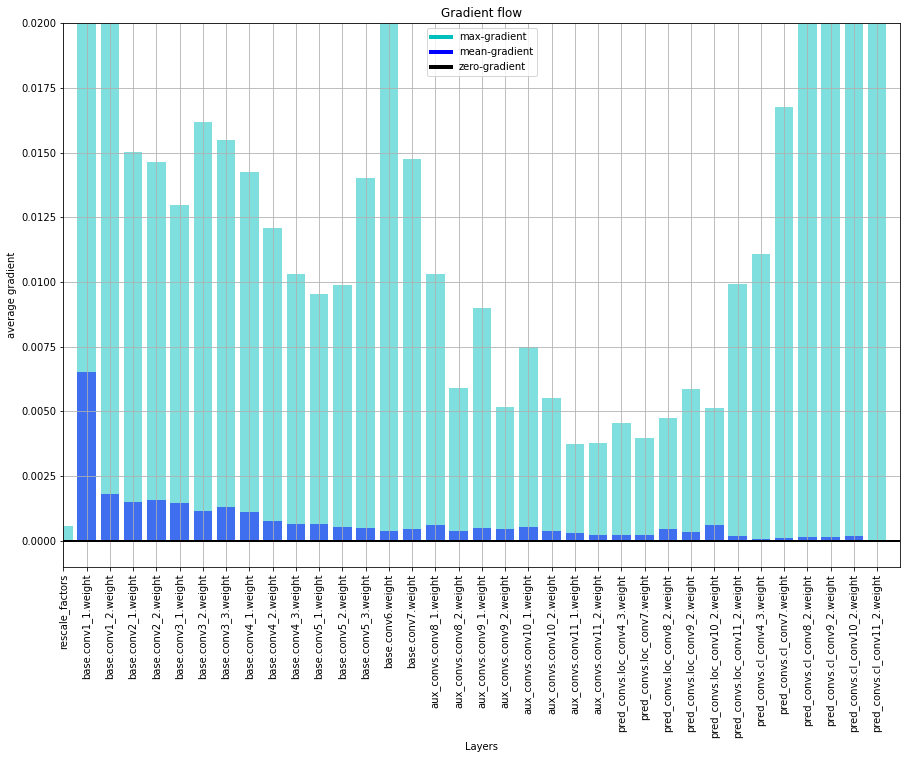

Epoch: [68][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2666 (3.1340)	Loss_c 2.8051 (2.7412)	Loss_l 0.4615 (0.3928)	
Epoch: [68][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3997 (3.1322)	Loss_c 2.9745 (2.7397)	Loss_l 0.4252 (0.3926)	
Epoch: [68][3600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2469 (3.1315)	Loss_c 2.8187 (2.7393)	Loss_l 0.4281 (0.3922)	
Epoch: [69][0/3697]	Batch Time 1.708 (1.708)	Data Time 1.269 (1.269)	Loss 3.3583 (3.3583)	Loss_c 2.9624 (2.9624)	Loss_l 0.3959 (0.3959)	


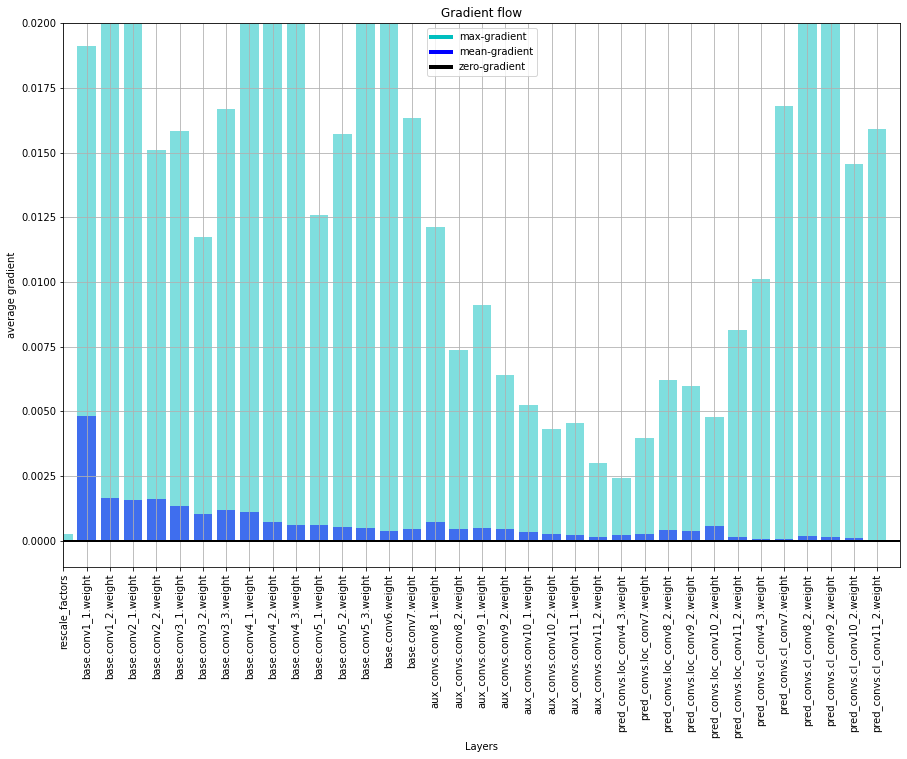

Epoch: [69][200/3697]	Batch Time 0.422 (0.431)	Data Time 0.000 (0.009)	Loss 3.1399 (3.1222)	Loss_c 2.7682 (2.7333)	Loss_l 0.3716 (0.3889)	
Epoch: [69][400/3697]	Batch Time 0.421 (0.427)	Data Time 0.000 (0.004)	Loss 3.0232 (3.1089)	Loss_c 2.6160 (2.7213)	Loss_l 0.4072 (0.3877)	
Epoch: [69][600/3697]	Batch Time 0.420 (0.425)	Data Time 0.000 (0.003)	Loss 3.2096 (3.1154)	Loss_c 2.8027 (2.7258)	Loss_l 0.4069 (0.3896)	
Epoch: [69][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.1375 (3.1180)	Loss_c 2.7908 (2.7287)	Loss_l 0.3467 (0.3893)	
Epoch: [69][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.3174 (3.1215)	Loss_c 2.9610 (2.7312)	Loss_l 0.3564 (0.3903)	


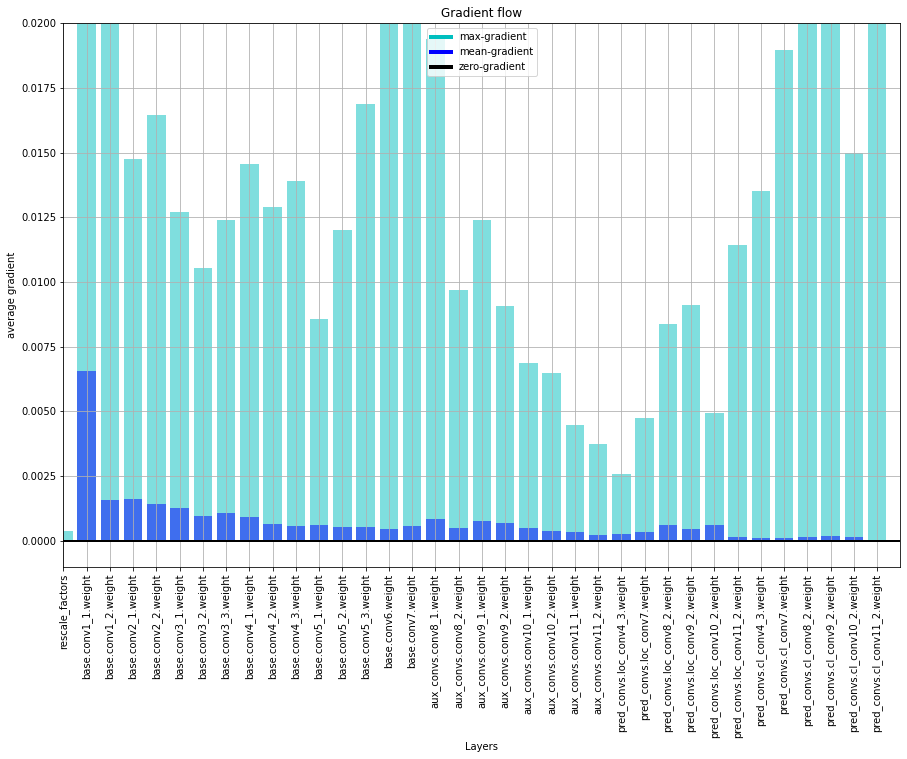

Epoch: [69][1200/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.0722 (3.1215)	Loss_c 2.6576 (2.7310)	Loss_l 0.4146 (0.3905)	
Epoch: [69][1400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 2.9544 (3.1223)	Loss_c 2.6034 (2.7318)	Loss_l 0.3510 (0.3905)	
Epoch: [69][1600/3697]	Batch Time 0.424 (0.423)	Data Time 0.000 (0.001)	Loss 2.7977 (3.1219)	Loss_c 2.4677 (2.7313)	Loss_l 0.3300 (0.3906)	
Epoch: [69][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1451 (3.1246)	Loss_c 2.7539 (2.7338)	Loss_l 0.3912 (0.3908)	
Epoch: [69][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0524 (3.1235)	Loss_c 2.7046 (2.7336)	Loss_l 0.3477 (0.3899)	


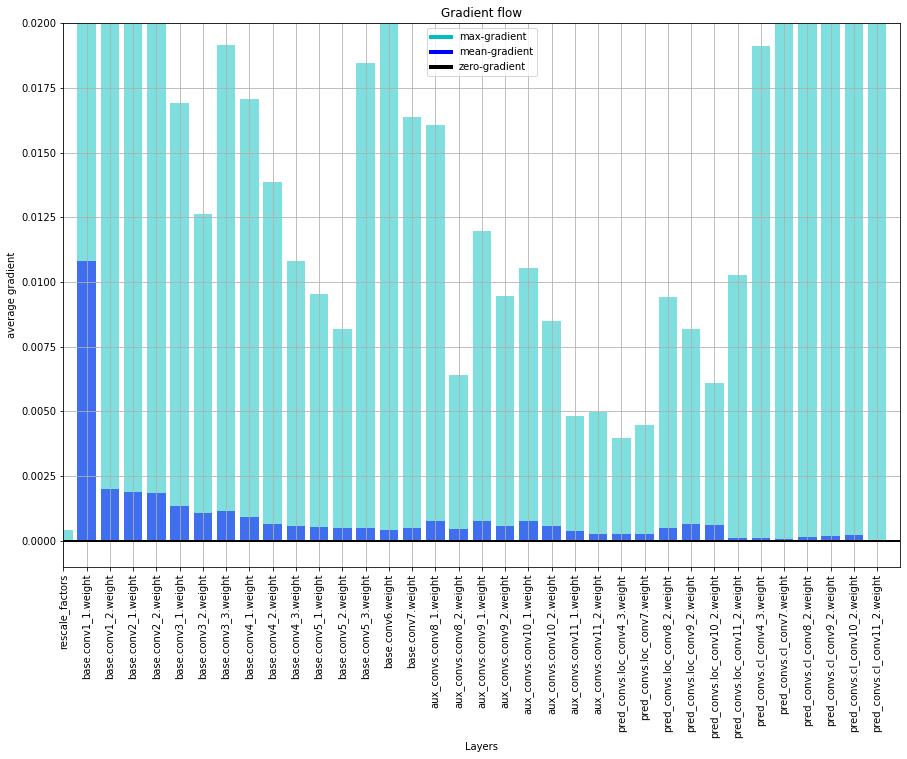

Epoch: [69][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0764 (3.1238)	Loss_c 2.6946 (2.7337)	Loss_l 0.3818 (0.3901)	
Epoch: [69][2400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2420 (3.1232)	Loss_c 2.8542 (2.7333)	Loss_l 0.3878 (0.3899)	
Epoch: [69][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0184 (3.1233)	Loss_c 2.6033 (2.7336)	Loss_l 0.4150 (0.3897)	
Epoch: [69][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3222 (3.1245)	Loss_c 2.8767 (2.7347)	Loss_l 0.4456 (0.3898)	
Epoch: [69][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1653 (3.1247)	Loss_c 2.8500 (2.7351)	Loss_l 0.3153 (0.3896)	


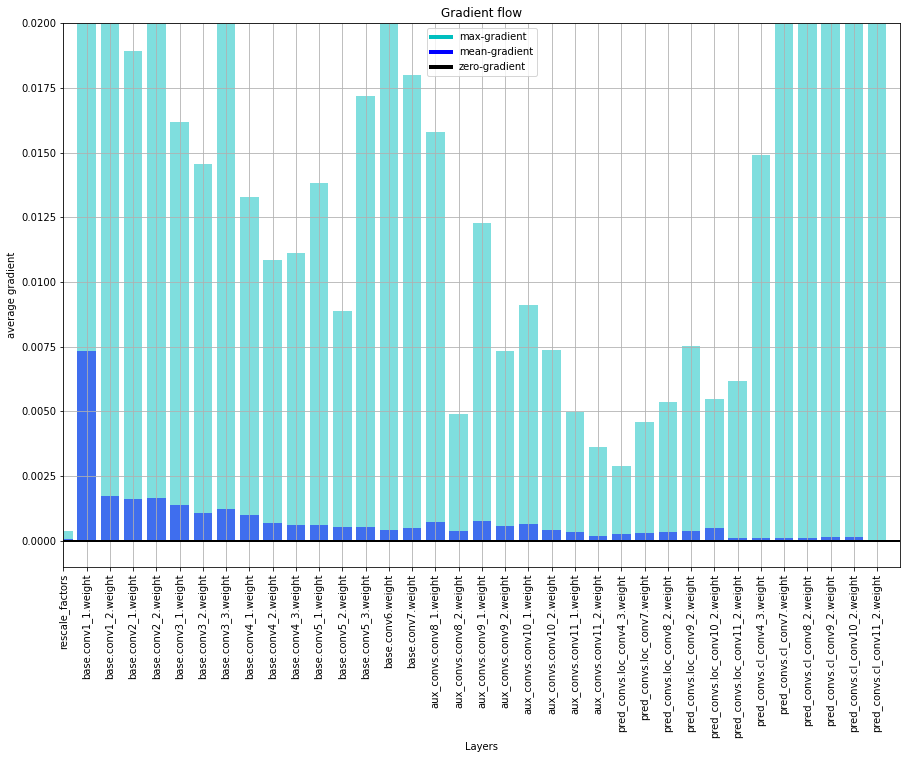

Epoch: [69][3200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3599 (3.1246)	Loss_c 2.9174 (2.7352)	Loss_l 0.4424 (0.3894)	
Epoch: [69][3400/3697]	Batch Time 0.426 (0.423)	Data Time 0.000 (0.001)	Loss 3.1317 (3.1248)	Loss_c 2.7793 (2.7350)	Loss_l 0.3524 (0.3898)	
Epoch: [69][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2016 (3.1245)	Loss_c 2.7465 (2.7344)	Loss_l 0.4551 (0.3901)	
Epoch: [70][0/3697]	Batch Time 1.636 (1.636)	Data Time 1.202 (1.202)	Loss 3.3811 (3.3811)	Loss_c 2.9706 (2.9706)	Loss_l 0.4105 (0.4105)	


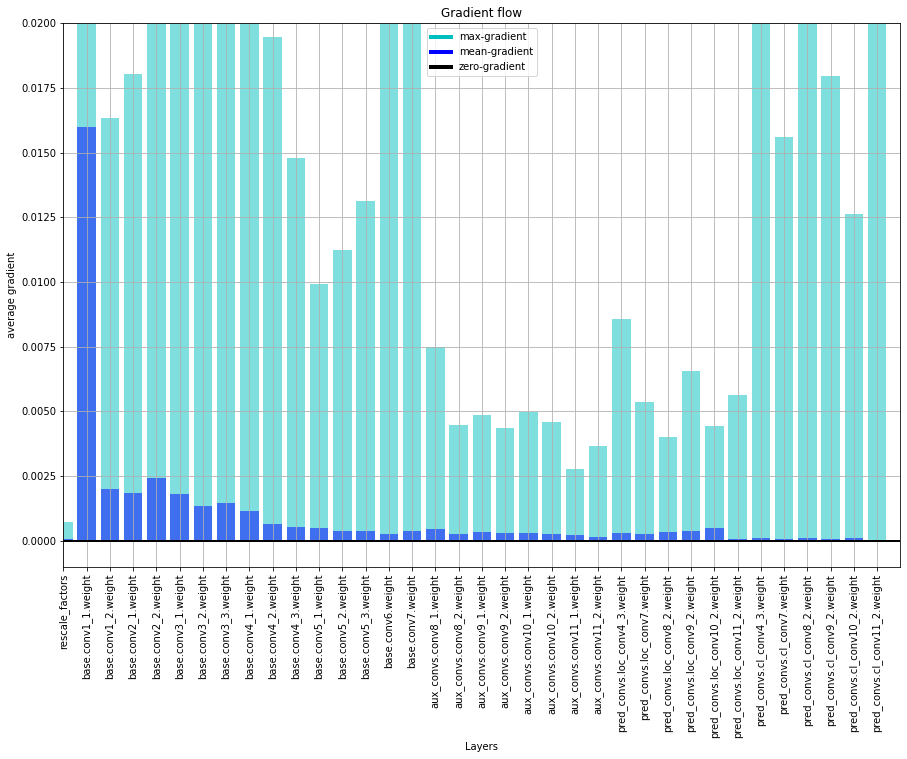

Epoch: [70][200/3697]	Batch Time 0.422 (0.430)	Data Time 0.000 (0.008)	Loss 3.0014 (3.1186)	Loss_c 2.6034 (2.7305)	Loss_l 0.3980 (0.3881)	
Epoch: [70][400/3697]	Batch Time 0.423 (0.426)	Data Time 0.000 (0.004)	Loss 3.0320 (3.1259)	Loss_c 2.6274 (2.7351)	Loss_l 0.4046 (0.3908)	
Epoch: [70][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.0761 (3.1260)	Loss_c 2.6843 (2.7346)	Loss_l 0.3919 (0.3914)	
Epoch: [70][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.3112 (3.1246)	Loss_c 2.9237 (2.7340)	Loss_l 0.3875 (0.3906)	
Epoch: [70][1000/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.002)	Loss 3.1826 (3.1277)	Loss_c 2.7735 (2.7359)	Loss_l 0.4091 (0.3918)	


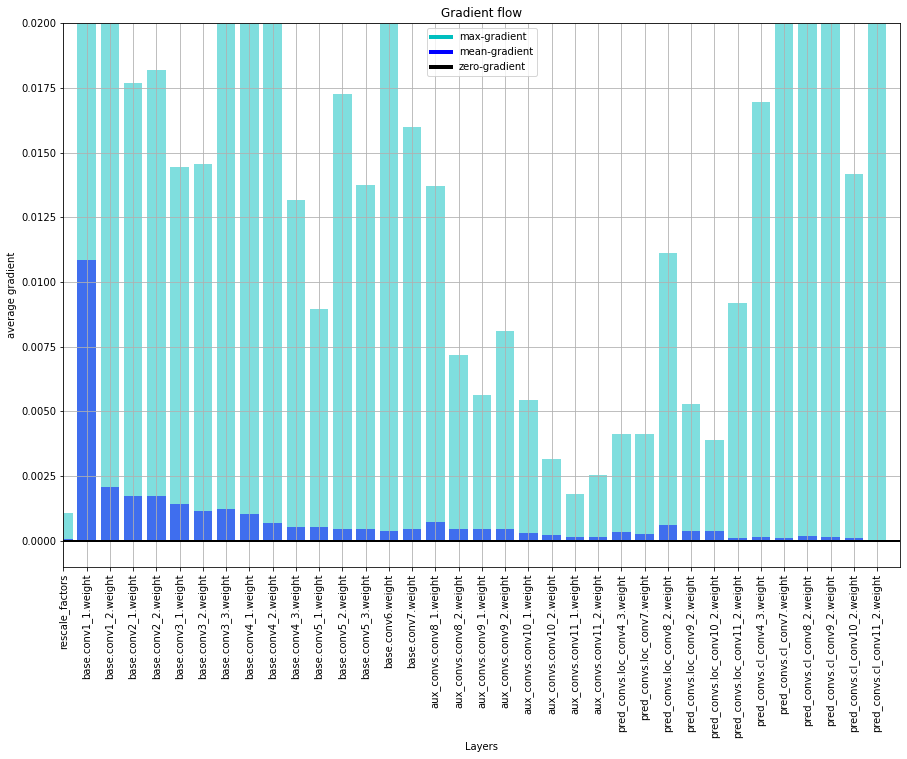

Epoch: [70][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.9930 (3.1283)	Loss_c 2.5129 (2.7368)	Loss_l 0.4801 (0.3914)	
Epoch: [70][1400/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.7806 (3.1252)	Loss_c 2.4559 (2.7345)	Loss_l 0.3247 (0.3907)	
Epoch: [70][1600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.0264 (3.1261)	Loss_c 2.6531 (2.7350)	Loss_l 0.3733 (0.3910)	
Epoch: [70][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0283 (3.1257)	Loss_c 2.6605 (2.7344)	Loss_l 0.3678 (0.3912)	
Epoch: [70][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.3887 (3.1271)	Loss_c 2.9013 (2.7354)	Loss_l 0.4874 (0.3916)	


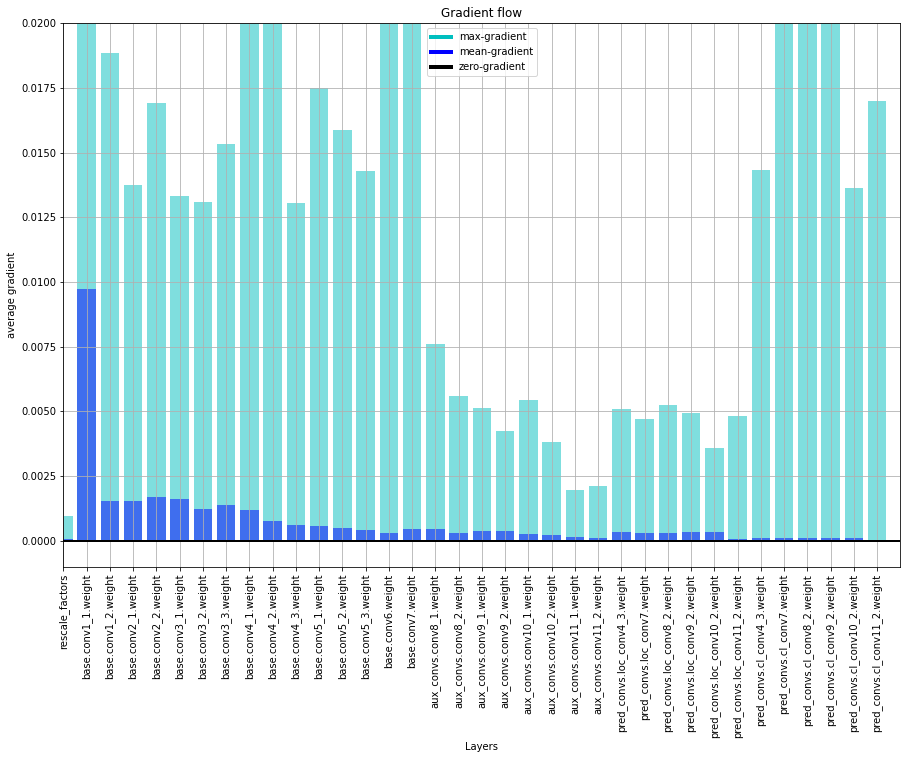

Epoch: [70][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.5385 (3.1268)	Loss_c 3.1640 (2.7355)	Loss_l 0.3745 (0.3913)	
Epoch: [70][2400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2368 (3.1270)	Loss_c 2.8489 (2.7356)	Loss_l 0.3879 (0.3914)	
Epoch: [70][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0178 (3.1270)	Loss_c 2.6915 (2.7360)	Loss_l 0.3263 (0.3911)	
Epoch: [70][2800/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 2.9816 (3.1284)	Loss_c 2.5964 (2.7370)	Loss_l 0.3852 (0.3914)	
Epoch: [70][3000/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 2.9826 (3.1285)	Loss_c 2.6609 (2.7371)	Loss_l 0.3217 (0.3914)	


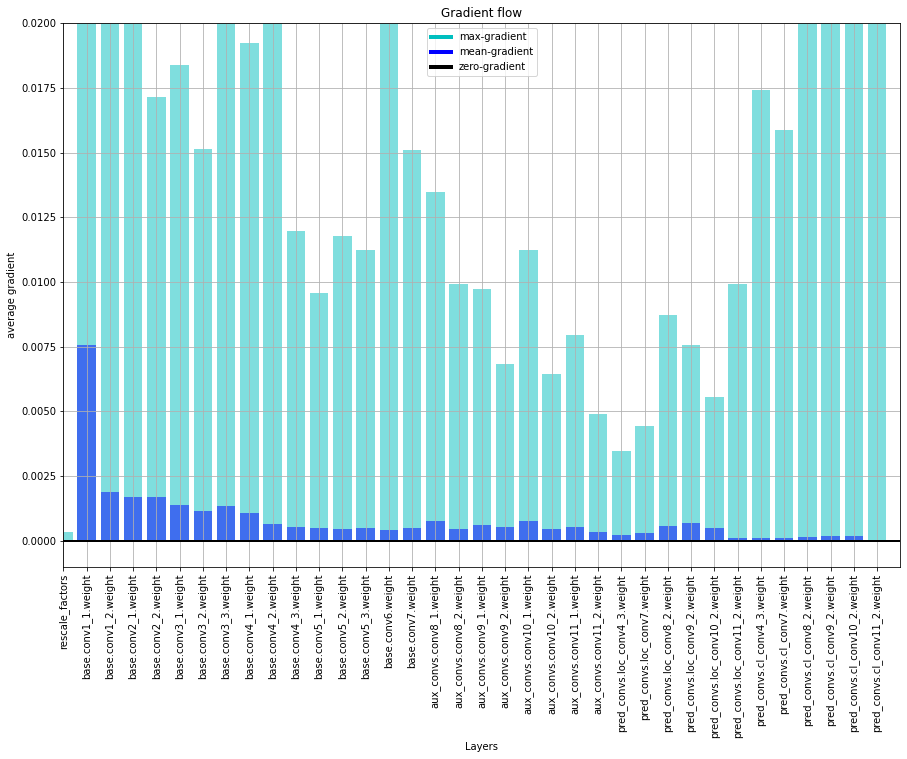

Epoch: [70][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.6956 (3.1287)	Loss_c 2.3652 (2.7373)	Loss_l 0.3304 (0.3914)	
Epoch: [70][3400/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.0502 (3.1285)	Loss_c 2.6553 (2.7372)	Loss_l 0.3950 (0.3913)	
Epoch: [70][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0014 (3.1280)	Loss_c 2.6197 (2.7371)	Loss_l 0.3817 (0.3909)	
Epoch: [71][0/3697]	Batch Time 2.006 (2.006)	Data Time 1.564 (1.564)	Loss 3.1736 (3.1736)	Loss_c 2.7786 (2.7786)	Loss_l 0.3950 (0.3950)	


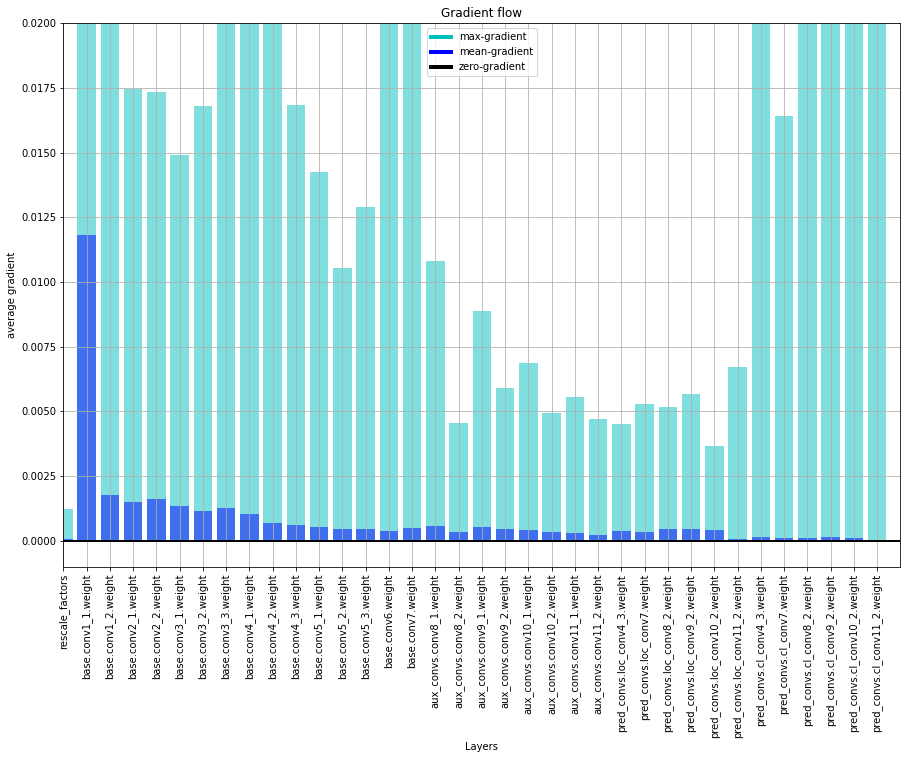

Epoch: [71][200/3697]	Batch Time 0.426 (0.433)	Data Time 0.000 (0.010)	Loss 2.9623 (3.1386)	Loss_c 2.5874 (2.7459)	Loss_l 0.3749 (0.3927)	
Epoch: [71][400/3697]	Batch Time 0.425 (0.427)	Data Time 0.000 (0.005)	Loss 3.3431 (3.1380)	Loss_c 2.8484 (2.7444)	Loss_l 0.4948 (0.3936)	
Epoch: [71][600/3697]	Batch Time 0.426 (0.426)	Data Time 0.000 (0.003)	Loss 3.2904 (3.1340)	Loss_c 2.8968 (2.7407)	Loss_l 0.3936 (0.3933)	
Epoch: [71][800/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.2345 (3.1307)	Loss_c 2.8378 (2.7382)	Loss_l 0.3967 (0.3925)	
Epoch: [71][1000/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.3664 (3.1267)	Loss_c 2.8450 (2.7345)	Loss_l 0.5213 (0.3922)	


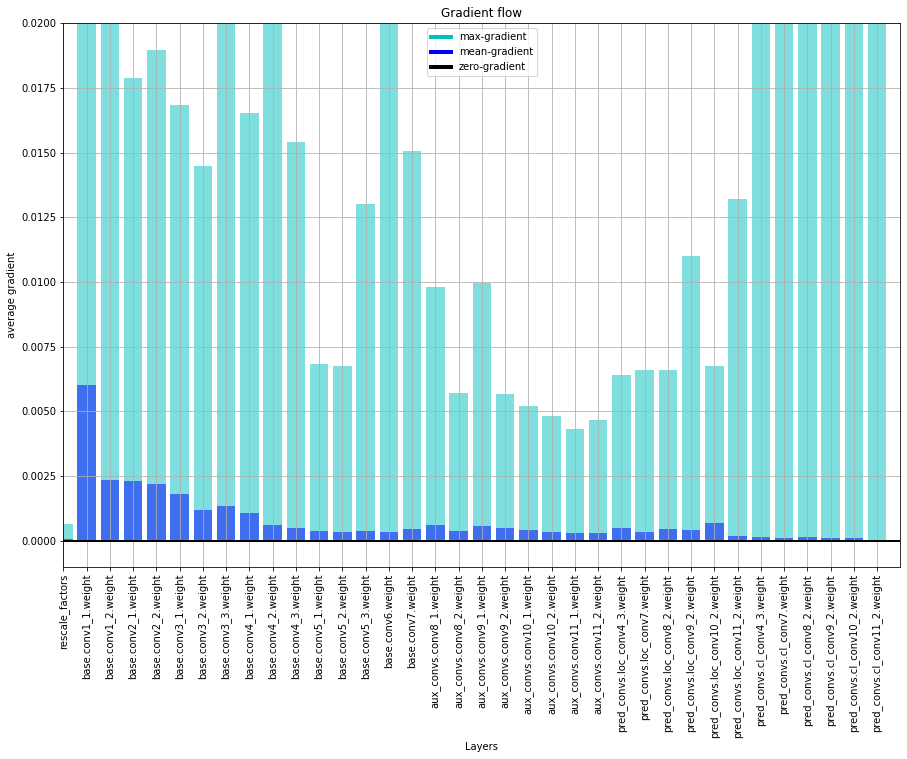

Epoch: [71][1200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.5035 (3.1242)	Loss_c 3.0516 (2.7322)	Loss_l 0.4519 (0.3921)	
Epoch: [71][1400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.4954 (3.1226)	Loss_c 2.9948 (2.7316)	Loss_l 0.5006 (0.3910)	
Epoch: [71][1600/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.5051 (3.1235)	Loss_c 3.0713 (2.7331)	Loss_l 0.4339 (0.3904)	
Epoch: [71][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.2780 (3.1242)	Loss_c 2.9175 (2.7337)	Loss_l 0.3605 (0.3905)	
Epoch: [71][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1061 (3.1257)	Loss_c 2.6967 (2.7349)	Loss_l 0.4094 (0.3908)	


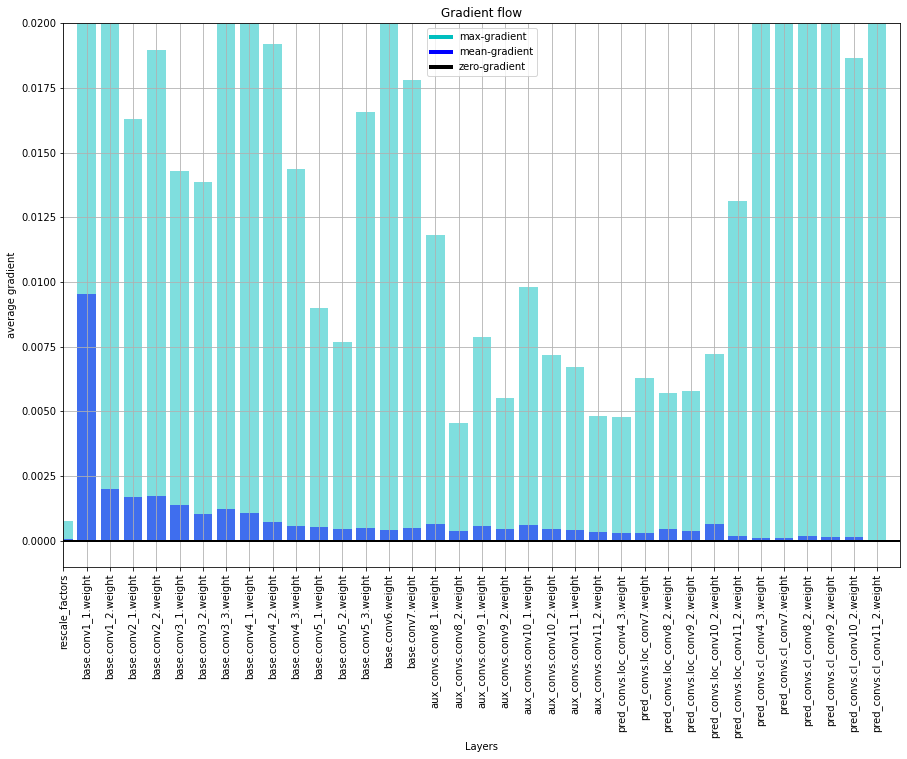

Epoch: [71][2200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 2.8536 (3.1246)	Loss_c 2.5011 (2.7341)	Loss_l 0.3525 (0.3904)	
Epoch: [71][2400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.8189 (3.1242)	Loss_c 3.2556 (2.7342)	Loss_l 0.5634 (0.3899)	
Epoch: [71][2600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.2089 (3.1258)	Loss_c 2.8411 (2.7352)	Loss_l 0.3679 (0.3906)	
Epoch: [71][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3711 (3.1262)	Loss_c 2.9517 (2.7355)	Loss_l 0.4194 (0.3906)	
Epoch: [71][3000/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.0570 (3.1269)	Loss_c 2.6375 (2.7361)	Loss_l 0.4195 (0.3908)	


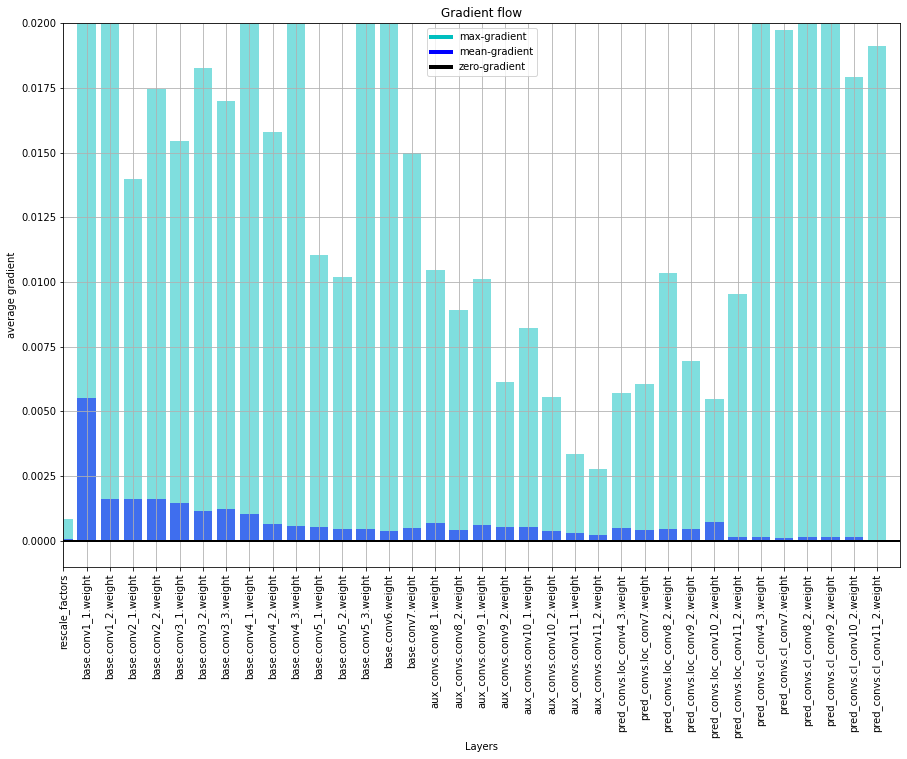

Epoch: [71][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.8509 (3.1267)	Loss_c 2.4962 (2.7361)	Loss_l 0.3547 (0.3906)	
Epoch: [71][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2525 (3.1282)	Loss_c 2.8408 (2.7372)	Loss_l 0.4118 (0.3910)	
Epoch: [71][3600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.4044 (3.1306)	Loss_c 3.0220 (2.7391)	Loss_l 0.3824 (0.3915)	
Epoch: [72][0/3697]	Batch Time 1.979 (1.979)	Data Time 1.532 (1.532)	Loss 2.8810 (2.8810)	Loss_c 2.5503 (2.5503)	Loss_l 0.3307 (0.3307)	


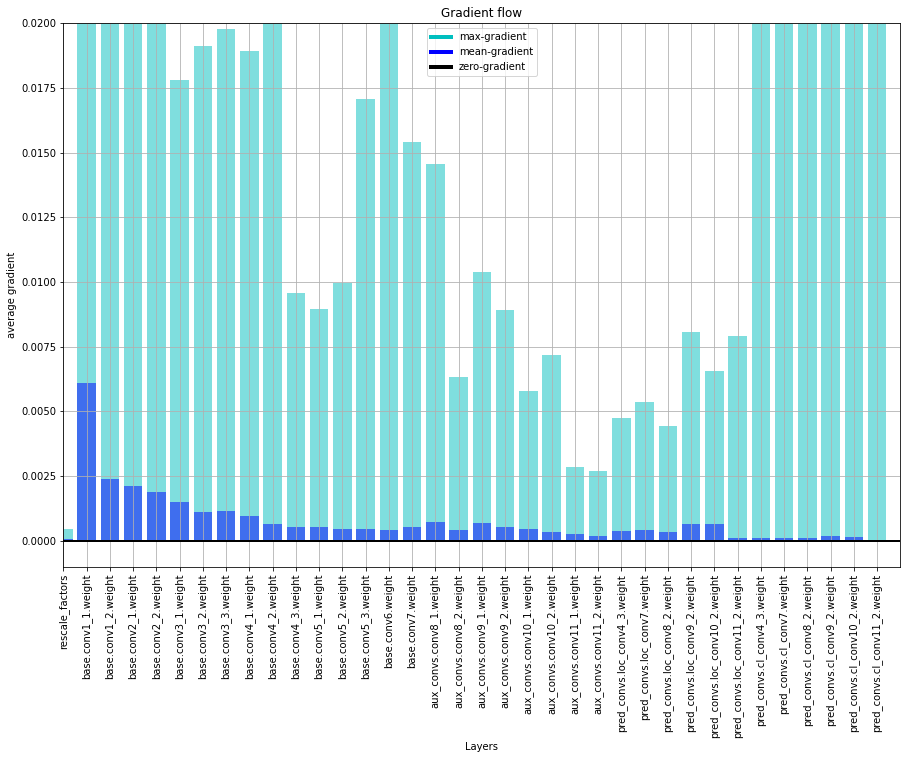

Epoch: [72][200/3697]	Batch Time 0.420 (0.432)	Data Time 0.000 (0.010)	Loss 2.9916 (3.1209)	Loss_c 2.6509 (2.7285)	Loss_l 0.3407 (0.3924)	
Epoch: [72][400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.005)	Loss 3.3102 (3.1313)	Loss_c 2.9250 (2.7378)	Loss_l 0.3852 (0.3935)	
Epoch: [72][600/3697]	Batch Time 0.427 (0.425)	Data Time 0.000 (0.003)	Loss 3.2409 (3.1340)	Loss_c 2.8574 (2.7427)	Loss_l 0.3835 (0.3913)	
Epoch: [72][800/3697]	Batch Time 0.428 (0.425)	Data Time 0.000 (0.003)	Loss 2.9786 (3.1314)	Loss_c 2.6075 (2.7400)	Loss_l 0.3711 (0.3914)	
Epoch: [72][1000/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.002)	Loss 3.1911 (3.1290)	Loss_c 2.8611 (2.7382)	Loss_l 0.3300 (0.3908)	


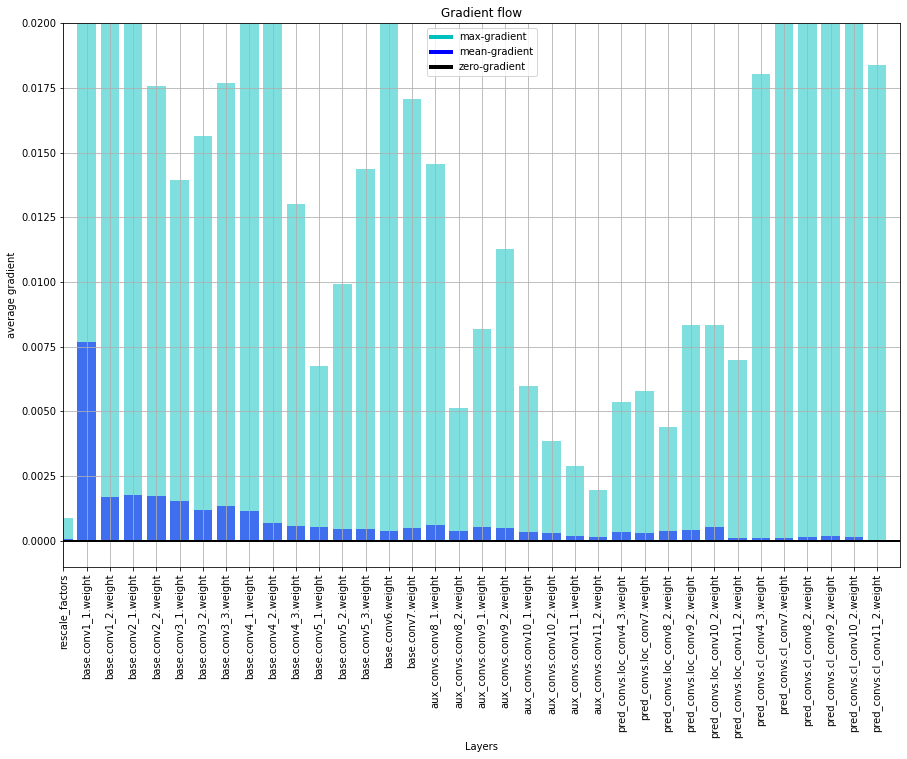

Epoch: [72][1200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0449 (3.1306)	Loss_c 2.6298 (2.7389)	Loss_l 0.4151 (0.3917)	
Epoch: [72][1400/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.002)	Loss 3.2685 (3.1284)	Loss_c 2.8912 (2.7374)	Loss_l 0.3772 (0.3911)	
Epoch: [72][1600/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.002)	Loss 3.2740 (3.1277)	Loss_c 2.9032 (2.7369)	Loss_l 0.3708 (0.3908)	
Epoch: [72][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 2.9120 (3.1254)	Loss_c 2.5246 (2.7343)	Loss_l 0.3874 (0.3910)	
Epoch: [72][2000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.4101 (3.1271)	Loss_c 2.9951 (2.7354)	Loss_l 0.4150 (0.3917)	


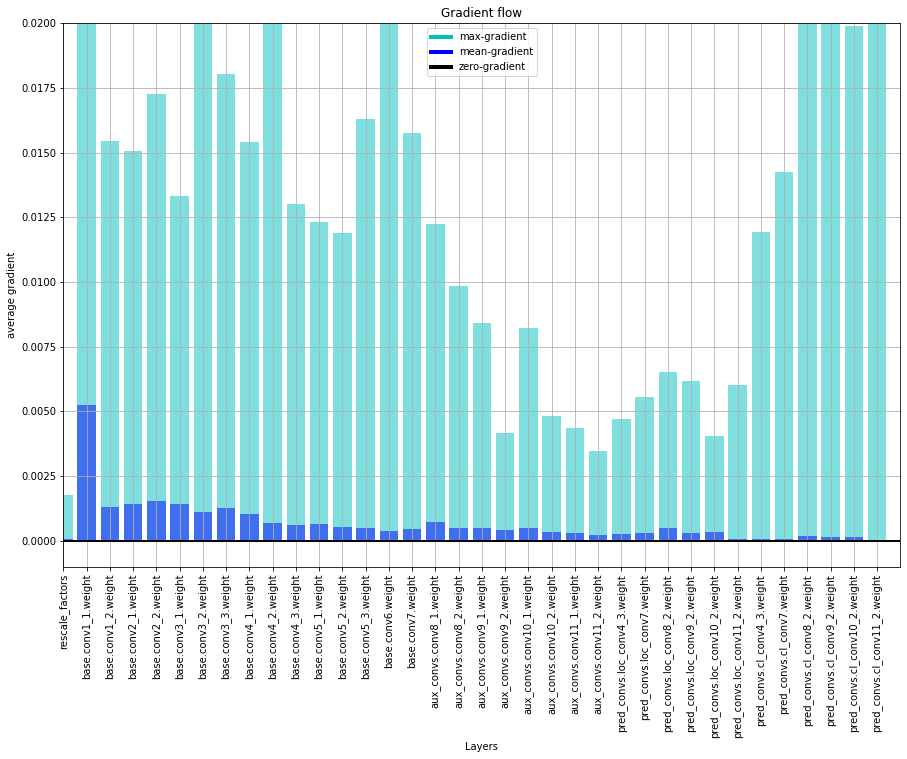

Epoch: [72][2200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 2.8081 (3.1273)	Loss_c 2.4397 (2.7357)	Loss_l 0.3684 (0.3916)	
Epoch: [72][2400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.4743 (3.1269)	Loss_c 3.0244 (2.7352)	Loss_l 0.4499 (0.3917)	
Epoch: [72][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9490 (3.1273)	Loss_c 2.6062 (2.7359)	Loss_l 0.3427 (0.3914)	
Epoch: [72][2800/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 2.9800 (3.1278)	Loss_c 2.6271 (2.7367)	Loss_l 0.3529 (0.3911)	
Epoch: [72][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2151 (3.1265)	Loss_c 2.7526 (2.7355)	Loss_l 0.4626 (0.3909)	


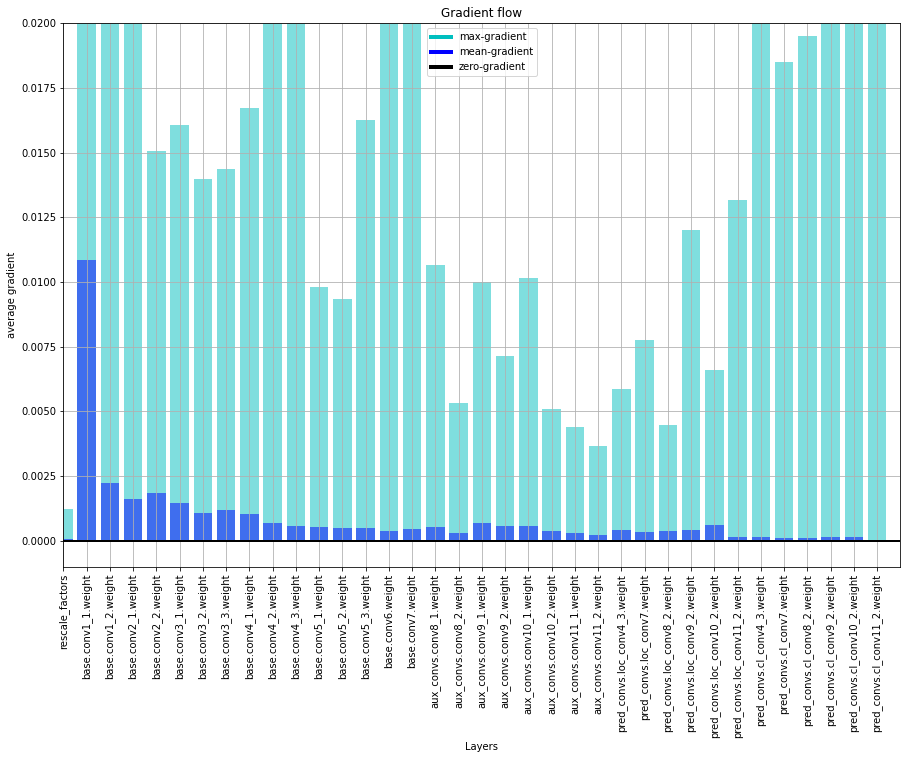

Epoch: [72][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9804 (3.1263)	Loss_c 2.6023 (2.7353)	Loss_l 0.3781 (0.3910)	
Epoch: [72][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9436 (3.1258)	Loss_c 2.6241 (2.7350)	Loss_l 0.3195 (0.3908)	
Epoch: [72][3600/3697]	Batch Time 0.427 (0.423)	Data Time 0.000 (0.001)	Loss 2.9585 (3.1266)	Loss_c 2.5764 (2.7359)	Loss_l 0.3821 (0.3907)	
Epoch: [73][0/3697]	Batch Time 2.009 (2.009)	Data Time 1.549 (1.549)	Loss 3.5243 (3.5243)	Loss_c 2.9750 (2.9750)	Loss_l 0.5493 (0.5493)	


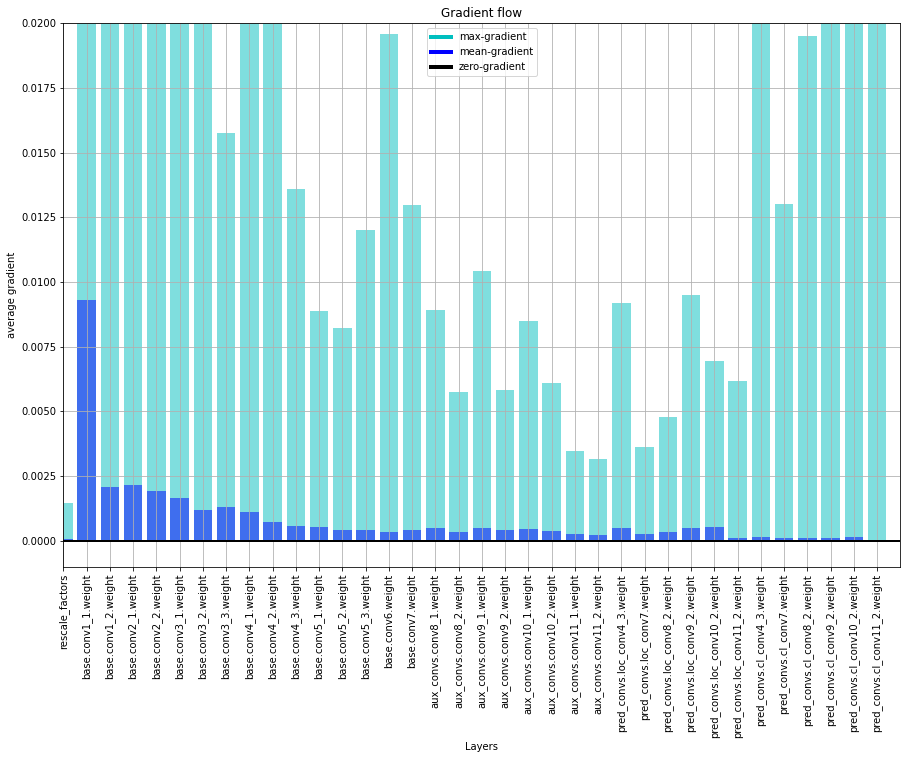

Epoch: [73][200/3697]	Batch Time 0.425 (0.432)	Data Time 0.000 (0.010)	Loss 3.1203 (3.1319)	Loss_c 2.7227 (2.7402)	Loss_l 0.3976 (0.3917)	
Epoch: [73][400/3697]	Batch Time 0.421 (0.427)	Data Time 0.000 (0.005)	Loss 2.9110 (3.1265)	Loss_c 2.5150 (2.7340)	Loss_l 0.3959 (0.3925)	
Epoch: [73][600/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.1904 (3.1319)	Loss_c 2.8297 (2.7404)	Loss_l 0.3607 (0.3915)	
Epoch: [73][800/3697]	Batch Time 0.423 (0.425)	Data Time 0.000 (0.003)	Loss 2.8068 (3.1329)	Loss_c 2.4514 (2.7403)	Loss_l 0.3553 (0.3926)	
Epoch: [73][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.4376 (3.1344)	Loss_c 3.0127 (2.7414)	Loss_l 0.4248 (0.3930)	


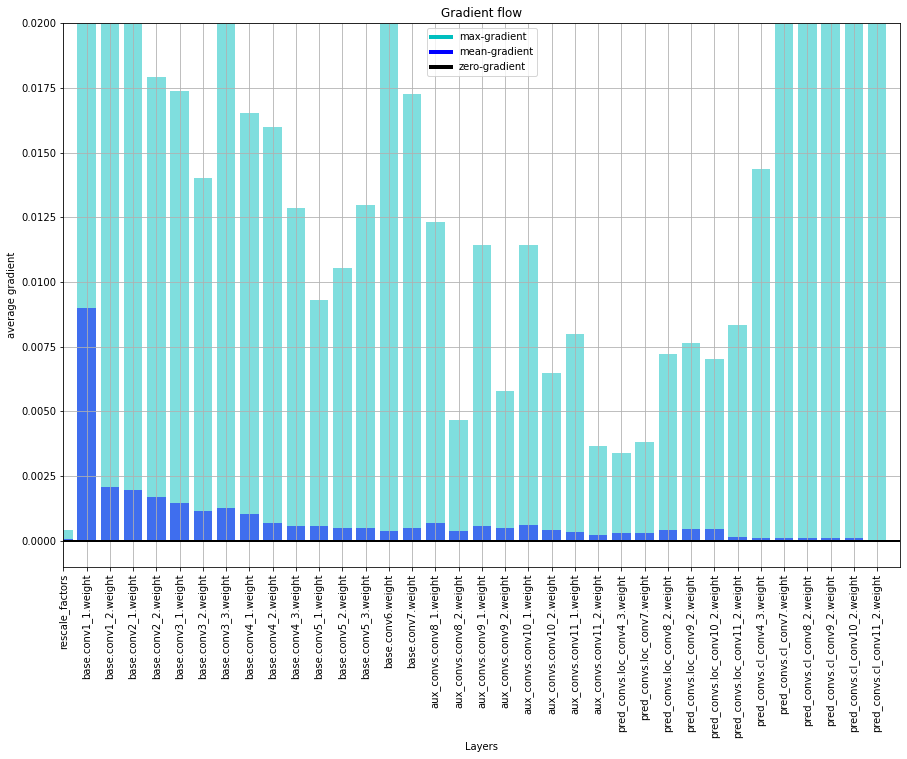

Epoch: [73][1200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1381 (3.1315)	Loss_c 2.7952 (2.7392)	Loss_l 0.3429 (0.3923)	
Epoch: [73][1400/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.0012 (3.1291)	Loss_c 2.6307 (2.7374)	Loss_l 0.3705 (0.3917)	
Epoch: [73][1600/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.0532 (3.1270)	Loss_c 2.6709 (2.7356)	Loss_l 0.3823 (0.3914)	
Epoch: [73][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.6272 (3.1271)	Loss_c 3.2075 (2.7351)	Loss_l 0.4198 (0.3919)	
Epoch: [73][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0066 (3.1253)	Loss_c 2.6032 (2.7336)	Loss_l 0.4034 (0.3917)	


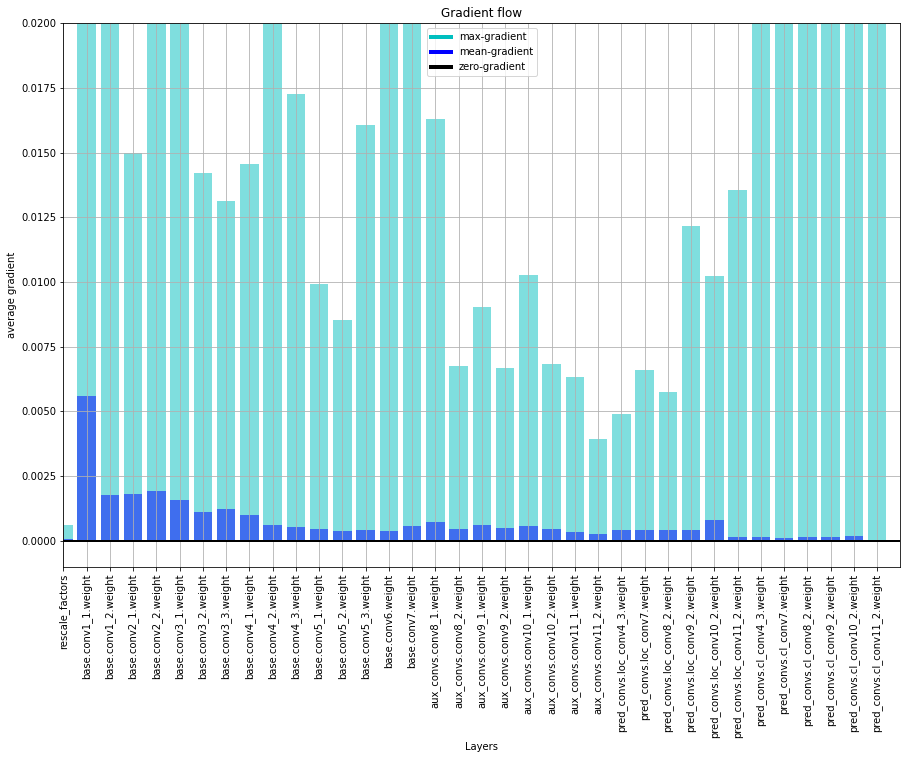

Epoch: [73][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.8622 (3.1229)	Loss_c 2.4720 (2.7317)	Loss_l 0.3902 (0.3912)	
Epoch: [73][2400/3697]	Batch Time 0.424 (0.423)	Data Time 0.000 (0.001)	Loss 3.0064 (3.1234)	Loss_c 2.6579 (2.7326)	Loss_l 0.3485 (0.3909)	
Epoch: [73][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9247 (3.1225)	Loss_c 2.6047 (2.7319)	Loss_l 0.3200 (0.3906)	
Epoch: [73][2800/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.2476 (3.1240)	Loss_c 2.8322 (2.7333)	Loss_l 0.4154 (0.3907)	
Epoch: [73][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2935 (3.1243)	Loss_c 2.9519 (2.7336)	Loss_l 0.3416 (0.3907)	


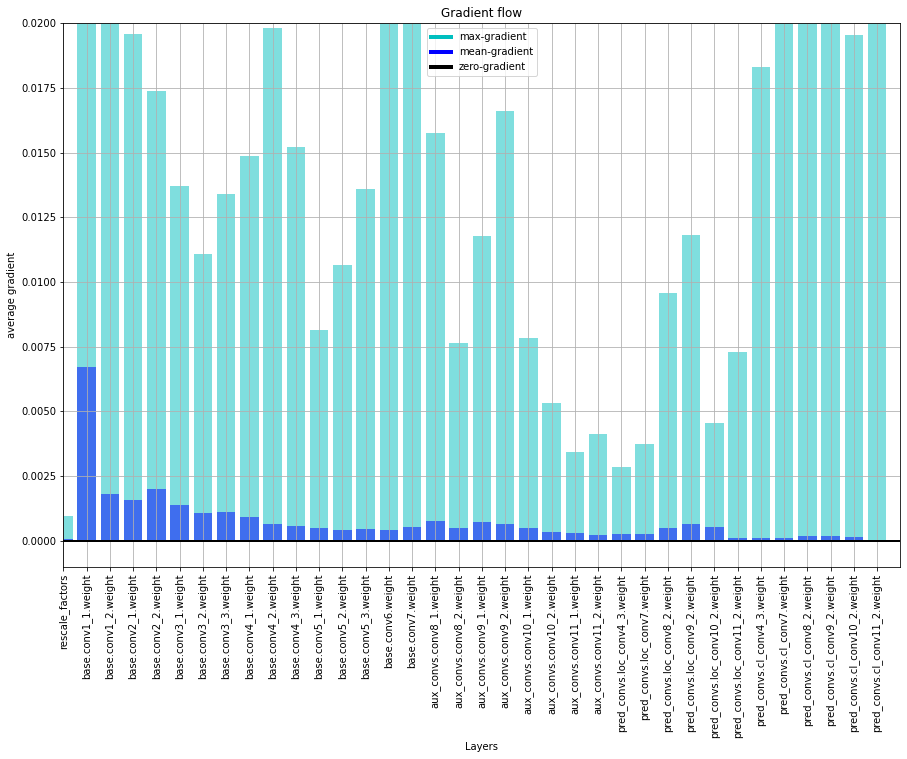

Epoch: [73][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1056 (3.1234)	Loss_c 2.7375 (2.7325)	Loss_l 0.3681 (0.3909)	
Epoch: [73][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9519 (3.1238)	Loss_c 2.6139 (2.7331)	Loss_l 0.3380 (0.3907)	
Epoch: [73][3600/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 3.2335 (3.1248)	Loss_c 2.8230 (2.7341)	Loss_l 0.4105 (0.3907)	
Epoch: [74][0/3697]	Batch Time 2.132 (2.132)	Data Time 1.677 (1.677)	Loss 3.3808 (3.3808)	Loss_c 2.9271 (2.9271)	Loss_l 0.4536 (0.4536)	


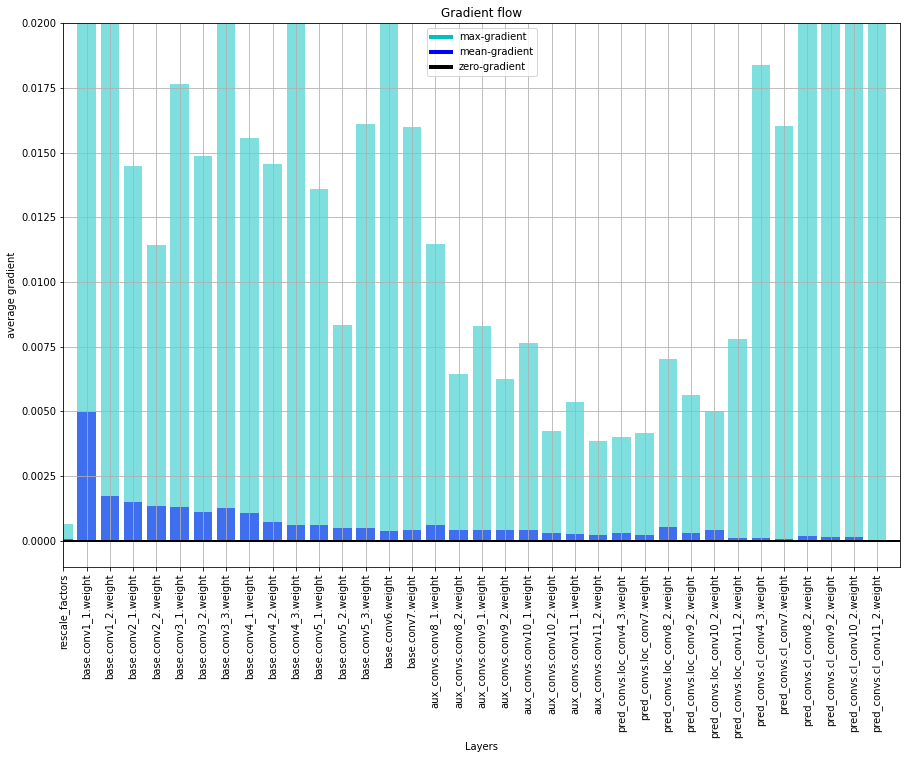

Epoch: [74][200/3697]	Batch Time 0.422 (0.434)	Data Time 0.000 (0.011)	Loss 3.4863 (3.1100)	Loss_c 3.1055 (2.7240)	Loss_l 0.3808 (0.3860)	
Epoch: [74][400/3697]	Batch Time 0.422 (0.428)	Data Time 0.000 (0.006)	Loss 2.9748 (3.1139)	Loss_c 2.5456 (2.7260)	Loss_l 0.4291 (0.3879)	
Epoch: [74][600/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.004)	Loss 3.0273 (3.1182)	Loss_c 2.6503 (2.7282)	Loss_l 0.3770 (0.3900)	
Epoch: [74][800/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 2.9692 (3.1232)	Loss_c 2.6185 (2.7323)	Loss_l 0.3507 (0.3909)	
Epoch: [74][1000/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.002)	Loss 3.4058 (3.1248)	Loss_c 3.0403 (2.7332)	Loss_l 0.3655 (0.3916)	


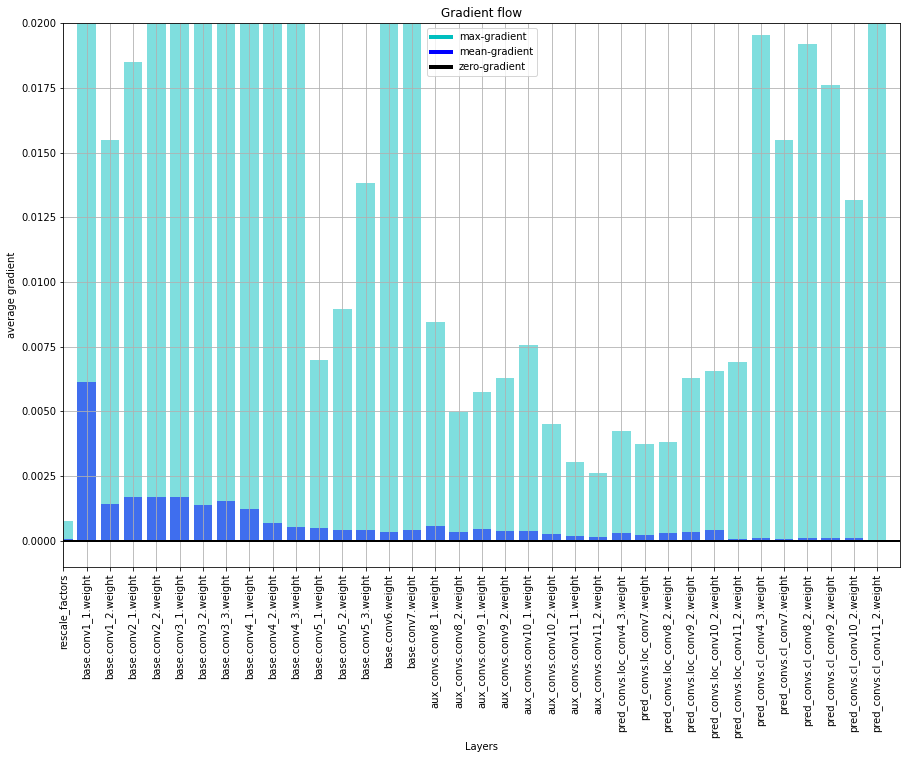

Epoch: [74][1200/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.002)	Loss 3.7163 (3.1239)	Loss_c 3.2400 (2.7330)	Loss_l 0.4764 (0.3909)	
Epoch: [74][1400/3697]	Batch Time 0.426 (0.424)	Data Time 0.000 (0.002)	Loss 3.0534 (3.1235)	Loss_c 2.6830 (2.7329)	Loss_l 0.3704 (0.3906)	
Epoch: [74][1600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.4823 (3.1238)	Loss_c 3.0338 (2.7332)	Loss_l 0.4485 (0.3905)	
Epoch: [74][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.4218 (3.1231)	Loss_c 3.0201 (2.7330)	Loss_l 0.4017 (0.3901)	
Epoch: [74][2000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.001)	Loss 3.1118 (3.1232)	Loss_c 2.7541 (2.7333)	Loss_l 0.3577 (0.3899)	


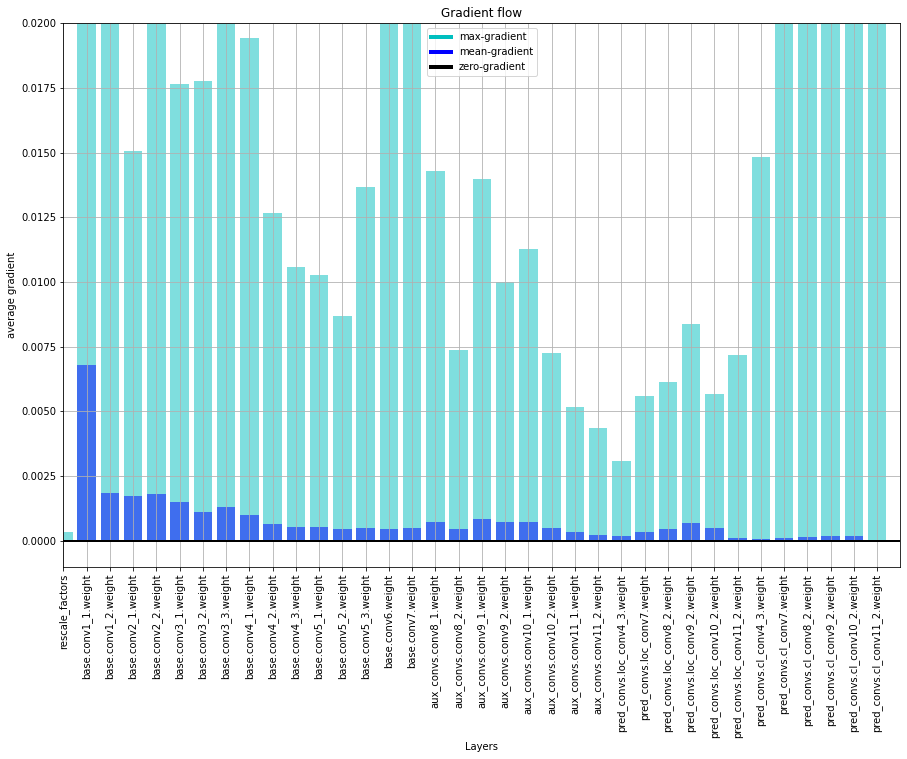

Epoch: [74][2200/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.001)	Loss 2.5962 (3.1233)	Loss_c 2.2504 (2.7331)	Loss_l 0.3458 (0.3902)	
Epoch: [74][2400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.4565 (3.1209)	Loss_c 3.0277 (2.7310)	Loss_l 0.4288 (0.3899)	
Epoch: [74][2600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3994 (3.1203)	Loss_c 2.9150 (2.7305)	Loss_l 0.4843 (0.3898)	
Epoch: [74][2800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0954 (3.1206)	Loss_c 2.7073 (2.7311)	Loss_l 0.3881 (0.3895)	
Epoch: [74][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0031 (3.1213)	Loss_c 2.5684 (2.7319)	Loss_l 0.4347 (0.3895)	


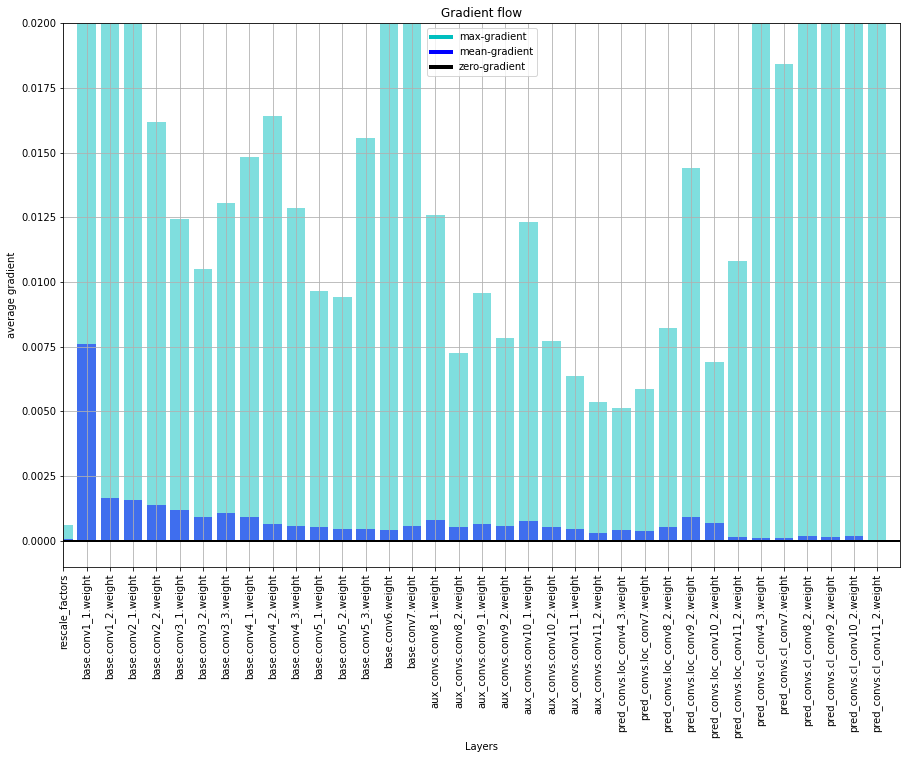

Epoch: [74][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2246 (3.1234)	Loss_c 2.8094 (2.7339)	Loss_l 0.4152 (0.3895)	
Epoch: [74][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4701 (3.1240)	Loss_c 3.0433 (2.7343)	Loss_l 0.4268 (0.3897)	
Epoch: [74][3600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.4808 (3.1243)	Loss_c 3.0437 (2.7344)	Loss_l 0.4371 (0.3899)	
Epoch: [75][0/3697]	Batch Time 2.016 (2.016)	Data Time 1.571 (1.571)	Loss 3.2326 (3.2326)	Loss_c 2.8424 (2.8424)	Loss_l 0.3903 (0.3903)	


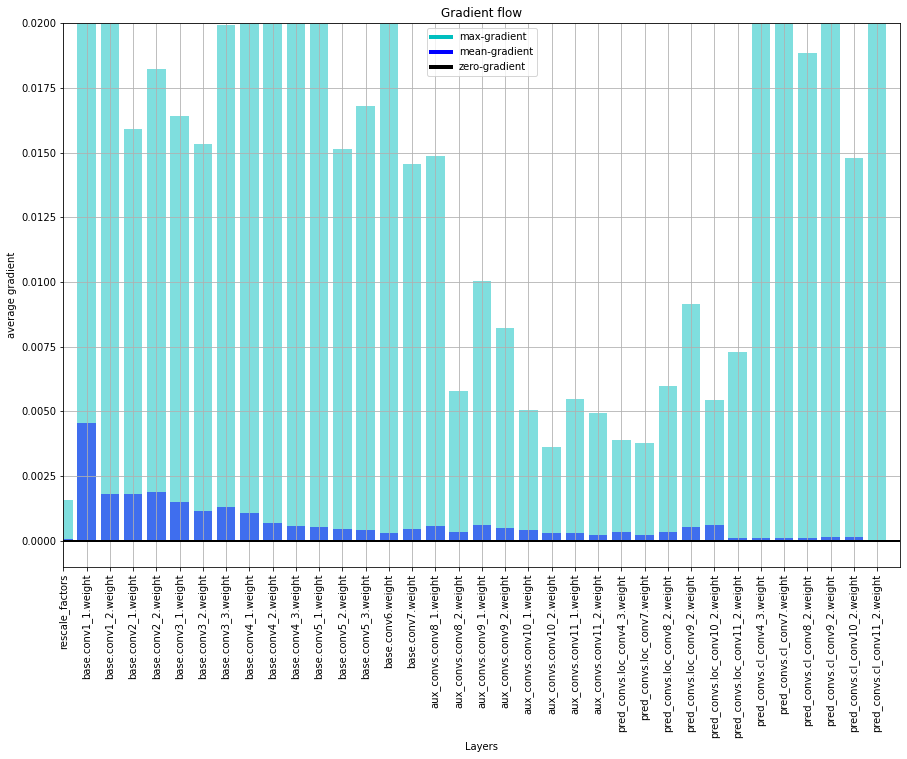

Epoch: [75][200/3697]	Batch Time 0.423 (0.432)	Data Time 0.000 (0.010)	Loss 2.9380 (3.1121)	Loss_c 2.5998 (2.7244)	Loss_l 0.3382 (0.3877)	
Epoch: [75][400/3697]	Batch Time 0.422 (0.428)	Data Time 0.000 (0.005)	Loss 3.2212 (3.1265)	Loss_c 2.8449 (2.7370)	Loss_l 0.3763 (0.3894)	
Epoch: [75][600/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.003)	Loss 2.6814 (3.1292)	Loss_c 2.3085 (2.7397)	Loss_l 0.3729 (0.3895)	
Epoch: [75][800/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.0635 (3.1309)	Loss_c 2.7372 (2.7409)	Loss_l 0.3263 (0.3900)	
Epoch: [75][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0855 (3.1325)	Loss_c 2.7138 (2.7415)	Loss_l 0.3717 (0.3910)	


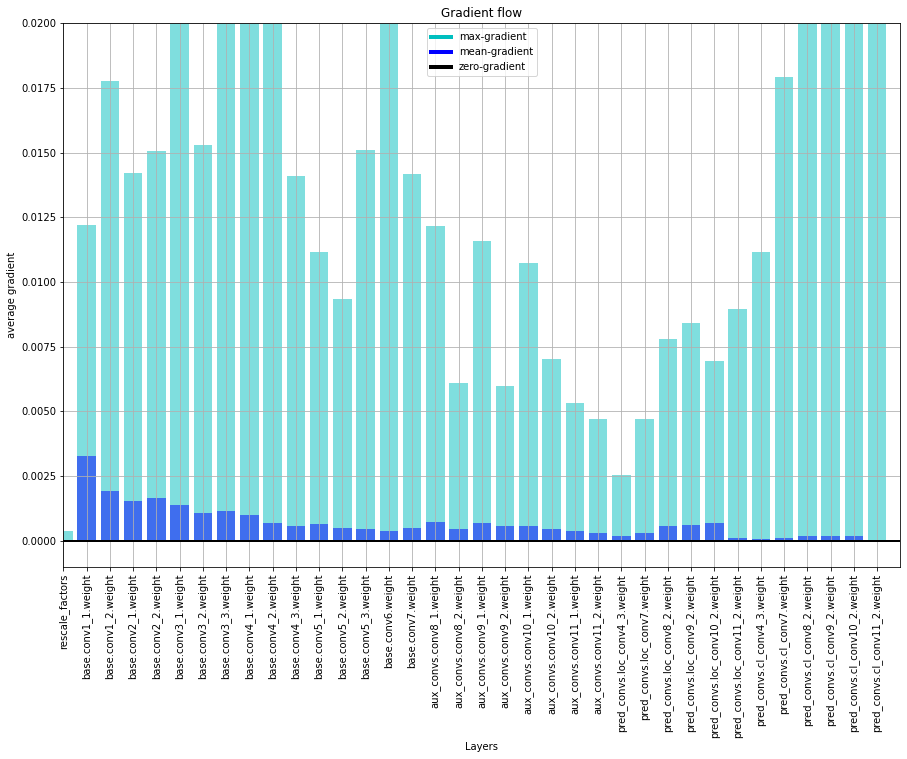

Epoch: [75][1200/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.2356 (3.1311)	Loss_c 2.8537 (2.7404)	Loss_l 0.3819 (0.3907)	
Epoch: [75][1400/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.002)	Loss 3.1911 (3.1299)	Loss_c 2.7311 (2.7391)	Loss_l 0.4599 (0.3908)	
Epoch: [75][1600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.2233 (3.1325)	Loss_c 2.8033 (2.7410)	Loss_l 0.4200 (0.3915)	
Epoch: [75][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.2495 (3.1334)	Loss_c 2.8819 (2.7412)	Loss_l 0.3677 (0.3921)	
Epoch: [75][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2112 (3.1337)	Loss_c 2.8434 (2.7416)	Loss_l 0.3678 (0.3920)	


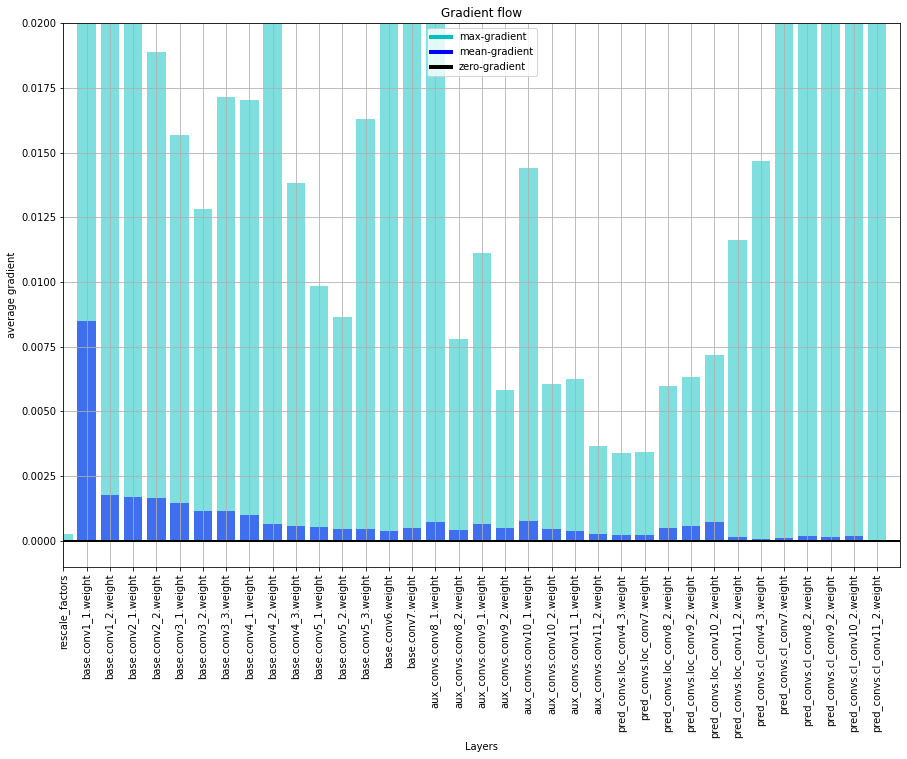

Epoch: [75][2200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0698 (3.1298)	Loss_c 2.7093 (2.7384)	Loss_l 0.3605 (0.3914)	
Epoch: [75][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2594 (3.1288)	Loss_c 2.8118 (2.7376)	Loss_l 0.4476 (0.3912)	
Epoch: [75][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2171 (3.1297)	Loss_c 2.7806 (2.7383)	Loss_l 0.4364 (0.3914)	
Epoch: [75][2800/3697]	Batch Time 0.430 (0.423)	Data Time 0.000 (0.001)	Loss 3.0422 (3.1302)	Loss_c 2.6552 (2.7385)	Loss_l 0.3870 (0.3917)	
Epoch: [75][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.3170 (3.1316)	Loss_c 2.8644 (2.7394)	Loss_l 0.4525 (0.3922)	


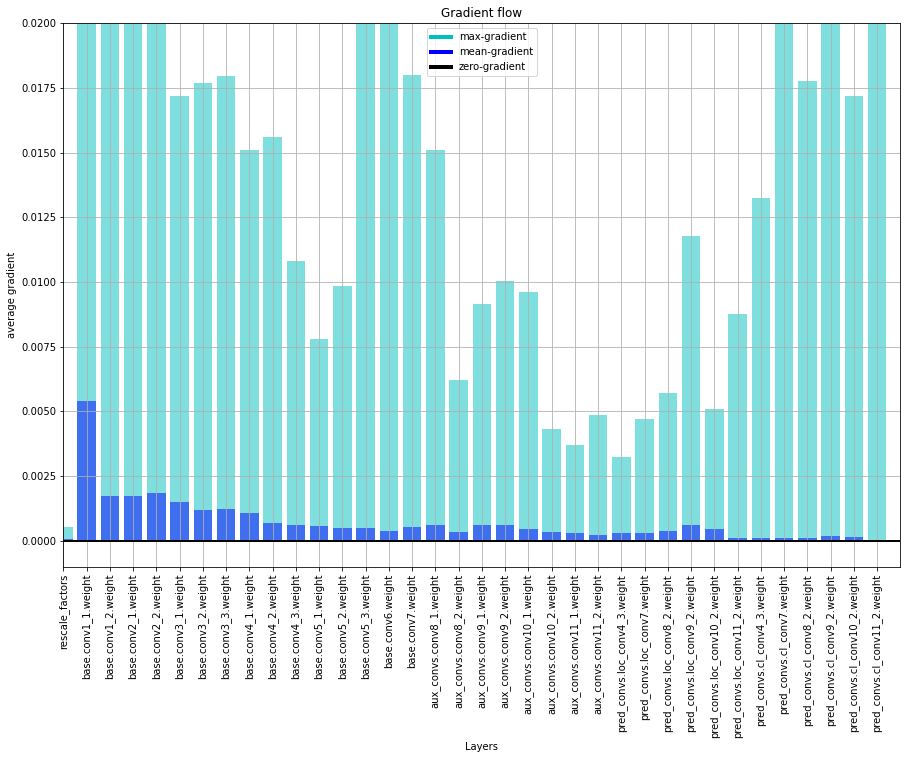

Epoch: [75][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9310 (3.1318)	Loss_c 2.5348 (2.7396)	Loss_l 0.3962 (0.3922)	
Epoch: [75][3400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0698 (3.1310)	Loss_c 2.7128 (2.7389)	Loss_l 0.3569 (0.3921)	
Epoch: [75][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1858 (3.1312)	Loss_c 2.8052 (2.7392)	Loss_l 0.3805 (0.3921)	
Epoch: [76][0/3697]	Batch Time 1.546 (1.546)	Data Time 1.118 (1.118)	Loss 3.1816 (3.1816)	Loss_c 2.8264 (2.8264)	Loss_l 0.3552 (0.3552)	


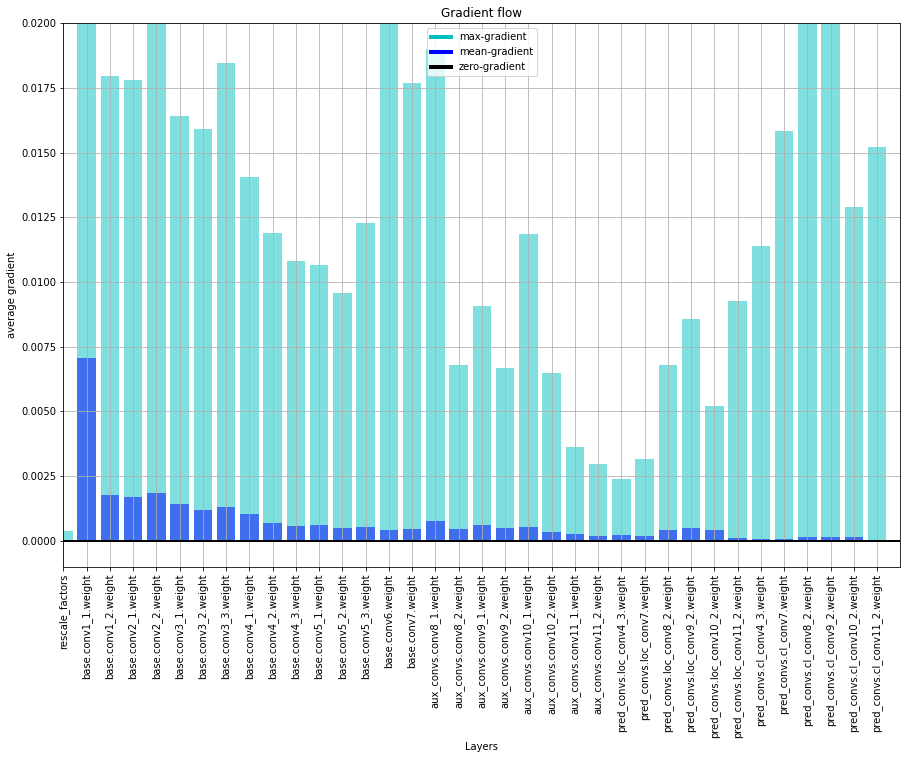

Epoch: [76][200/3697]	Batch Time 0.427 (0.430)	Data Time 0.000 (0.008)	Loss 3.5015 (3.1305)	Loss_c 3.0060 (2.7407)	Loss_l 0.4954 (0.3897)	
Epoch: [76][400/3697]	Batch Time 0.425 (0.426)	Data Time 0.000 (0.004)	Loss 3.0967 (3.1192)	Loss_c 2.7789 (2.7309)	Loss_l 0.3177 (0.3883)	
Epoch: [76][600/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 2.9981 (3.1195)	Loss_c 2.6278 (2.7314)	Loss_l 0.3703 (0.3880)	
Epoch: [76][800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.5547 (3.1195)	Loss_c 3.1886 (2.7310)	Loss_l 0.3661 (0.3885)	
Epoch: [76][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1545 (3.1229)	Loss_c 2.7672 (2.7327)	Loss_l 0.3873 (0.3901)	


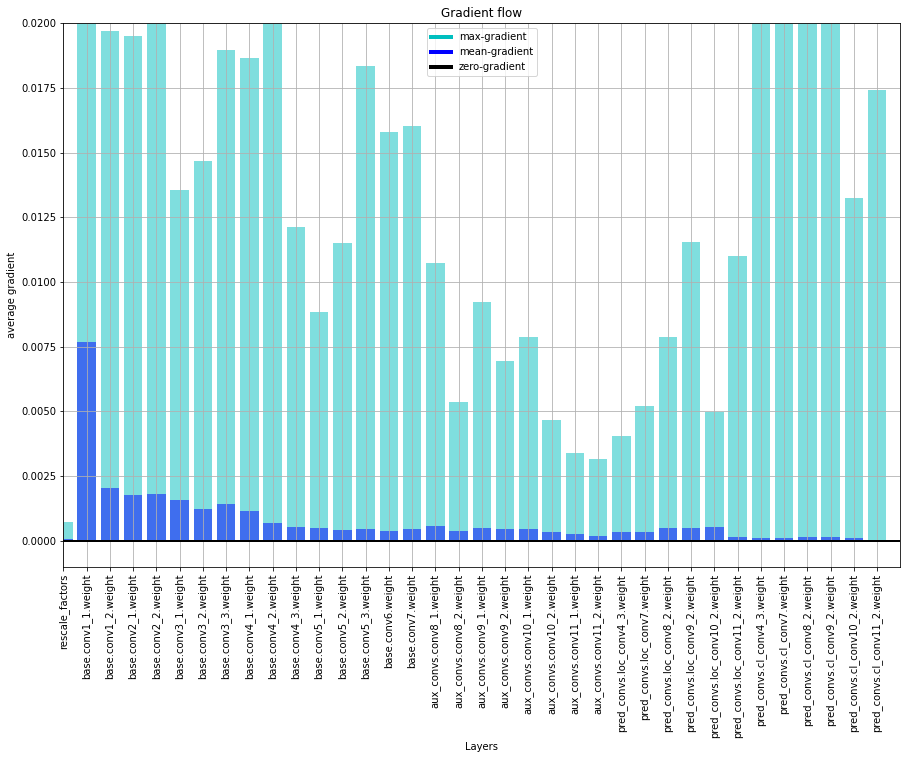

Epoch: [76][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.0869 (3.1250)	Loss_c 2.7166 (2.7338)	Loss_l 0.3704 (0.3912)	
Epoch: [76][1400/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.002)	Loss 3.1563 (3.1269)	Loss_c 2.6761 (2.7352)	Loss_l 0.4803 (0.3917)	
Epoch: [76][1600/3697]	Batch Time 0.433 (0.423)	Data Time 0.000 (0.001)	Loss 3.1599 (3.1280)	Loss_c 2.7444 (2.7365)	Loss_l 0.4155 (0.3915)	
Epoch: [76][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.5937 (3.1285)	Loss_c 3.0907 (2.7372)	Loss_l 0.5030 (0.3912)	
Epoch: [76][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3176 (3.1283)	Loss_c 2.8432 (2.7370)	Loss_l 0.4744 (0.3914)	


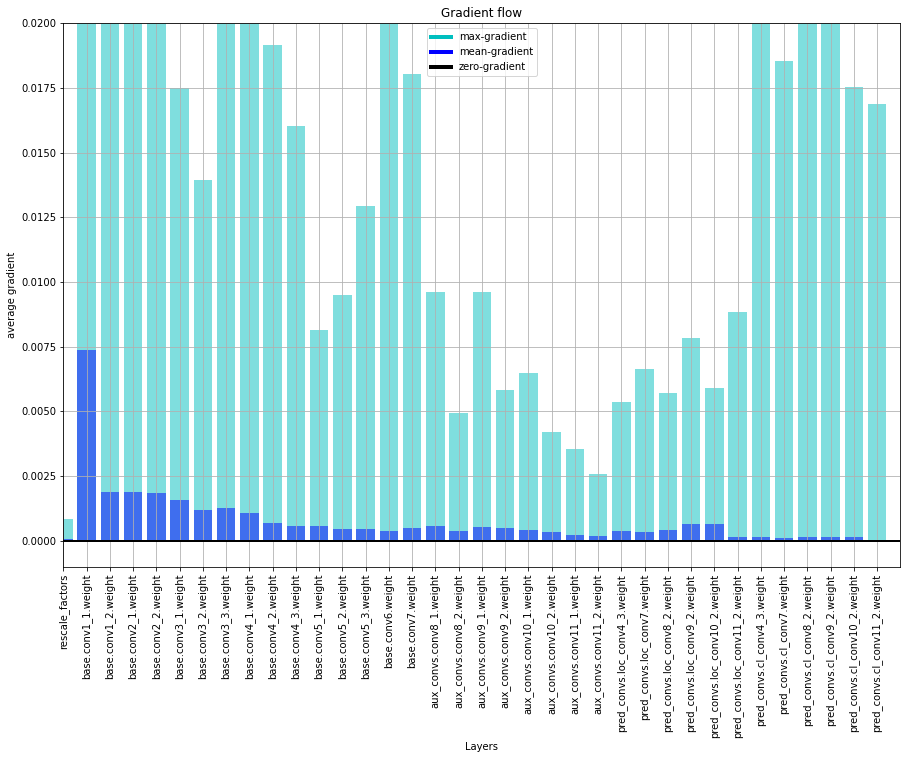

Epoch: [76][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2821 (3.1263)	Loss_c 2.8562 (2.7352)	Loss_l 0.4259 (0.3910)	
Epoch: [76][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4342 (3.1272)	Loss_c 3.0464 (2.7362)	Loss_l 0.3878 (0.3910)	
Epoch: [76][2600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.3199 (3.1280)	Loss_c 2.8618 (2.7364)	Loss_l 0.4581 (0.3915)	
Epoch: [76][2800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2286 (3.1273)	Loss_c 2.8266 (2.7360)	Loss_l 0.4021 (0.3913)	
Epoch: [76][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1596 (3.1270)	Loss_c 2.7565 (2.7359)	Loss_l 0.4032 (0.3911)	


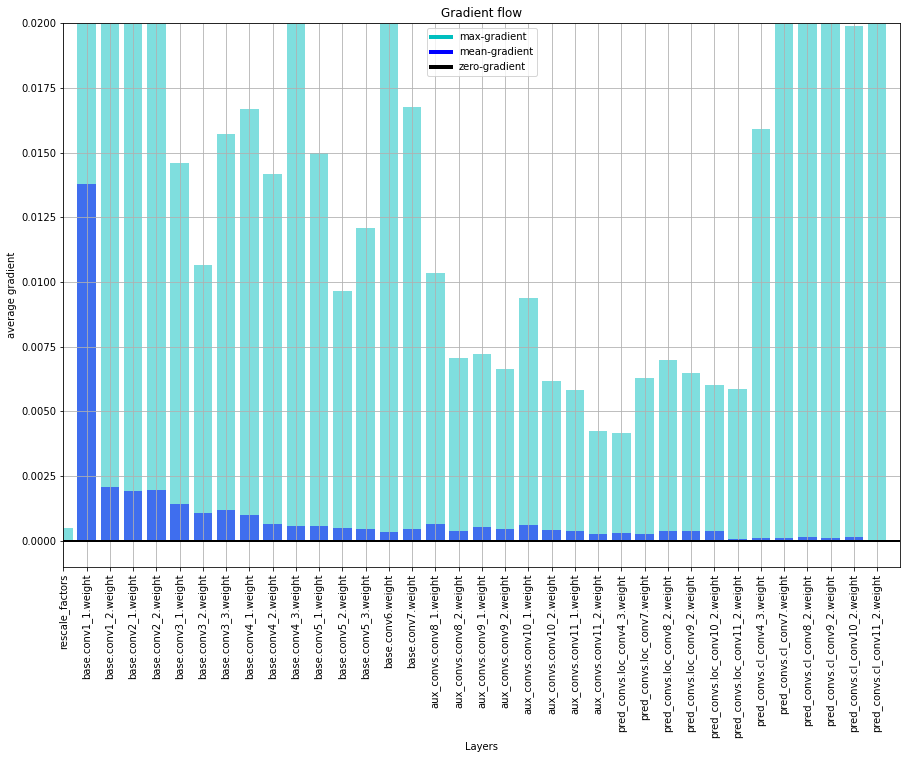

Epoch: [76][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1473 (3.1264)	Loss_c 2.7336 (2.7355)	Loss_l 0.4136 (0.3909)	
Epoch: [76][3400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2748 (3.1261)	Loss_c 2.8502 (2.7354)	Loss_l 0.4245 (0.3907)	
Epoch: [76][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.5077 (3.1272)	Loss_c 3.0470 (2.7361)	Loss_l 0.4607 (0.3911)	
Epoch: [77][0/3697]	Batch Time 1.701 (1.701)	Data Time 1.266 (1.266)	Loss 3.1028 (3.1028)	Loss_c 2.6781 (2.6781)	Loss_l 0.4247 (0.4247)	


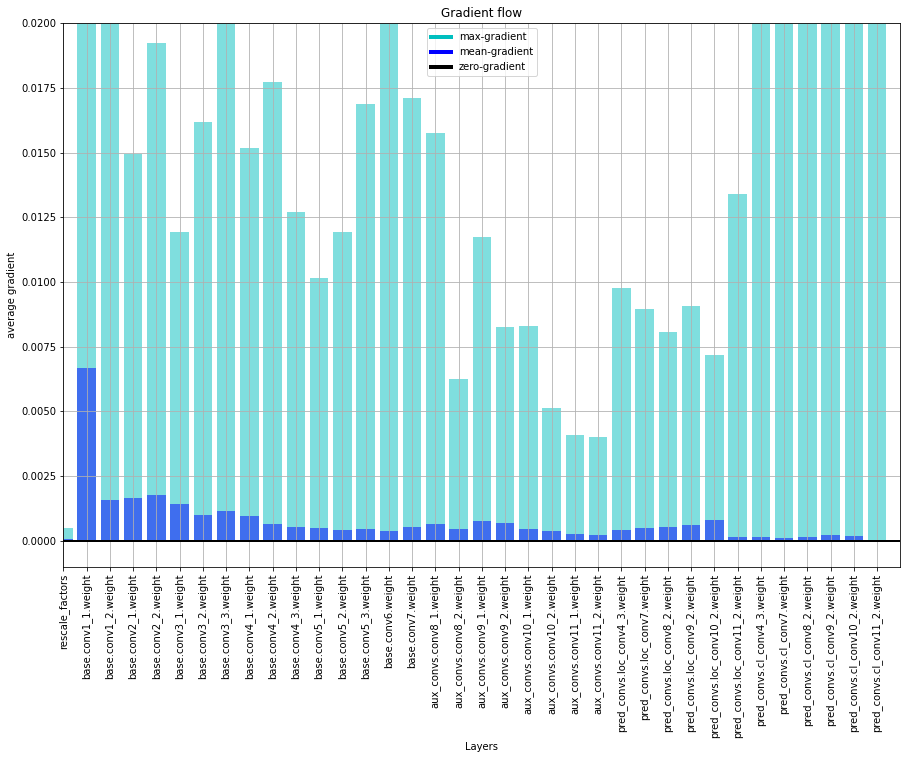

Epoch: [77][200/3697]	Batch Time 0.428 (0.431)	Data Time 0.000 (0.009)	Loss 3.4582 (3.1161)	Loss_c 3.0105 (2.7269)	Loss_l 0.4477 (0.3893)	
Epoch: [77][400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.004)	Loss 2.9971 (3.1229)	Loss_c 2.6124 (2.7332)	Loss_l 0.3847 (0.3897)	
Epoch: [77][600/3697]	Batch Time 0.422 (0.426)	Data Time 0.000 (0.003)	Loss 2.9111 (3.1287)	Loss_c 2.5673 (2.7385)	Loss_l 0.3438 (0.3902)	
Epoch: [77][800/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.002)	Loss 2.9297 (3.1250)	Loss_c 2.5074 (2.7352)	Loss_l 0.4223 (0.3898)	
Epoch: [77][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.7282 (3.1229)	Loss_c 2.4059 (2.7341)	Loss_l 0.3222 (0.3888)	


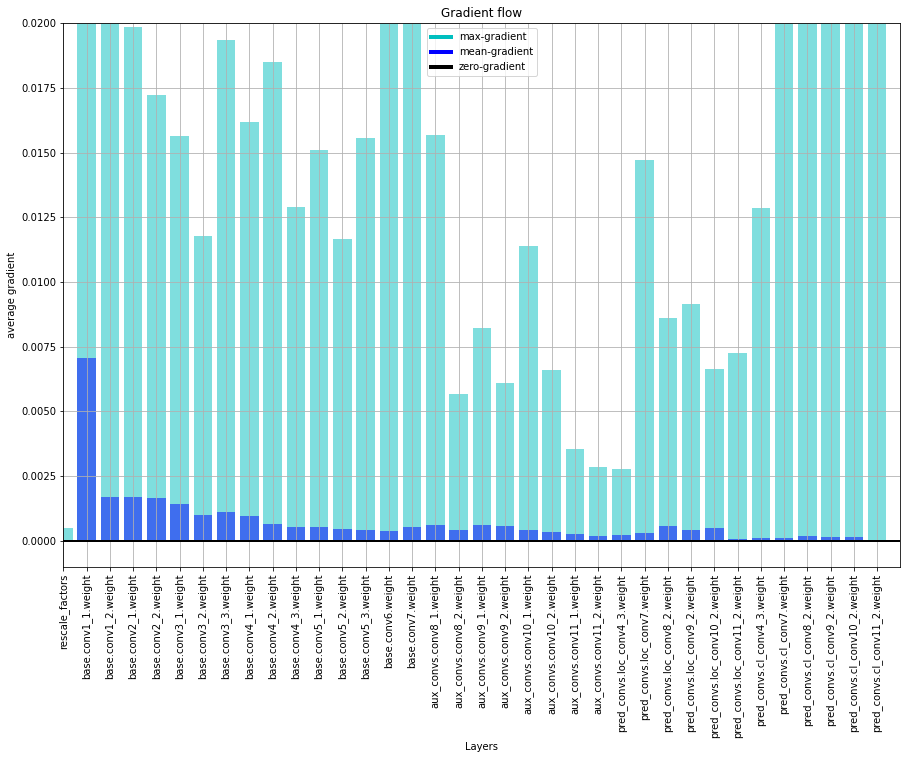

Epoch: [77][1200/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.002)	Loss 2.8141 (3.1223)	Loss_c 2.5305 (2.7336)	Loss_l 0.2836 (0.3887)	
Epoch: [77][1400/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.1880 (3.1221)	Loss_c 2.8085 (2.7331)	Loss_l 0.3796 (0.3891)	
Epoch: [77][1600/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.001)	Loss 3.0586 (3.1243)	Loss_c 2.6513 (2.7345)	Loss_l 0.4073 (0.3898)	
Epoch: [77][1800/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 3.2329 (3.1238)	Loss_c 2.8893 (2.7338)	Loss_l 0.3436 (0.3900)	
Epoch: [77][2000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3126 (3.1224)	Loss_c 2.8801 (2.7326)	Loss_l 0.4324 (0.3899)	


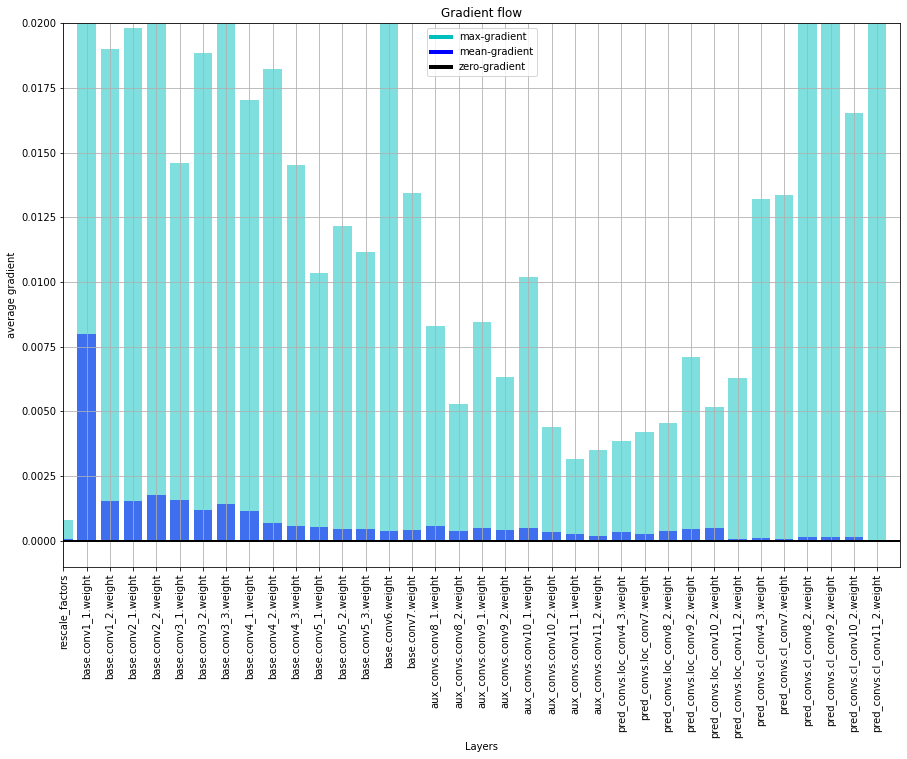

Epoch: [77][2200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.9931 (3.1233)	Loss_c 2.6202 (2.7331)	Loss_l 0.3728 (0.3902)	
Epoch: [77][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2032 (3.1249)	Loss_c 2.8219 (2.7347)	Loss_l 0.3812 (0.3902)	
Epoch: [77][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1764 (3.1244)	Loss_c 2.7866 (2.7343)	Loss_l 0.3898 (0.3902)	
Epoch: [77][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9513 (3.1231)	Loss_c 2.6036 (2.7329)	Loss_l 0.3477 (0.3901)	
Epoch: [77][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0451 (3.1241)	Loss_c 2.6395 (2.7335)	Loss_l 0.4057 (0.3906)	


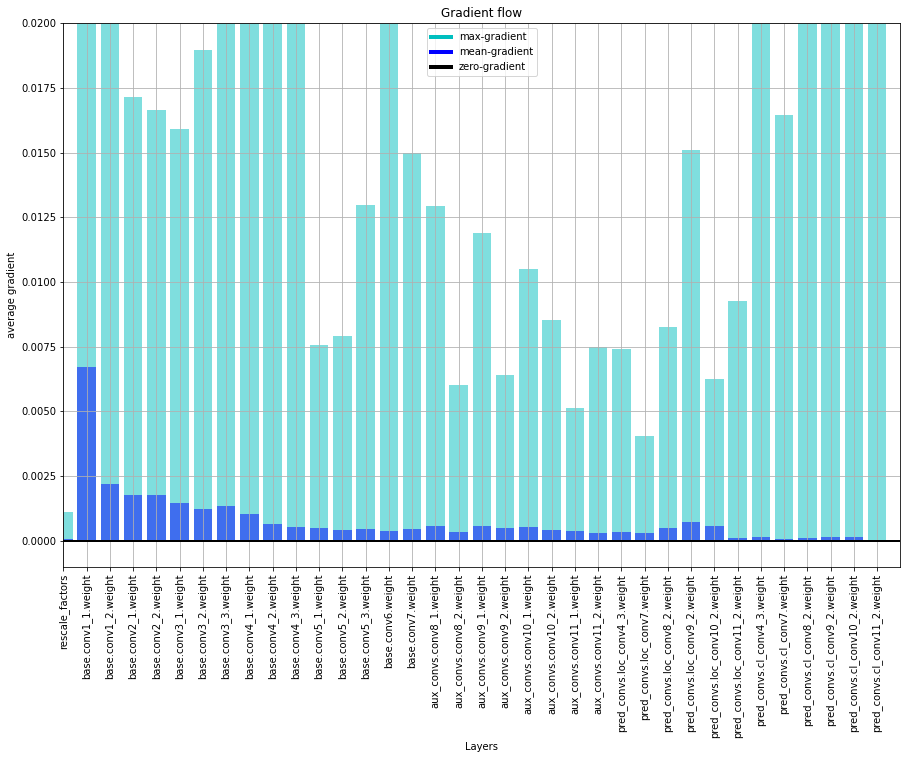

Epoch: [77][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1447 (3.1239)	Loss_c 2.6370 (2.7333)	Loss_l 0.5077 (0.3906)	
Epoch: [77][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2250 (3.1240)	Loss_c 2.8293 (2.7338)	Loss_l 0.3957 (0.3903)	
Epoch: [77][3600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.8792 (3.1231)	Loss_c 2.5430 (2.7329)	Loss_l 0.3363 (0.3901)	
Epoch: [78][0/3697]	Batch Time 2.028 (2.028)	Data Time 1.589 (1.589)	Loss 3.1475 (3.1475)	Loss_c 2.7463 (2.7463)	Loss_l 0.4011 (0.4011)	


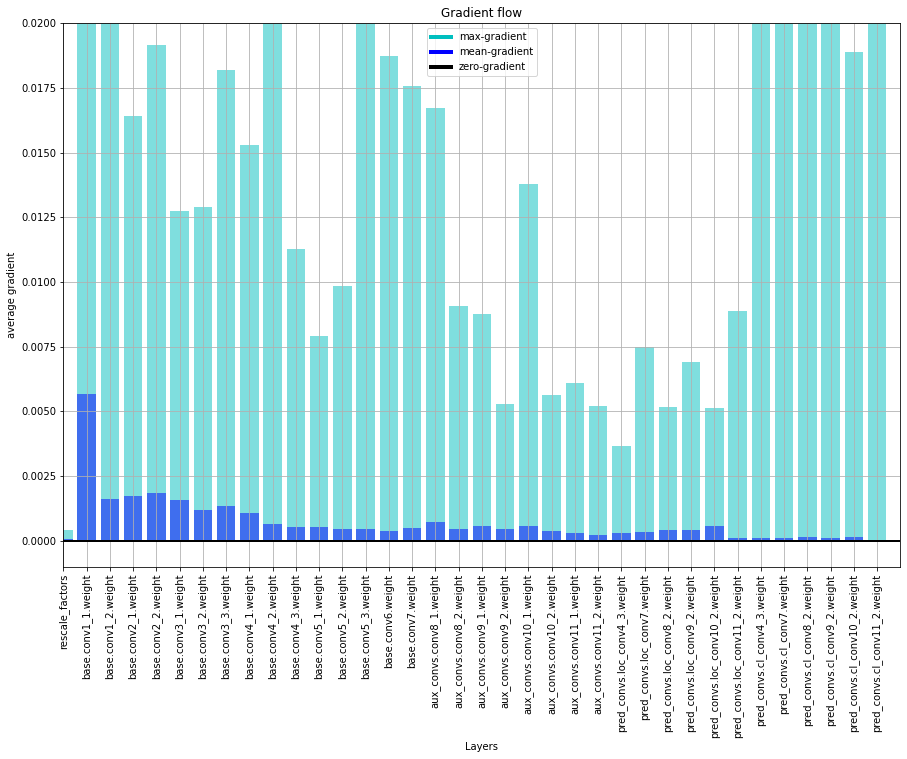

Epoch: [78][200/3697]	Batch Time 0.422 (0.432)	Data Time 0.000 (0.010)	Loss 3.1508 (3.1246)	Loss_c 2.7369 (2.7363)	Loss_l 0.4139 (0.3883)	
Epoch: [78][400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.005)	Loss 3.1812 (3.1298)	Loss_c 2.8013 (2.7404)	Loss_l 0.3800 (0.3893)	
Epoch: [78][600/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.0711 (3.1236)	Loss_c 2.5815 (2.7339)	Loss_l 0.4896 (0.3897)	
Epoch: [78][800/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 2.9723 (3.1242)	Loss_c 2.5725 (2.7337)	Loss_l 0.3999 (0.3905)	
Epoch: [78][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.9546 (3.1253)	Loss_c 2.5985 (2.7355)	Loss_l 0.3561 (0.3897)	


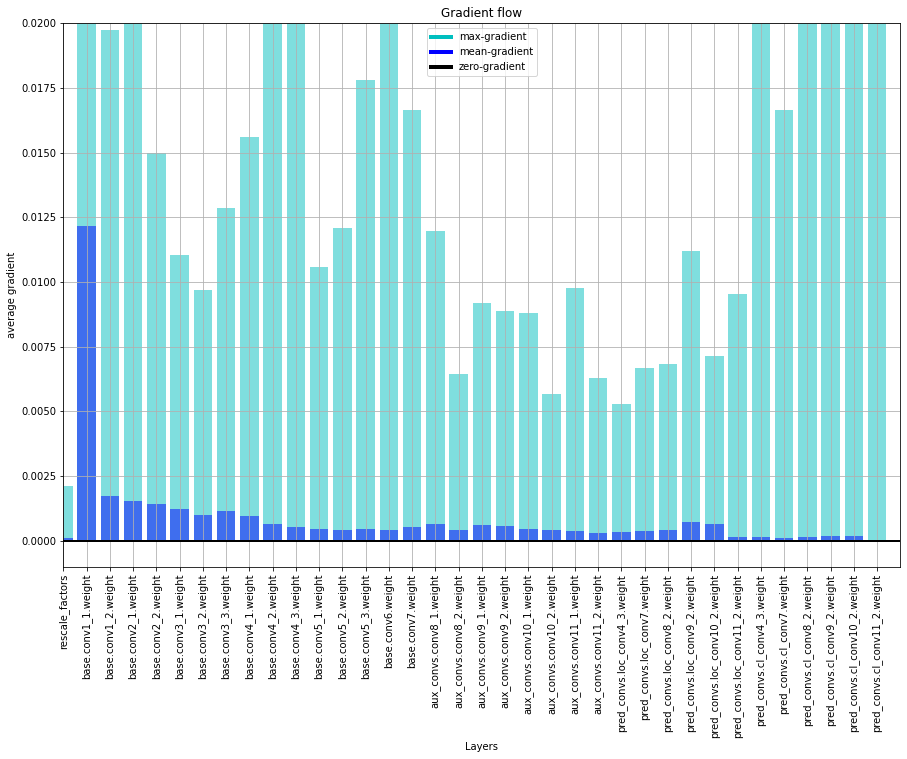

Epoch: [78][1200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1561 (3.1210)	Loss_c 2.7813 (2.7317)	Loss_l 0.3749 (0.3893)	
Epoch: [78][1400/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.0988 (3.1209)	Loss_c 2.7240 (2.7313)	Loss_l 0.3747 (0.3896)	
Epoch: [78][1600/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.1213 (3.1200)	Loss_c 2.7437 (2.7311)	Loss_l 0.3776 (0.3889)	
Epoch: [78][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.8997 (3.1236)	Loss_c 2.6014 (2.7343)	Loss_l 0.2983 (0.3893)	
Epoch: [78][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.6872 (3.1237)	Loss_c 2.3622 (2.7337)	Loss_l 0.3249 (0.3899)	


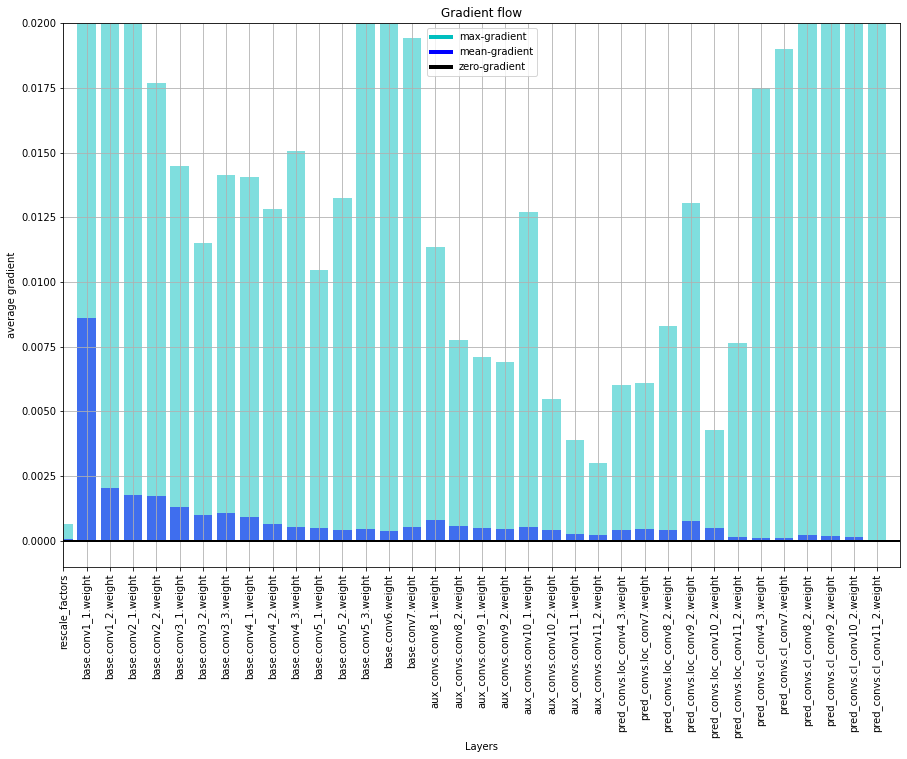

Epoch: [78][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4354 (3.1239)	Loss_c 2.9746 (2.7340)	Loss_l 0.4607 (0.3900)	
Epoch: [78][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4909 (3.1246)	Loss_c 3.0558 (2.7343)	Loss_l 0.4351 (0.3903)	
Epoch: [78][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3830 (3.1250)	Loss_c 2.9517 (2.7346)	Loss_l 0.4312 (0.3903)	
Epoch: [78][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.5964 (3.1251)	Loss_c 3.1397 (2.7348)	Loss_l 0.4567 (0.3902)	
Epoch: [78][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2103 (3.1249)	Loss_c 2.8361 (2.7346)	Loss_l 0.3742 (0.3903)	


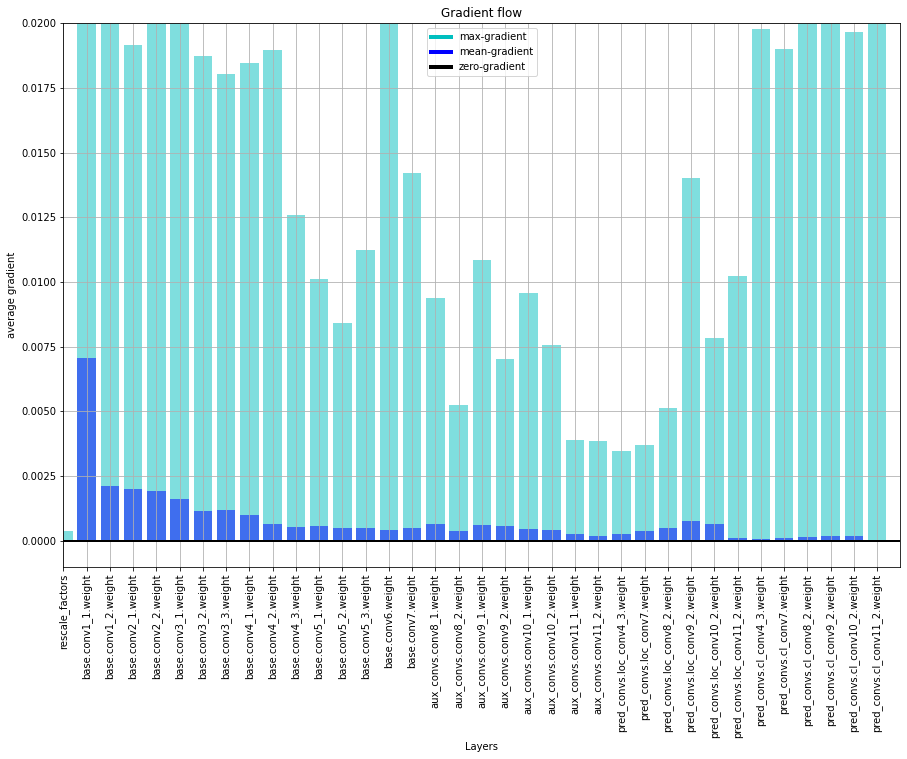

Epoch: [78][3200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.4787 (3.1260)	Loss_c 2.9802 (2.7357)	Loss_l 0.4985 (0.3904)	
Epoch: [78][3400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9705 (3.1255)	Loss_c 2.5944 (2.7353)	Loss_l 0.3762 (0.3902)	
Epoch: [78][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0175 (3.1255)	Loss_c 2.6465 (2.7353)	Loss_l 0.3710 (0.3902)	
Epoch: [79][0/3697]	Batch Time 1.844 (1.844)	Data Time 1.410 (1.410)	Loss 3.1093 (3.1093)	Loss_c 2.7405 (2.7405)	Loss_l 0.3688 (0.3688)	


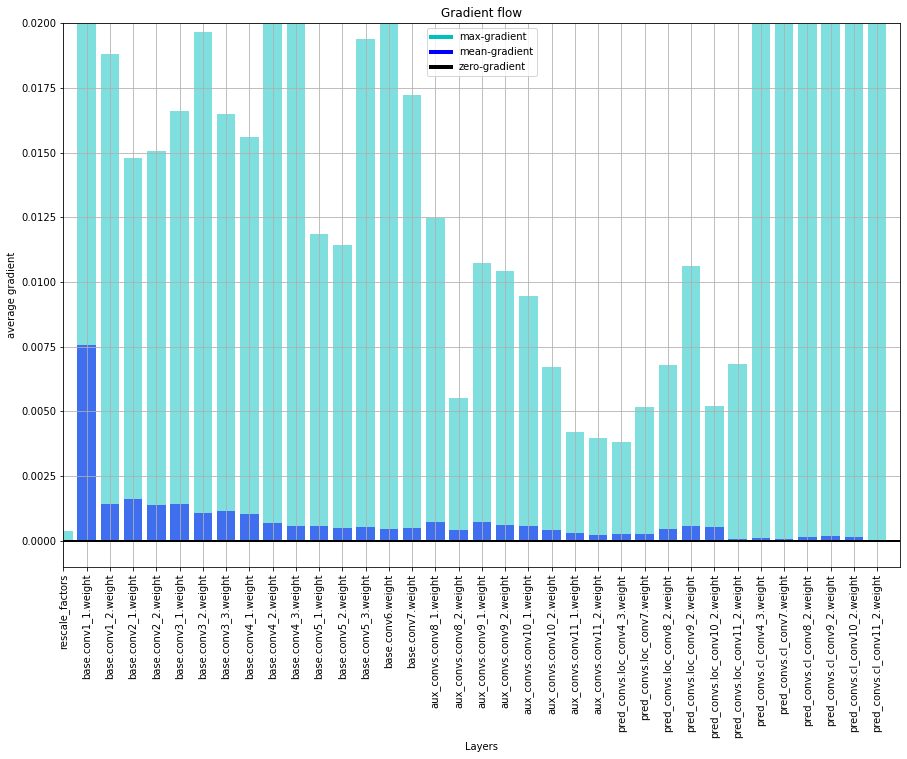

Epoch: [79][200/3697]	Batch Time 0.422 (0.431)	Data Time 0.000 (0.009)	Loss 3.2986 (3.1242)	Loss_c 2.9459 (2.7355)	Loss_l 0.3527 (0.3888)	
Epoch: [79][400/3697]	Batch Time 0.428 (0.427)	Data Time 0.000 (0.005)	Loss 3.0554 (3.1262)	Loss_c 2.5987 (2.7369)	Loss_l 0.4567 (0.3893)	
Epoch: [79][600/3697]	Batch Time 0.419 (0.425)	Data Time 0.000 (0.003)	Loss 3.3972 (3.1220)	Loss_c 2.9762 (2.7335)	Loss_l 0.4211 (0.3885)	
Epoch: [79][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.8450 (3.1171)	Loss_c 2.4768 (2.7282)	Loss_l 0.3682 (0.3890)	
Epoch: [79][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.9213 (3.1165)	Loss_c 2.6083 (2.7282)	Loss_l 0.3130 (0.3883)	


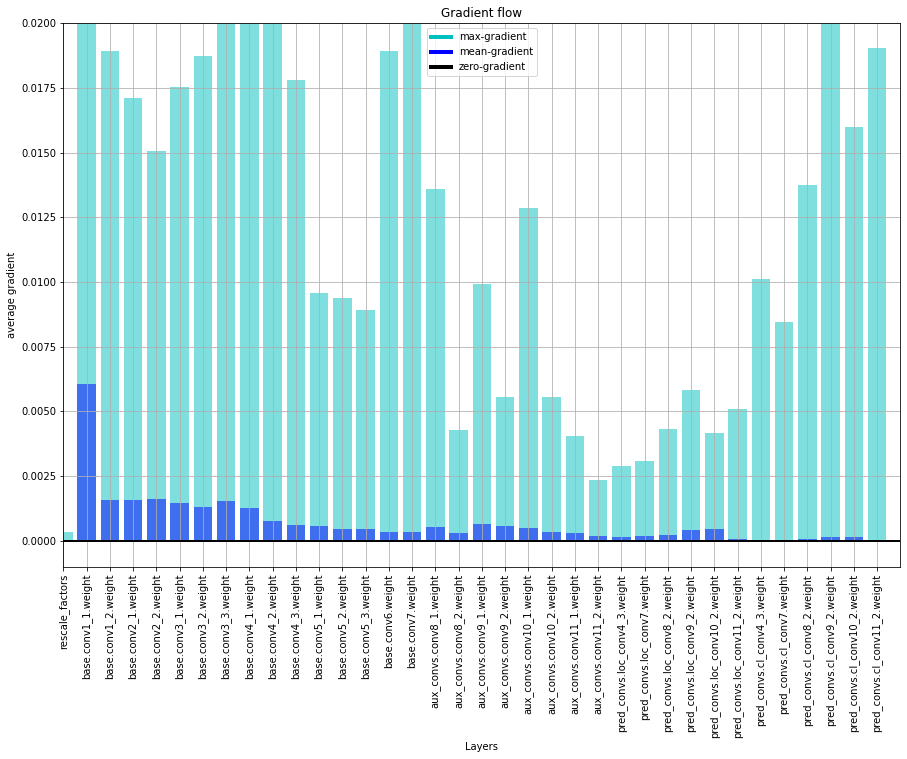

Epoch: [79][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.0458 (3.1158)	Loss_c 2.6854 (2.7267)	Loss_l 0.3605 (0.3891)	
Epoch: [79][1400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.002)	Loss 2.7975 (3.1174)	Loss_c 2.4587 (2.7282)	Loss_l 0.3388 (0.3892)	
Epoch: [79][1600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.2485 (3.1173)	Loss_c 2.8553 (2.7281)	Loss_l 0.3932 (0.3892)	
Epoch: [79][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1421 (3.1165)	Loss_c 2.7675 (2.7274)	Loss_l 0.3746 (0.3891)	
Epoch: [79][2000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.0488 (3.1202)	Loss_c 2.6106 (2.7302)	Loss_l 0.4382 (0.3900)	


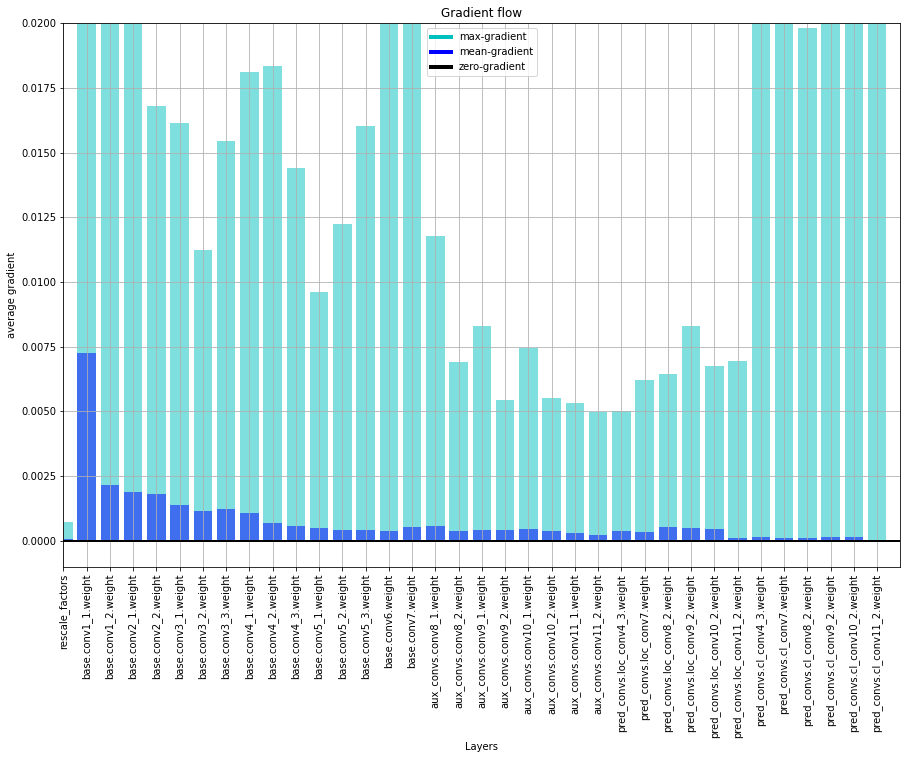

Epoch: [79][2200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.2088 (3.1205)	Loss_c 2.8019 (2.7305)	Loss_l 0.4070 (0.3900)	
Epoch: [79][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1704 (3.1209)	Loss_c 2.7116 (2.7309)	Loss_l 0.4587 (0.3901)	
Epoch: [79][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0753 (3.1218)	Loss_c 2.6485 (2.7316)	Loss_l 0.4267 (0.3902)	
Epoch: [79][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9206 (3.1241)	Loss_c 2.5653 (2.7333)	Loss_l 0.3554 (0.3908)	
Epoch: [79][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.5097 (3.1245)	Loss_c 2.9850 (2.7338)	Loss_l 0.5247 (0.3907)	


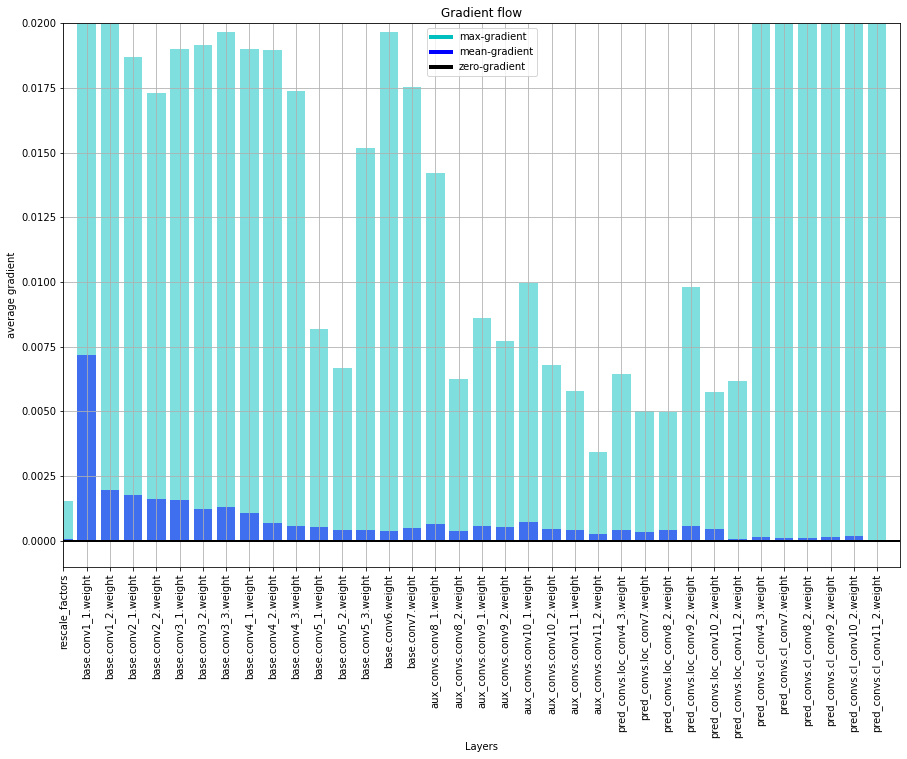

Epoch: [79][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0278 (3.1239)	Loss_c 2.6740 (2.7332)	Loss_l 0.3538 (0.3907)	
Epoch: [79][3400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.8812 (3.1235)	Loss_c 2.4828 (2.7328)	Loss_l 0.3984 (0.3907)	
Epoch: [79][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.3615 (3.1245)	Loss_c 2.9627 (2.7336)	Loss_l 0.3989 (0.3909)	
Epoch: [80][0/3697]	Batch Time 1.597 (1.597)	Data Time 1.174 (1.174)	Loss 3.0018 (3.0018)	Loss_c 2.6432 (2.6432)	Loss_l 0.3586 (0.3586)	


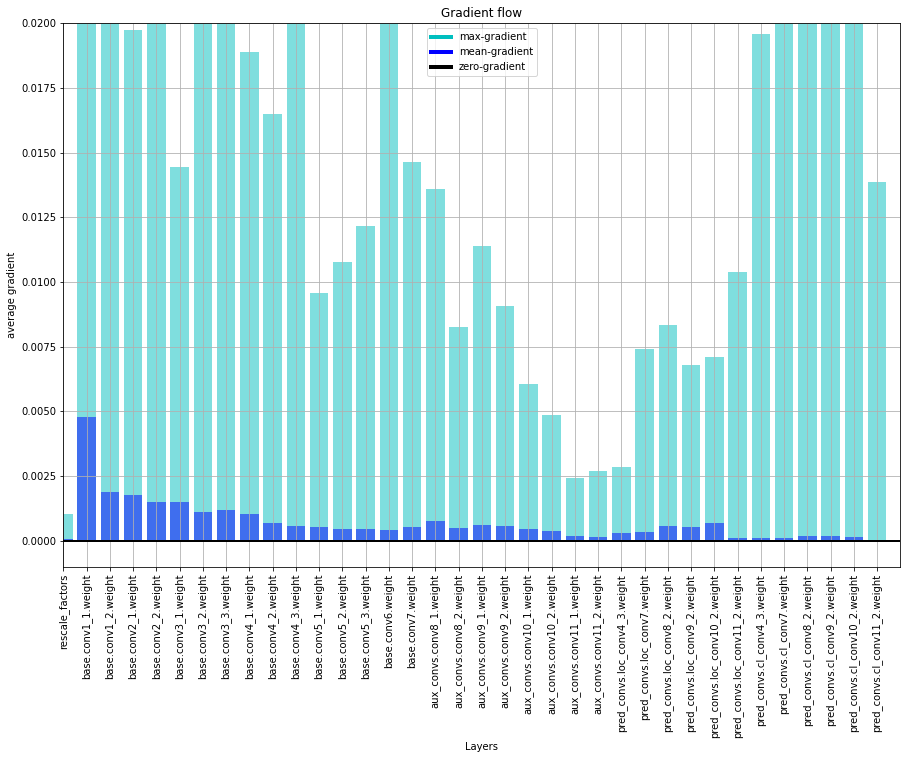

Epoch: [80][200/3697]	Batch Time 0.422 (0.430)	Data Time 0.000 (0.008)	Loss 3.1036 (3.1160)	Loss_c 2.7686 (2.7273)	Loss_l 0.3350 (0.3886)	
Epoch: [80][400/3697]	Batch Time 0.420 (0.426)	Data Time 0.000 (0.004)	Loss 3.2986 (3.1169)	Loss_c 2.8798 (2.7282)	Loss_l 0.4188 (0.3887)	
Epoch: [80][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.1021 (3.1151)	Loss_c 2.7505 (2.7282)	Loss_l 0.3515 (0.3870)	
Epoch: [80][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.9264 (3.1169)	Loss_c 2.5615 (2.7298)	Loss_l 0.3650 (0.3872)	
Epoch: [80][1000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.2330 (3.1255)	Loss_c 2.8248 (2.7365)	Loss_l 0.4081 (0.3890)	


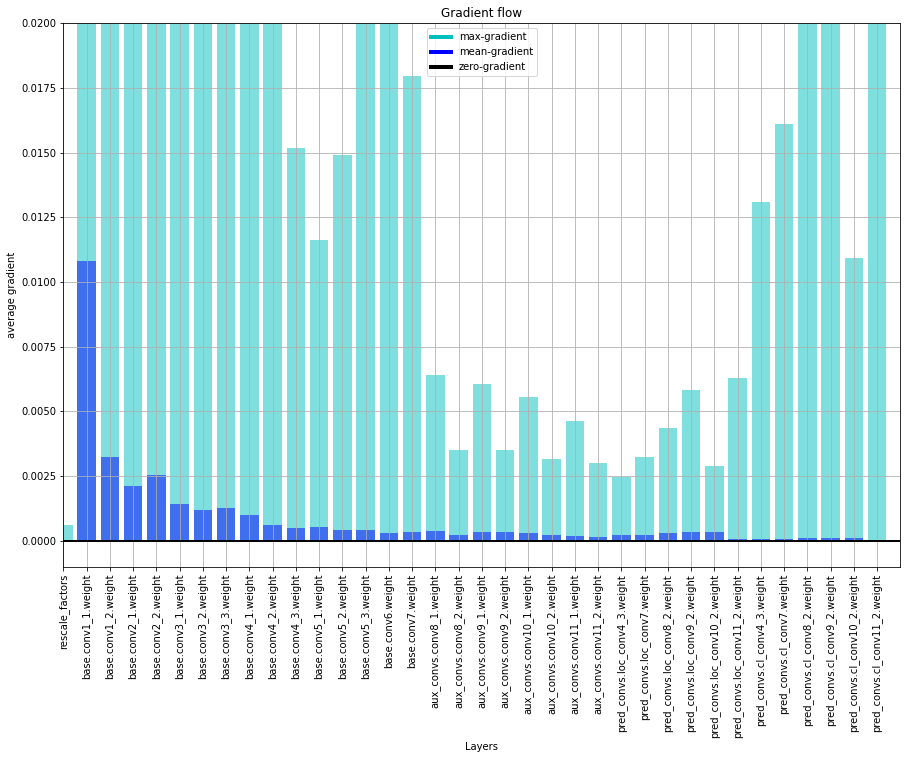

Epoch: [80][1200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.0063 (3.1268)	Loss_c 2.6394 (2.7366)	Loss_l 0.3669 (0.3901)	
Epoch: [80][1400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.002)	Loss 3.0520 (3.1308)	Loss_c 2.6231 (2.7393)	Loss_l 0.4288 (0.3915)	
Epoch: [80][1600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0065 (3.1313)	Loss_c 2.7099 (2.7392)	Loss_l 0.2966 (0.3922)	
Epoch: [80][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4030 (3.1290)	Loss_c 2.9507 (2.7373)	Loss_l 0.4523 (0.3917)	
Epoch: [80][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0996 (3.1285)	Loss_c 2.7202 (2.7371)	Loss_l 0.3794 (0.3914)	


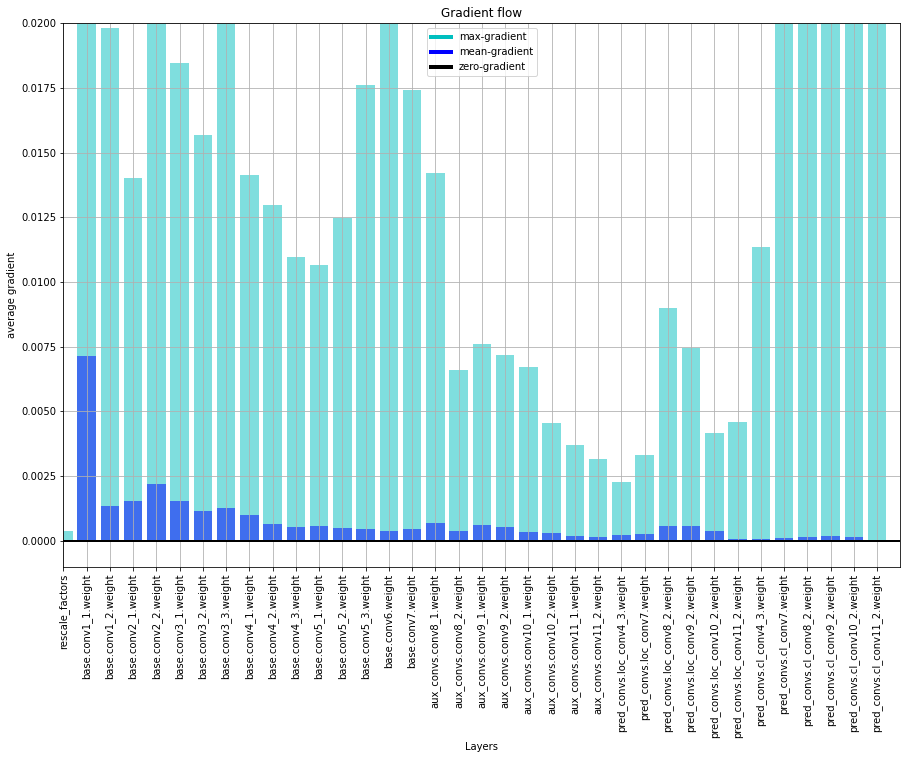

Epoch: [80][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4034 (3.1274)	Loss_c 3.0152 (2.7361)	Loss_l 0.3883 (0.3913)	
Epoch: [80][2400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.7709 (3.1270)	Loss_c 2.4410 (2.7358)	Loss_l 0.3300 (0.3912)	
Epoch: [80][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1659 (3.1269)	Loss_c 2.7721 (2.7356)	Loss_l 0.3938 (0.3912)	
Epoch: [80][2800/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1935 (3.1269)	Loss_c 2.8172 (2.7360)	Loss_l 0.3763 (0.3910)	
Epoch: [80][3000/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.1515 (3.1267)	Loss_c 2.7241 (2.7355)	Loss_l 0.4275 (0.3913)	


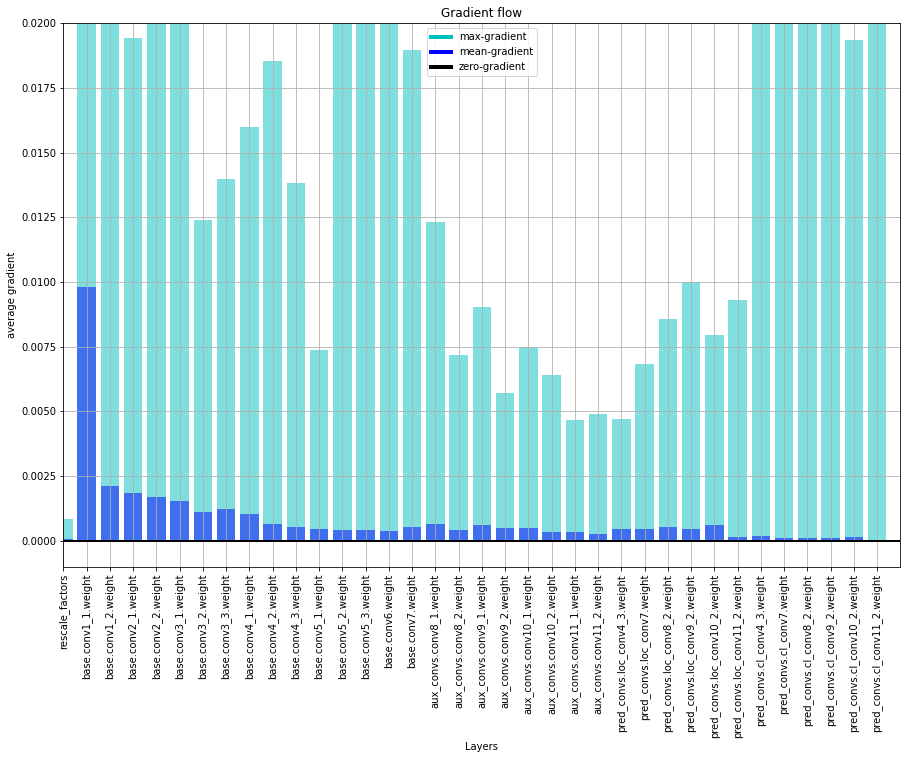

Epoch: [80][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9250 (3.1271)	Loss_c 2.5215 (2.7361)	Loss_l 0.4035 (0.3911)	
Epoch: [80][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.6766 (3.1275)	Loss_c 2.3239 (2.7363)	Loss_l 0.3527 (0.3912)	
Epoch: [80][3600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0265 (3.1272)	Loss_c 2.6457 (2.7359)	Loss_l 0.3809 (0.3912)	
Epoch: [81][0/3697]	Batch Time 1.888 (1.888)	Data Time 1.445 (1.445)	Loss 3.4610 (3.4610)	Loss_c 2.9812 (2.9812)	Loss_l 0.4798 (0.4798)	


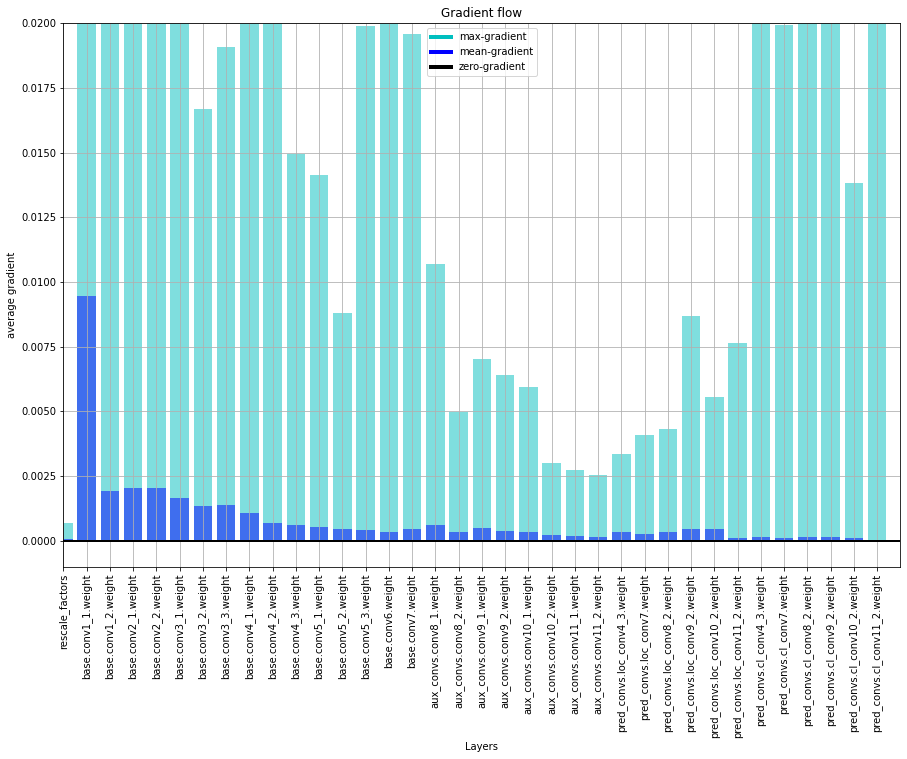

Epoch: [81][200/3697]	Batch Time 0.421 (0.431)	Data Time 0.000 (0.010)	Loss 3.1818 (3.1146)	Loss_c 2.7352 (2.7229)	Loss_l 0.4465 (0.3917)	
Epoch: [81][400/3697]	Batch Time 0.420 (0.426)	Data Time 0.000 (0.005)	Loss 3.3332 (3.1252)	Loss_c 2.9044 (2.7341)	Loss_l 0.4289 (0.3910)	
Epoch: [81][600/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.2017 (3.1349)	Loss_c 2.8253 (2.7427)	Loss_l 0.3764 (0.3922)	
Epoch: [81][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.003)	Loss 3.0948 (3.1328)	Loss_c 2.7283 (2.7399)	Loss_l 0.3664 (0.3929)	
Epoch: [81][1000/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.0695 (3.1330)	Loss_c 2.6735 (2.7397)	Loss_l 0.3960 (0.3933)	


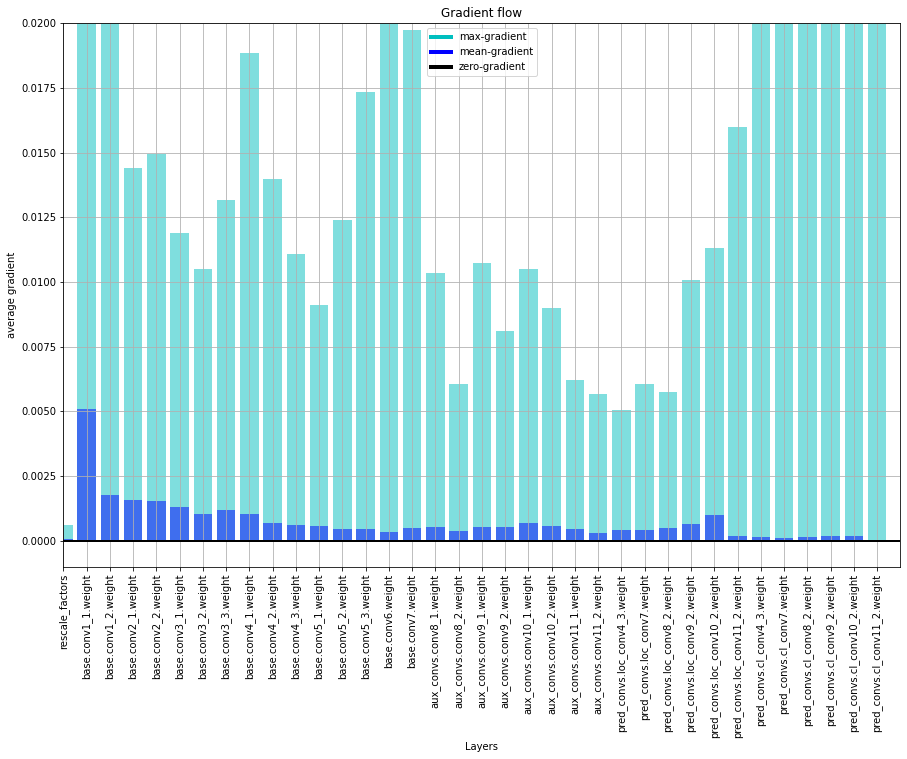

Epoch: [81][1200/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.002)	Loss 2.7766 (3.1334)	Loss_c 2.4745 (2.7401)	Loss_l 0.3021 (0.3932)	
Epoch: [81][1400/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.002)	Loss 3.2739 (3.1325)	Loss_c 2.8460 (2.7398)	Loss_l 0.4279 (0.3927)	
Epoch: [81][1600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.002)	Loss 3.2082 (3.1271)	Loss_c 2.7388 (2.7352)	Loss_l 0.4695 (0.3920)	
Epoch: [81][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.6958 (3.1273)	Loss_c 2.3486 (2.7359)	Loss_l 0.3472 (0.3914)	
Epoch: [81][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.8678 (3.1284)	Loss_c 2.4928 (2.7367)	Loss_l 0.3751 (0.3917)	


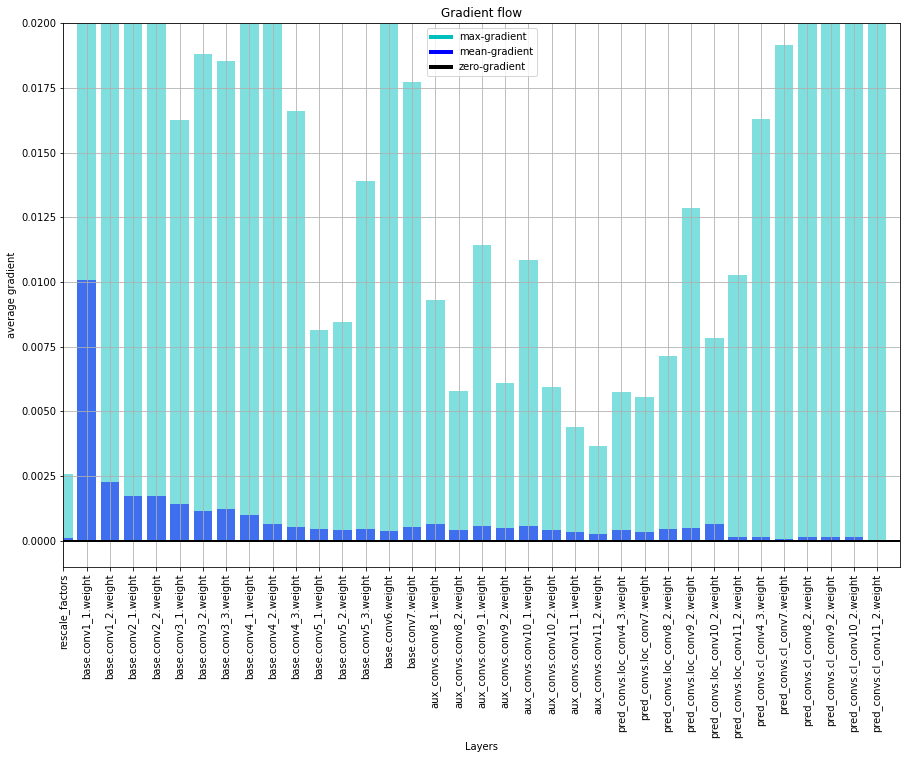

Epoch: [81][2200/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.2477 (3.1274)	Loss_c 2.8587 (2.7356)	Loss_l 0.3890 (0.3917)	
Epoch: [81][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0795 (3.1283)	Loss_c 2.6794 (2.7366)	Loss_l 0.4001 (0.3917)	
Epoch: [81][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3544 (3.1287)	Loss_c 2.8846 (2.7368)	Loss_l 0.4697 (0.3919)	
Epoch: [81][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.6822 (3.1278)	Loss_c 2.3257 (2.7363)	Loss_l 0.3565 (0.3914)	
Epoch: [81][3000/3697]	Batch Time 0.427 (0.423)	Data Time 0.000 (0.001)	Loss 2.9386 (3.1280)	Loss_c 2.5900 (2.7366)	Loss_l 0.3486 (0.3915)	


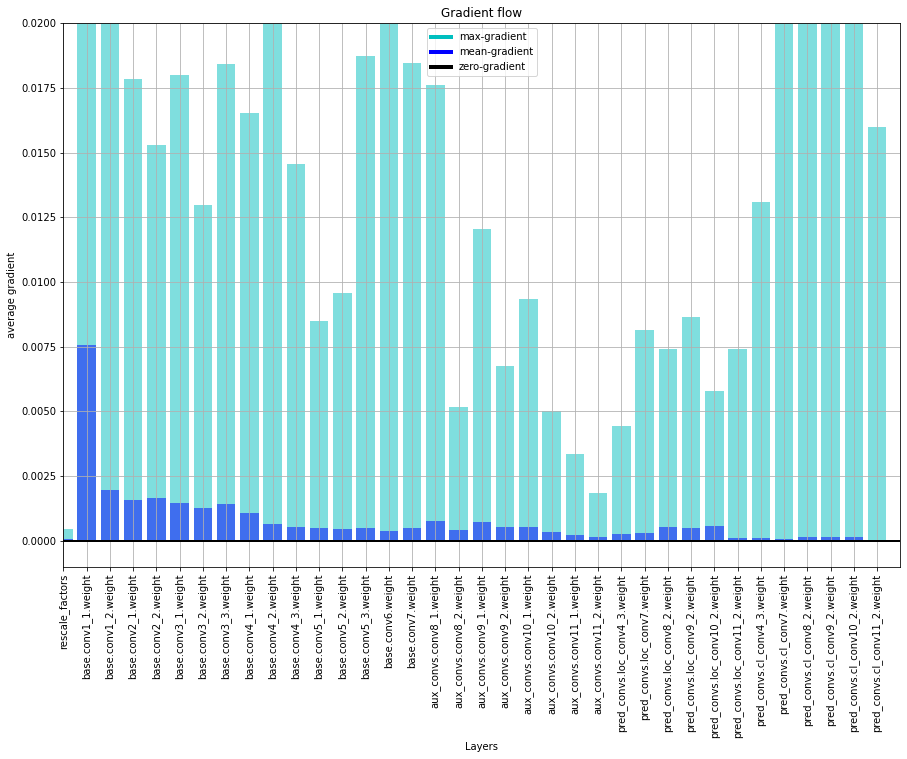

Epoch: [81][3200/3697]	Batch Time 0.432 (0.423)	Data Time 0.000 (0.001)	Loss 3.1844 (3.1268)	Loss_c 2.8237 (2.7355)	Loss_l 0.3607 (0.3913)	
Epoch: [81][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0375 (3.1275)	Loss_c 2.6680 (2.7359)	Loss_l 0.3695 (0.3915)	
Epoch: [81][3600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1892 (3.1278)	Loss_c 2.7506 (2.7362)	Loss_l 0.4386 (0.3916)	
Epoch: [82][0/3697]	Batch Time 1.917 (1.917)	Data Time 1.481 (1.481)	Loss 2.9783 (2.9783)	Loss_c 2.6279 (2.6279)	Loss_l 0.3504 (0.3504)	


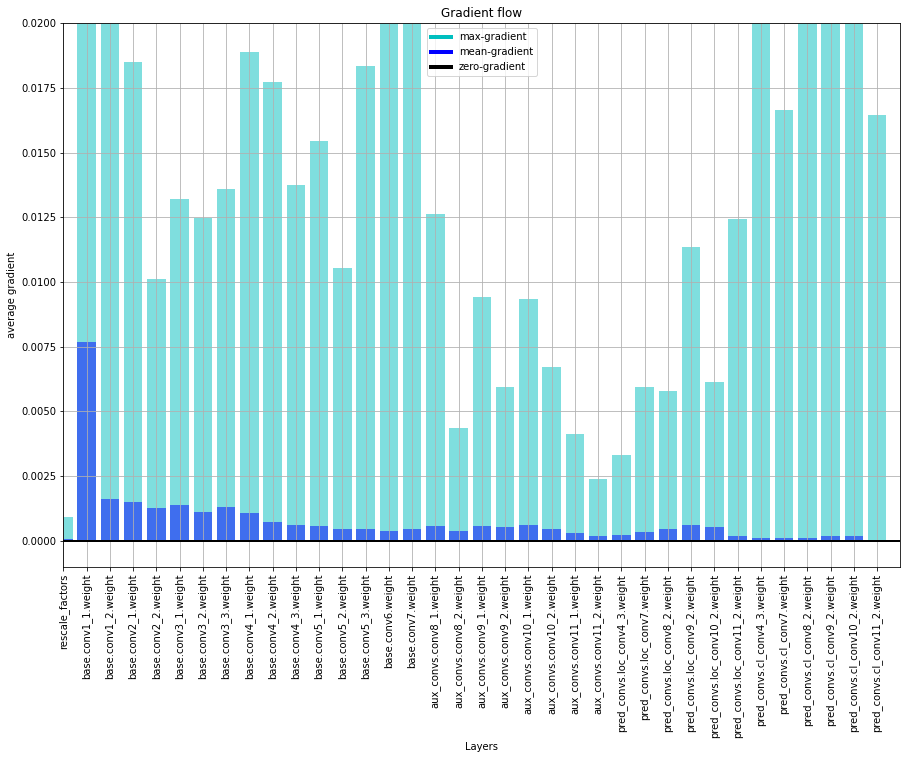

Epoch: [82][200/3697]	Batch Time 0.420 (0.431)	Data Time 0.000 (0.010)	Loss 3.2796 (3.1209)	Loss_c 2.9423 (2.7269)	Loss_l 0.3373 (0.3940)	
Epoch: [82][400/3697]	Batch Time 0.430 (0.426)	Data Time 0.000 (0.005)	Loss 3.1986 (3.1336)	Loss_c 2.7938 (2.7423)	Loss_l 0.4048 (0.3913)	
Epoch: [82][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.4986 (3.1302)	Loss_c 3.0615 (2.7421)	Loss_l 0.4372 (0.3882)	
Epoch: [82][800/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.003)	Loss 2.9487 (3.1251)	Loss_c 2.5974 (2.7369)	Loss_l 0.3513 (0.3882)	
Epoch: [82][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0514 (3.1253)	Loss_c 2.6703 (2.7367)	Loss_l 0.3811 (0.3886)	


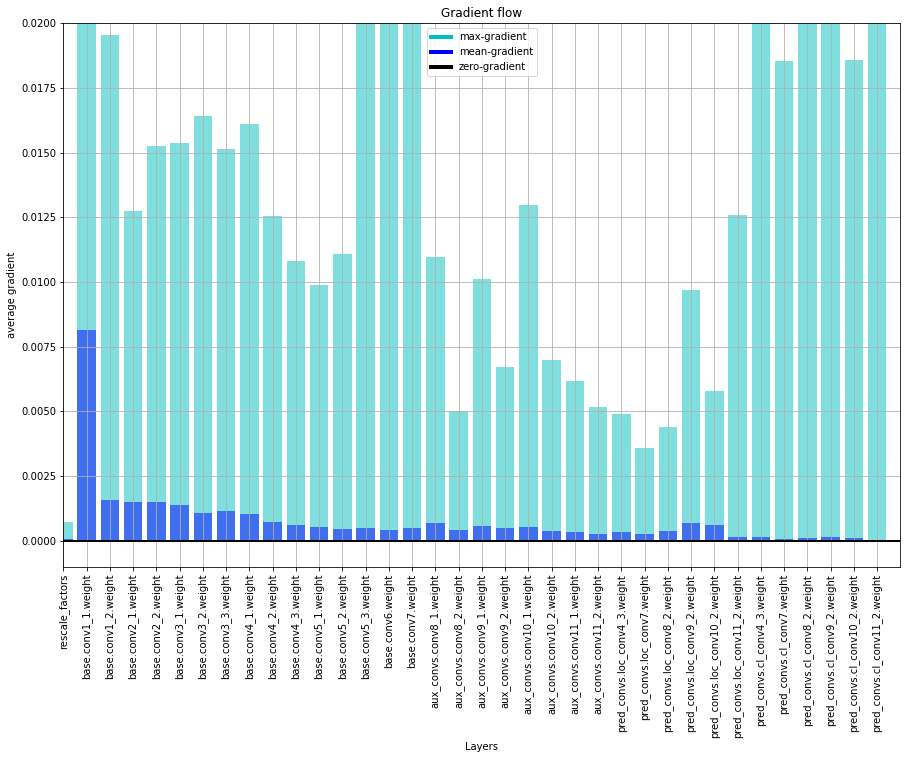

Epoch: [82][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.8792 (3.1283)	Loss_c 2.5366 (2.7386)	Loss_l 0.3426 (0.3898)	
Epoch: [82][1400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.3934 (3.1308)	Loss_c 2.9869 (2.7402)	Loss_l 0.4064 (0.3907)	
Epoch: [82][1600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.002)	Loss 3.0151 (3.1289)	Loss_c 2.6835 (2.7387)	Loss_l 0.3316 (0.3902)	
Epoch: [82][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4840 (3.1257)	Loss_c 3.0428 (2.7358)	Loss_l 0.4413 (0.3900)	
Epoch: [82][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0257 (3.1258)	Loss_c 2.6429 (2.7357)	Loss_l 0.3828 (0.3901)	


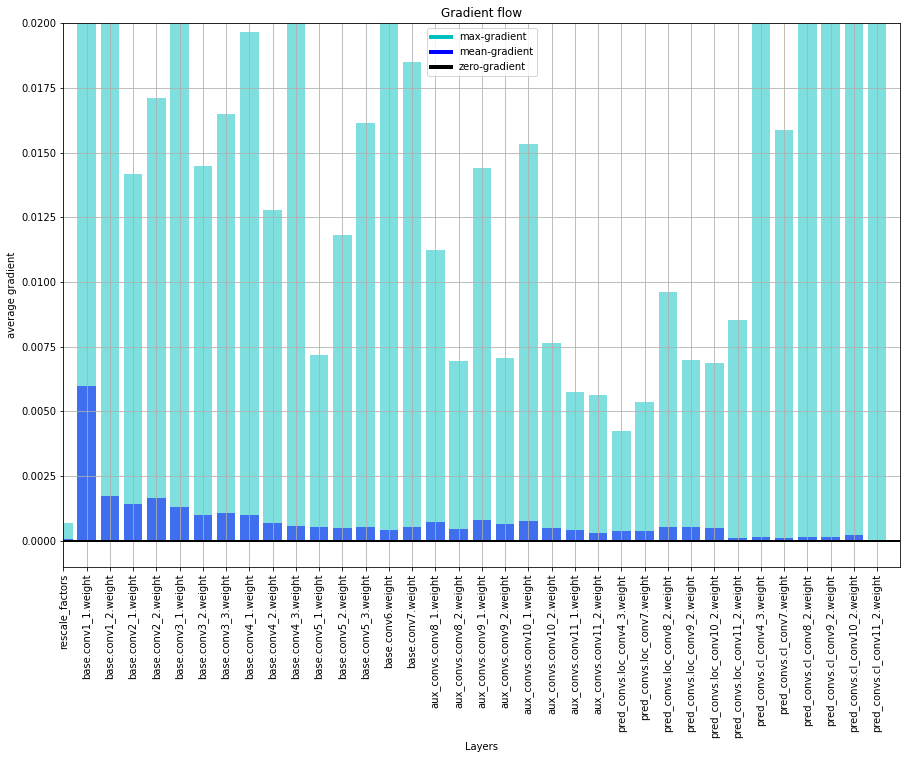

Epoch: [82][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1710 (3.1263)	Loss_c 2.7845 (2.7359)	Loss_l 0.3865 (0.3904)	
Epoch: [82][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.6733 (3.1269)	Loss_c 3.2334 (2.7365)	Loss_l 0.4399 (0.3904)	
Epoch: [82][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1675 (3.1249)	Loss_c 2.7669 (2.7347)	Loss_l 0.4005 (0.3901)	
Epoch: [82][2800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9089 (3.1253)	Loss_c 2.5403 (2.7351)	Loss_l 0.3686 (0.3903)	
Epoch: [82][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4602 (3.1264)	Loss_c 3.0012 (2.7359)	Loss_l 0.4590 (0.3906)	


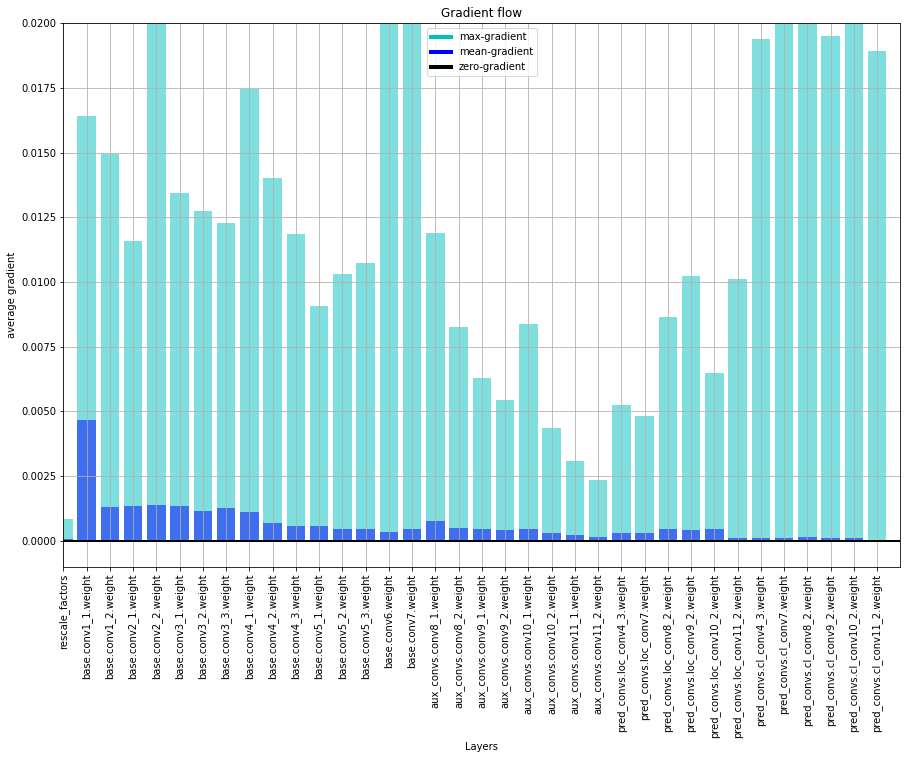

Epoch: [82][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9575 (3.1256)	Loss_c 2.6010 (2.7350)	Loss_l 0.3564 (0.3906)	
Epoch: [82][3400/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.4498 (3.1255)	Loss_c 3.1002 (2.7348)	Loss_l 0.3496 (0.3908)	
Epoch: [82][3600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.4043 (3.1259)	Loss_c 3.0065 (2.7350)	Loss_l 0.3978 (0.3908)	
Epoch: [83][0/3697]	Batch Time 1.629 (1.629)	Data Time 1.203 (1.203)	Loss 3.4154 (3.4154)	Loss_c 3.0562 (3.0562)	Loss_l 0.3592 (0.3592)	


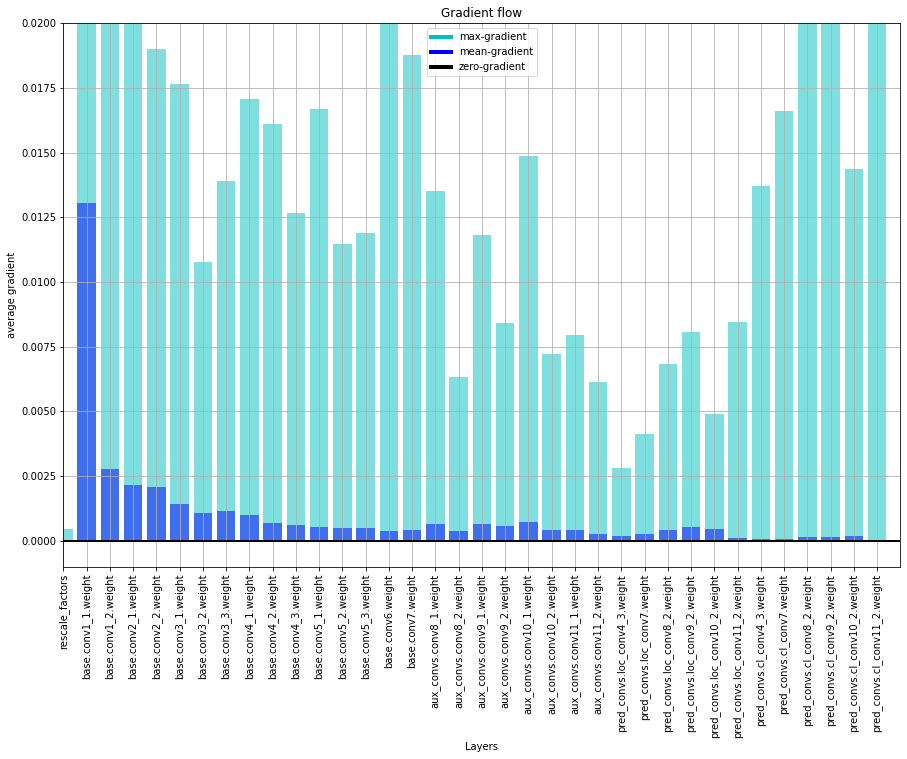

Epoch: [83][200/3697]	Batch Time 0.422 (0.429)	Data Time 0.000 (0.008)	Loss 3.6081 (3.1397)	Loss_c 3.1409 (2.7476)	Loss_l 0.4672 (0.3920)	
Epoch: [83][400/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.004)	Loss 3.0920 (3.1495)	Loss_c 2.7020 (2.7549)	Loss_l 0.3900 (0.3946)	
Epoch: [83][600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.003)	Loss 3.5060 (3.1454)	Loss_c 3.0777 (2.7515)	Loss_l 0.4283 (0.3939)	
Epoch: [83][800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0184 (3.1411)	Loss_c 2.6704 (2.7478)	Loss_l 0.3480 (0.3933)	
Epoch: [83][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.0922 (3.1357)	Loss_c 2.7581 (2.7431)	Loss_l 0.3341 (0.3927)	


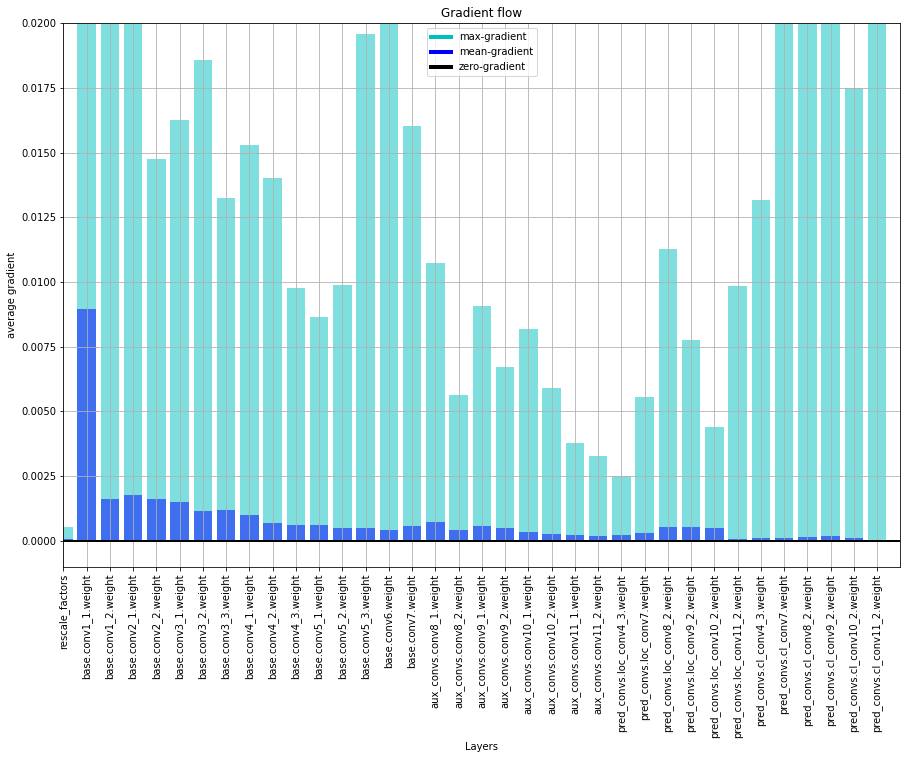

Epoch: [83][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.1006 (3.1335)	Loss_c 2.7590 (2.7416)	Loss_l 0.3416 (0.3919)	
Epoch: [83][1400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.3005 (3.1326)	Loss_c 2.8994 (2.7406)	Loss_l 0.4011 (0.3920)	
Epoch: [83][1600/3697]	Batch Time 0.429 (0.423)	Data Time 0.000 (0.001)	Loss 3.1836 (3.1317)	Loss_c 2.7305 (2.7393)	Loss_l 0.4531 (0.3924)	
Epoch: [83][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0786 (3.1334)	Loss_c 2.7122 (2.7411)	Loss_l 0.3664 (0.3923)	
Epoch: [83][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3253 (3.1354)	Loss_c 2.9420 (2.7425)	Loss_l 0.3832 (0.3929)	


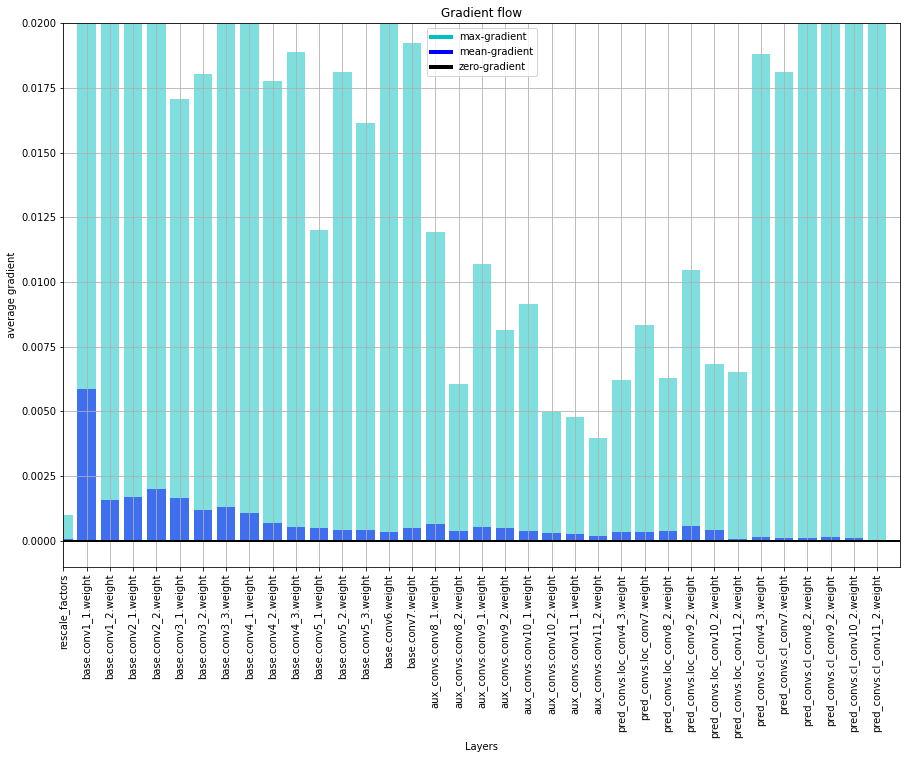

Epoch: [83][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1392 (3.1320)	Loss_c 2.7544 (2.7397)	Loss_l 0.3848 (0.3923)	
Epoch: [83][2400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.7862 (3.1294)	Loss_c 3.2735 (2.7370)	Loss_l 0.5127 (0.3924)	
Epoch: [83][2600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 3.4941 (3.1287)	Loss_c 3.0497 (2.7371)	Loss_l 0.4444 (0.3916)	
Epoch: [83][2800/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 3.2688 (3.1286)	Loss_c 2.8448 (2.7372)	Loss_l 0.4240 (0.3914)	
Epoch: [83][3000/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 3.1136 (3.1290)	Loss_c 2.7337 (2.7380)	Loss_l 0.3799 (0.3911)	


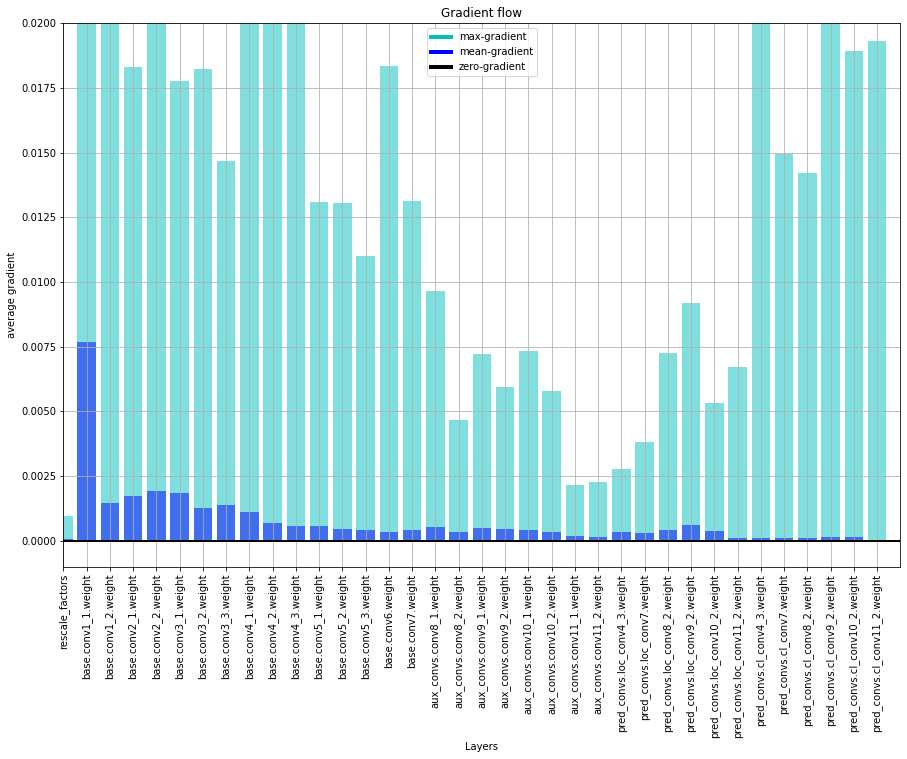

Epoch: [83][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1756 (3.1293)	Loss_c 2.7368 (2.7381)	Loss_l 0.4389 (0.3912)	
Epoch: [83][3400/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2909 (3.1297)	Loss_c 2.9433 (2.7385)	Loss_l 0.3476 (0.3912)	
Epoch: [83][3600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1067 (3.1304)	Loss_c 2.7150 (2.7390)	Loss_l 0.3918 (0.3914)	
Epoch: [84][0/3697]	Batch Time 1.975 (1.975)	Data Time 1.530 (1.530)	Loss 3.4542 (3.4542)	Loss_c 2.9963 (2.9963)	Loss_l 0.4579 (0.4579)	


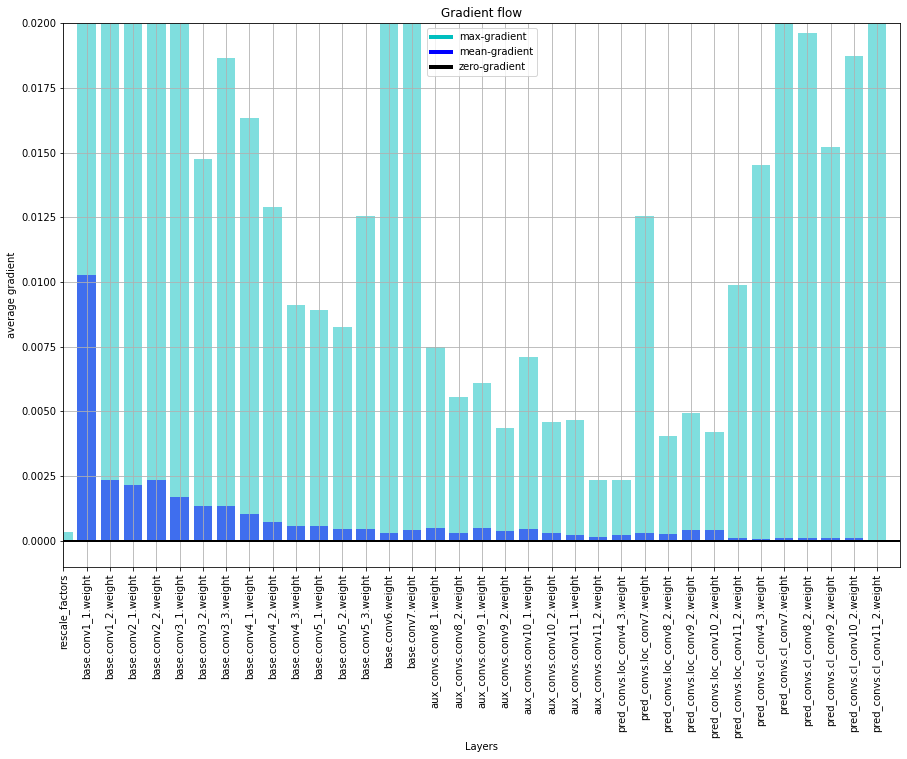

Epoch: [84][200/3697]	Batch Time 0.421 (0.432)	Data Time 0.000 (0.010)	Loss 3.3599 (3.1246)	Loss_c 2.9273 (2.7328)	Loss_l 0.4326 (0.3919)	
Epoch: [84][400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.005)	Loss 3.3861 (3.1425)	Loss_c 2.9652 (2.7468)	Loss_l 0.4209 (0.3957)	
Epoch: [84][600/3697]	Batch Time 0.425 (0.426)	Data Time 0.000 (0.003)	Loss 3.1956 (3.1331)	Loss_c 2.8123 (2.7390)	Loss_l 0.3833 (0.3941)	
Epoch: [84][800/3697]	Batch Time 0.425 (0.425)	Data Time 0.000 (0.003)	Loss 3.3022 (3.1299)	Loss_c 2.8418 (2.7363)	Loss_l 0.4604 (0.3936)	
Epoch: [84][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.2250 (3.1292)	Loss_c 2.8461 (2.7373)	Loss_l 0.3789 (0.3919)	


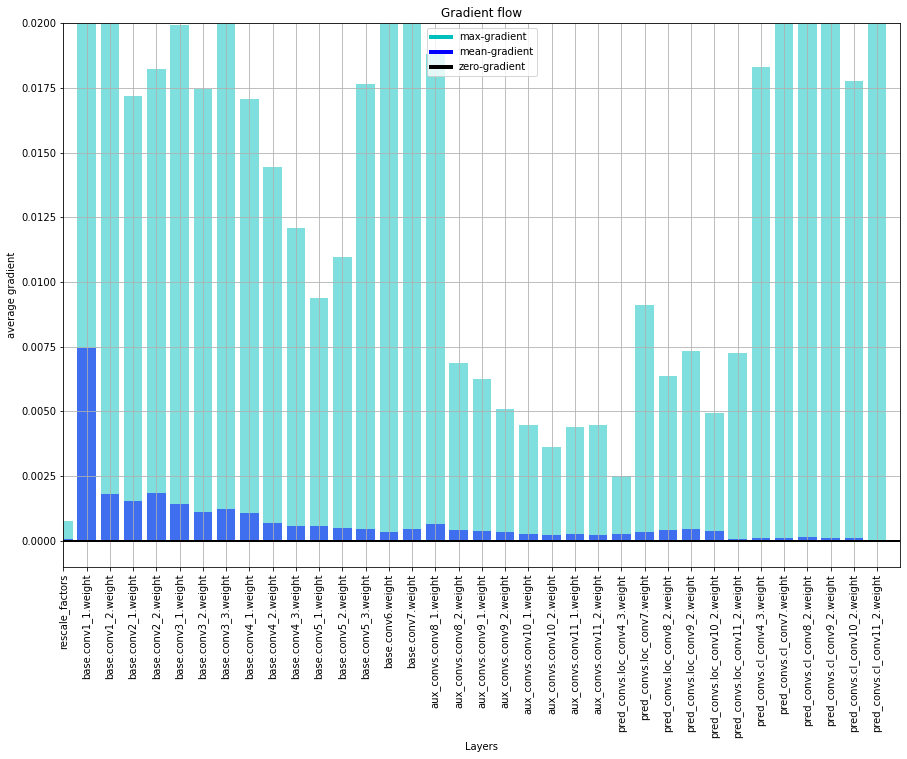

Epoch: [84][1200/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.1937 (3.1295)	Loss_c 2.8119 (2.7367)	Loss_l 0.3818 (0.3928)	
Epoch: [84][1400/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 2.9227 (3.1281)	Loss_c 2.5836 (2.7355)	Loss_l 0.3391 (0.3926)	
Epoch: [84][1600/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.002)	Loss 2.9320 (3.1263)	Loss_c 2.5734 (2.7338)	Loss_l 0.3586 (0.3925)	
Epoch: [84][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.4099 (3.1259)	Loss_c 3.0595 (2.7343)	Loss_l 0.3505 (0.3916)	
Epoch: [84][2000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.8092 (3.1283)	Loss_c 2.4746 (2.7362)	Loss_l 0.3346 (0.3921)	


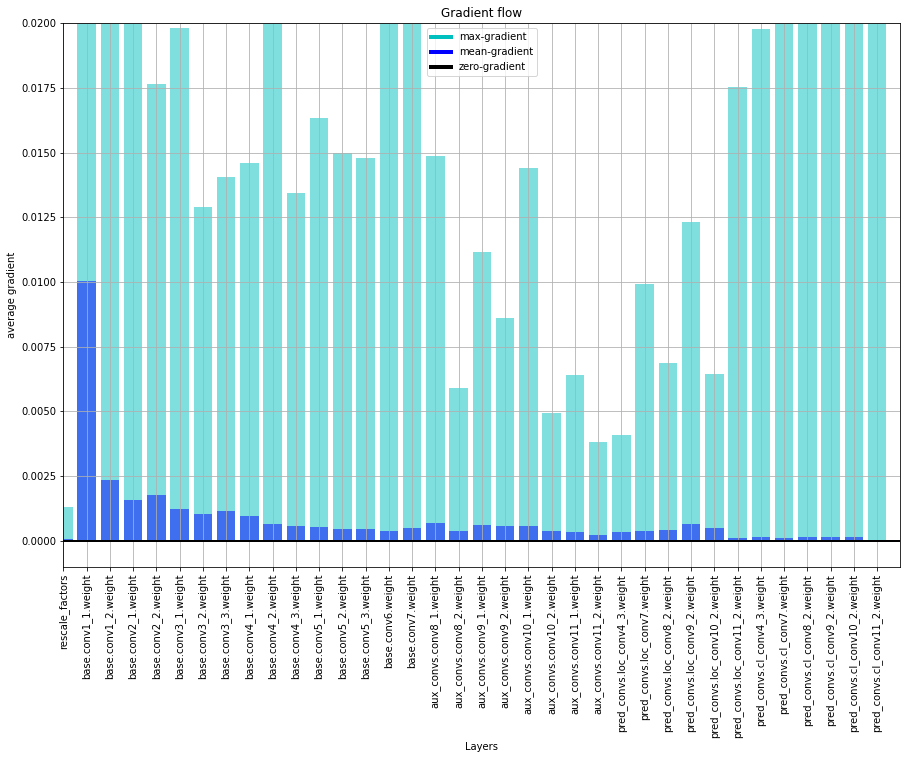

Epoch: [84][2200/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.4723 (3.1285)	Loss_c 3.0030 (2.7366)	Loss_l 0.4693 (0.3919)	
Epoch: [84][2400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.2737 (3.1270)	Loss_c 2.8681 (2.7355)	Loss_l 0.4056 (0.3916)	
Epoch: [84][2600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0921 (3.1277)	Loss_c 2.6670 (2.7361)	Loss_l 0.4251 (0.3916)	
Epoch: [84][2800/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.2256 (3.1275)	Loss_c 2.8654 (2.7362)	Loss_l 0.3602 (0.3913)	
Epoch: [84][3000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.4047 (3.1274)	Loss_c 2.9719 (2.7363)	Loss_l 0.4328 (0.3911)	


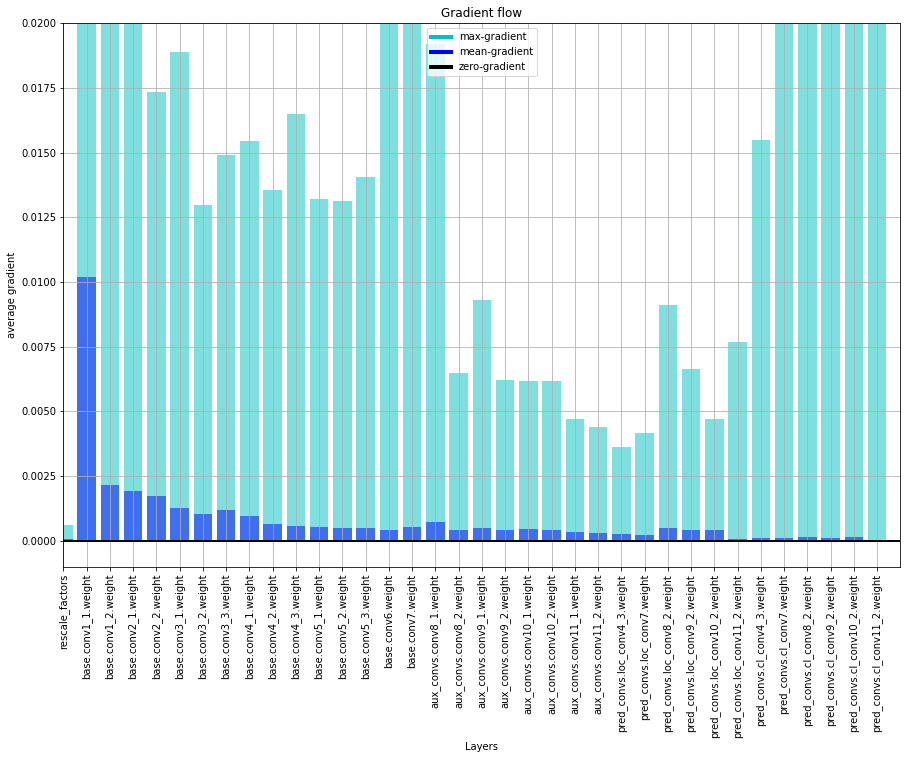

Epoch: [84][3200/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.9259 (3.1285)	Loss_c 2.5649 (2.7372)	Loss_l 0.3611 (0.3913)	
Epoch: [84][3400/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.001)	Loss 3.1087 (3.1281)	Loss_c 2.7076 (2.7369)	Loss_l 0.4011 (0.3912)	
Epoch: [84][3600/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 2.8488 (3.1284)	Loss_c 2.4790 (2.7375)	Loss_l 0.3698 (0.3909)	
Epoch: [85][0/3697]	Batch Time 2.034 (2.034)	Data Time 1.581 (1.581)	Loss 3.4478 (3.4478)	Loss_c 2.9707 (2.9707)	Loss_l 0.4771 (0.4771)	


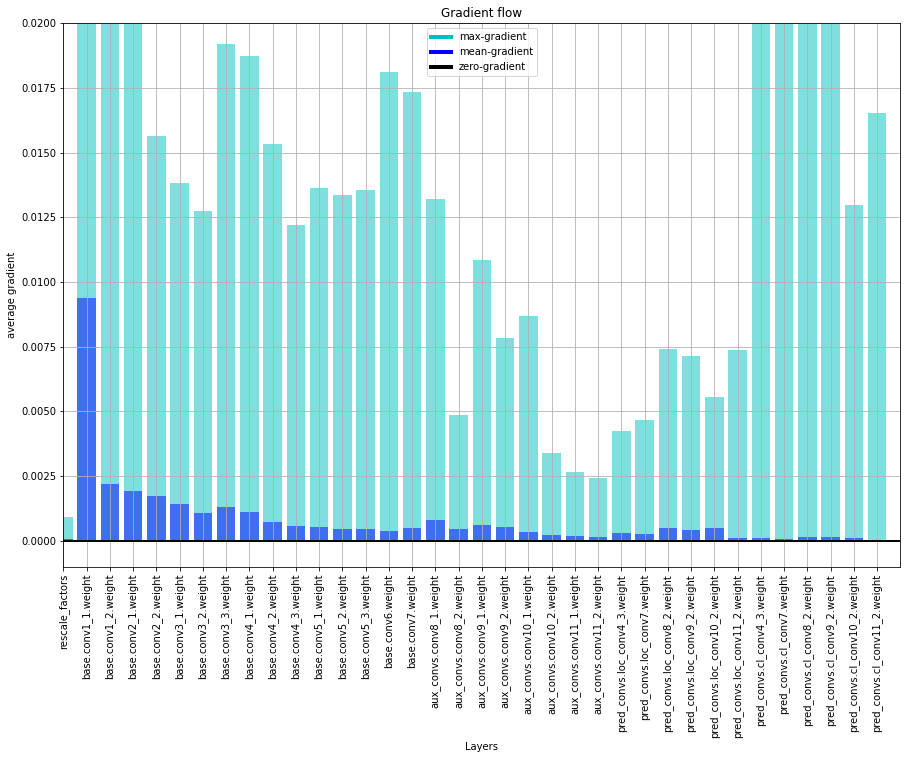

Epoch: [85][200/3697]	Batch Time 0.421 (0.432)	Data Time 0.000 (0.010)	Loss 3.1002 (3.1461)	Loss_c 2.6914 (2.7534)	Loss_l 0.4088 (0.3926)	
Epoch: [85][400/3697]	Batch Time 0.422 (0.427)	Data Time 0.000 (0.005)	Loss 3.0285 (3.1506)	Loss_c 2.6715 (2.7553)	Loss_l 0.3570 (0.3953)	
Epoch: [85][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.004)	Loss 3.1698 (3.1412)	Loss_c 2.7602 (2.7470)	Loss_l 0.4095 (0.3942)	
Epoch: [85][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.003)	Loss 3.0277 (3.1428)	Loss_c 2.6291 (2.7497)	Loss_l 0.3986 (0.3930)	
Epoch: [85][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.9306 (3.1373)	Loss_c 2.6223 (2.7461)	Loss_l 0.3082 (0.3912)	


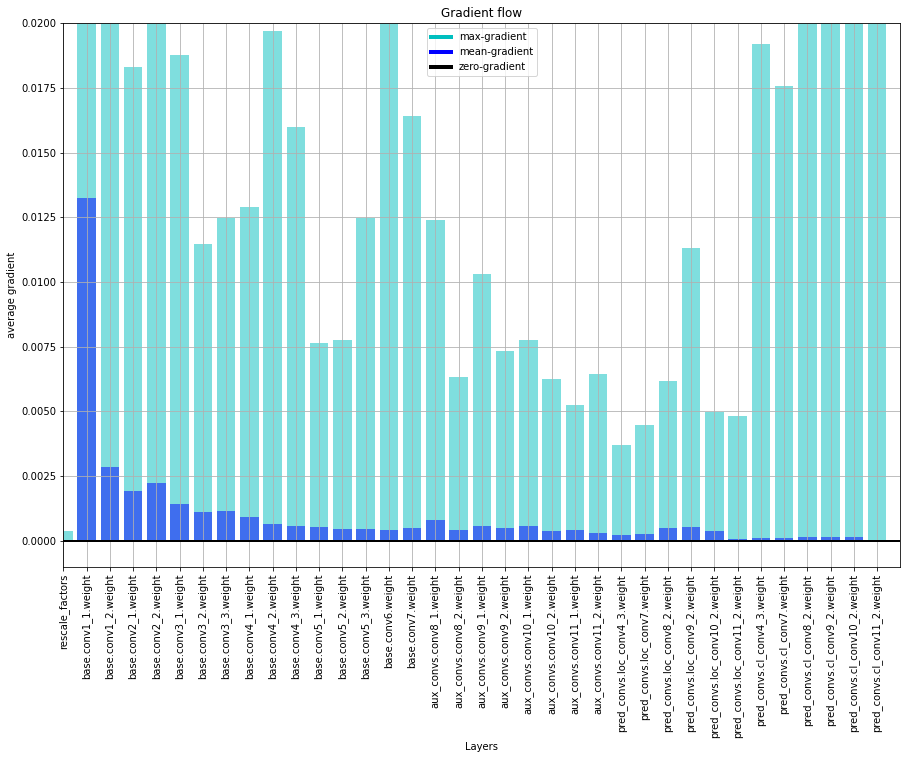

Epoch: [85][1200/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.002)	Loss 3.2158 (3.1393)	Loss_c 2.8134 (2.7469)	Loss_l 0.4024 (0.3924)	
Epoch: [85][1400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.2215 (3.1359)	Loss_c 2.7551 (2.7442)	Loss_l 0.4664 (0.3917)	
Epoch: [85][1600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.2331 (3.1336)	Loss_c 2.8510 (2.7425)	Loss_l 0.3821 (0.3911)	
Epoch: [85][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0357 (3.1323)	Loss_c 2.6745 (2.7411)	Loss_l 0.3612 (0.3912)	
Epoch: [85][2000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1458 (3.1303)	Loss_c 2.7709 (2.7393)	Loss_l 0.3749 (0.3910)	


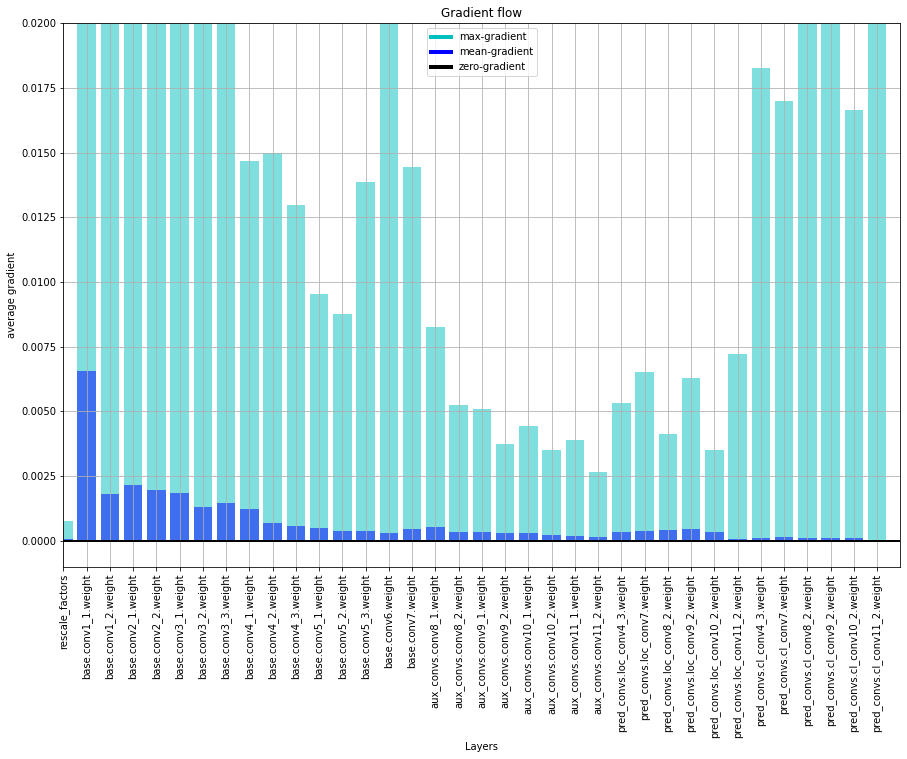

Epoch: [85][2200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9787 (3.1291)	Loss_c 2.6143 (2.7380)	Loss_l 0.3644 (0.3911)	
Epoch: [85][2400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.0418 (3.1302)	Loss_c 2.6484 (2.7387)	Loss_l 0.3934 (0.3914)	
Epoch: [85][2600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.8590 (3.1296)	Loss_c 2.5462 (2.7383)	Loss_l 0.3127 (0.3913)	
Epoch: [85][2800/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.2995 (3.1287)	Loss_c 2.9179 (2.7375)	Loss_l 0.3816 (0.3912)	
Epoch: [85][3000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2270 (3.1268)	Loss_c 2.7863 (2.7359)	Loss_l 0.4407 (0.3909)	


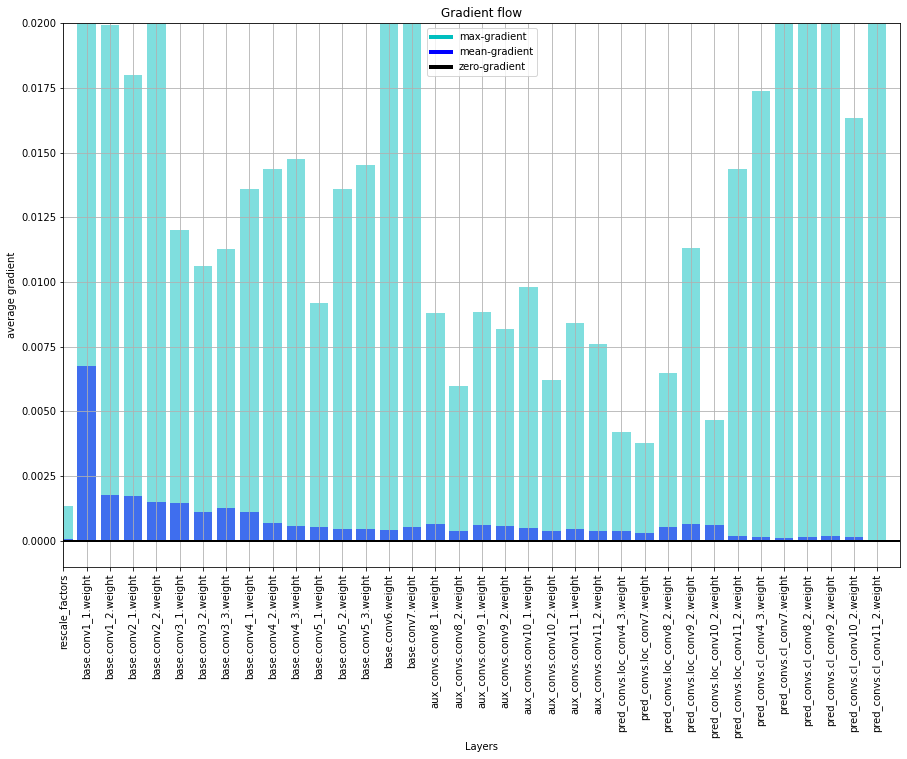

Epoch: [85][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.8385 (3.1272)	Loss_c 2.5202 (2.7361)	Loss_l 0.3183 (0.3911)	
Epoch: [85][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1811 (3.1273)	Loss_c 2.7447 (2.7361)	Loss_l 0.4364 (0.3912)	
Epoch: [85][3600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1114 (3.1280)	Loss_c 2.6561 (2.7365)	Loss_l 0.4553 (0.3915)	
Epoch: [86][0/3697]	Batch Time 2.096 (2.096)	Data Time 1.637 (1.637)	Loss 3.2473 (3.2473)	Loss_c 2.8196 (2.8196)	Loss_l 0.4277 (0.4277)	


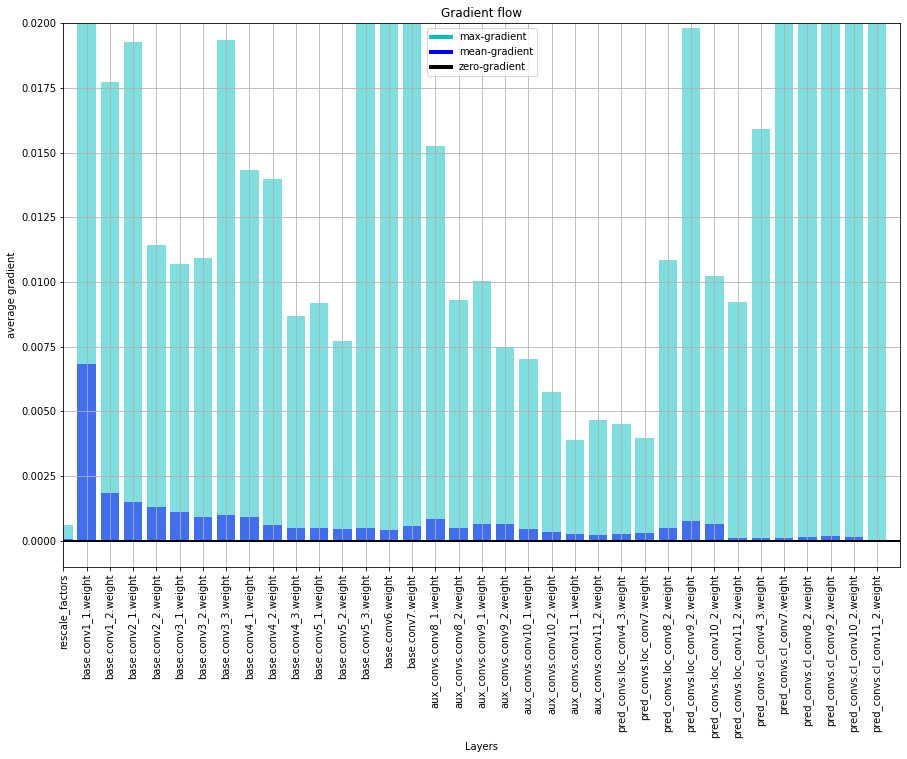

Epoch: [86][200/3697]	Batch Time 0.420 (0.432)	Data Time 0.000 (0.011)	Loss 3.0741 (3.1044)	Loss_c 2.7248 (2.7199)	Loss_l 0.3494 (0.3845)	
Epoch: [86][400/3697]	Batch Time 0.421 (0.427)	Data Time 0.000 (0.005)	Loss 3.1225 (3.1060)	Loss_c 2.7630 (2.7199)	Loss_l 0.3595 (0.3861)	
Epoch: [86][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.004)	Loss 3.2699 (3.1092)	Loss_c 2.8216 (2.7223)	Loss_l 0.4483 (0.3869)	
Epoch: [86][800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.003)	Loss 2.8225 (3.1154)	Loss_c 2.4211 (2.7269)	Loss_l 0.4014 (0.3886)	
Epoch: [86][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.0705 (3.1196)	Loss_c 2.7227 (2.7302)	Loss_l 0.3478 (0.3894)	


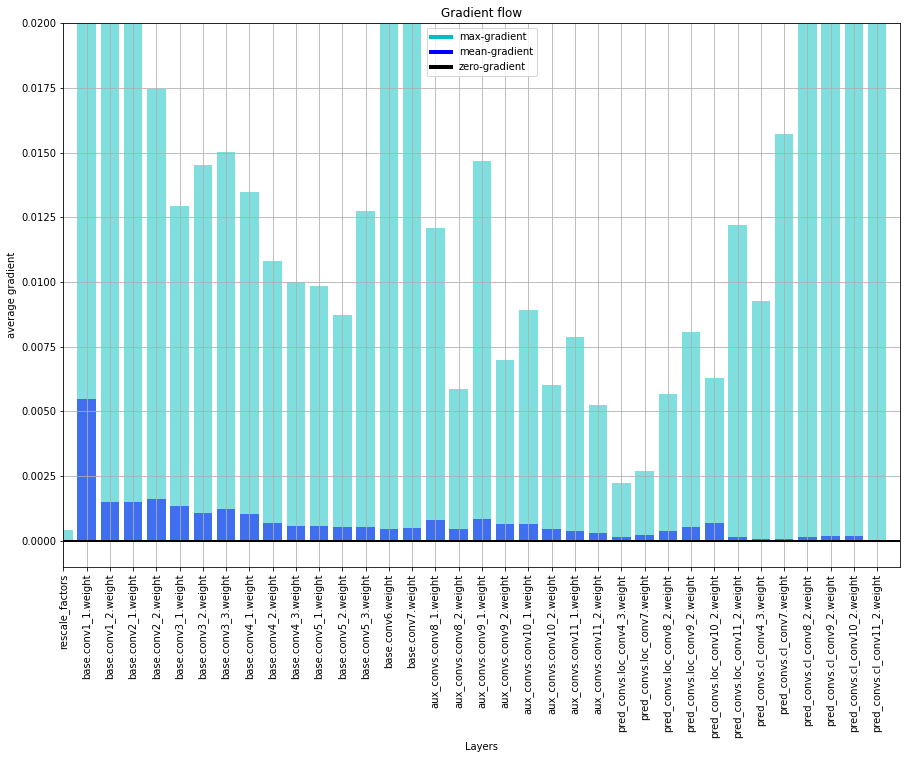

Epoch: [86][1200/3697]	Batch Time 0.431 (0.424)	Data Time 0.000 (0.002)	Loss 3.1116 (3.1203)	Loss_c 2.6567 (2.7312)	Loss_l 0.4549 (0.3891)	
Epoch: [86][1400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1588 (3.1209)	Loss_c 2.8069 (2.7323)	Loss_l 0.3519 (0.3886)	
Epoch: [86][1600/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.5335 (3.1220)	Loss_c 3.1226 (2.7326)	Loss_l 0.4108 (0.3895)	
Epoch: [86][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.1232 (3.1233)	Loss_c 2.7491 (2.7340)	Loss_l 0.3741 (0.3893)	
Epoch: [86][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.1252 (3.1250)	Loss_c 2.7492 (2.7353)	Loss_l 0.3759 (0.3897)	


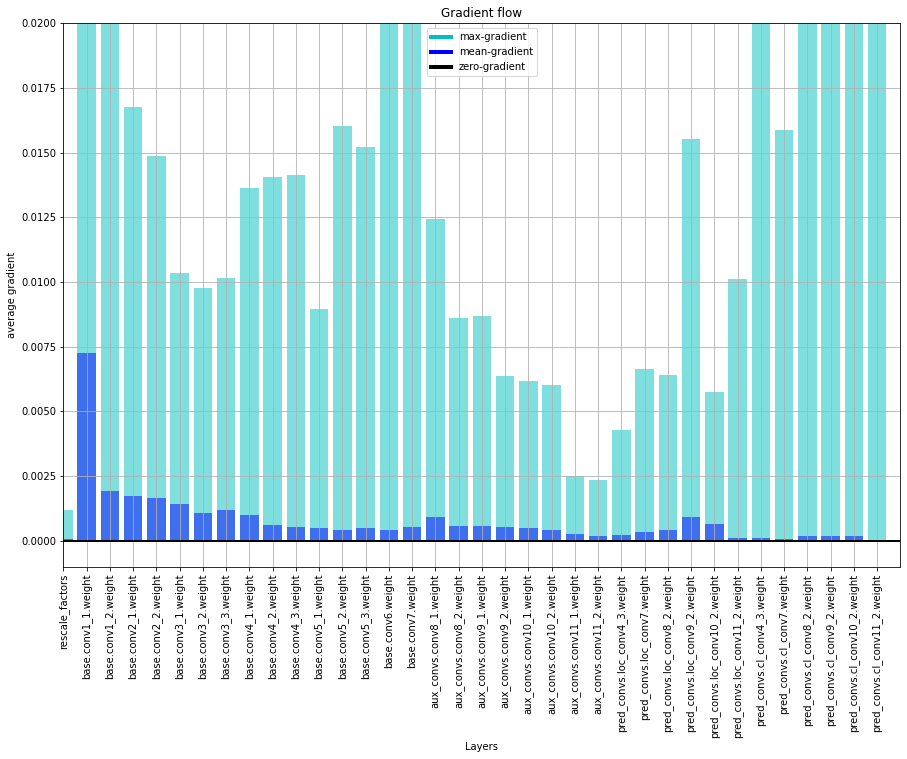

Epoch: [86][2200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2273 (3.1244)	Loss_c 2.7967 (2.7346)	Loss_l 0.4307 (0.3898)	
Epoch: [86][2400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.8575 (3.1257)	Loss_c 2.5133 (2.7355)	Loss_l 0.3442 (0.3902)	
Epoch: [86][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0505 (3.1252)	Loss_c 2.6405 (2.7350)	Loss_l 0.4100 (0.3902)	
Epoch: [86][2800/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.8707 (3.1265)	Loss_c 2.5693 (2.7361)	Loss_l 0.3014 (0.3904)	
Epoch: [86][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1684 (3.1268)	Loss_c 2.7305 (2.7362)	Loss_l 0.4379 (0.3906)	


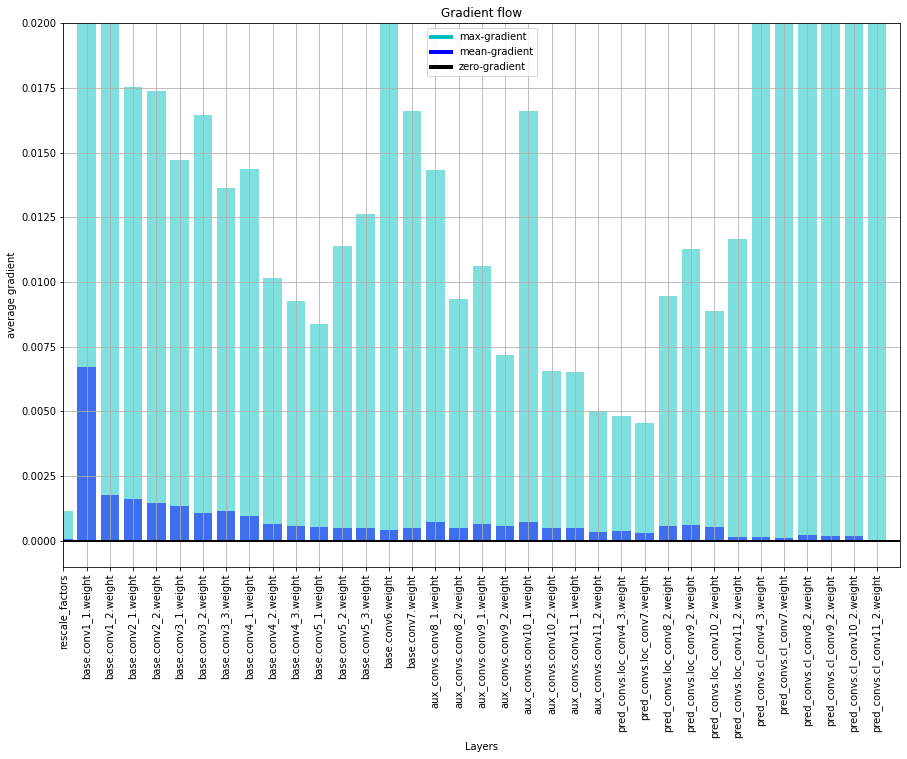

Epoch: [86][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0740 (3.1272)	Loss_c 2.7075 (2.7365)	Loss_l 0.3665 (0.3907)	
Epoch: [86][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.1078 (3.1269)	Loss_c 2.6832 (2.7363)	Loss_l 0.4246 (0.3905)	
Epoch: [86][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.8707 (3.1278)	Loss_c 2.4790 (2.7373)	Loss_l 0.3917 (0.3904)	
Epoch: [87][0/3697]	Batch Time 1.833 (1.833)	Data Time 1.402 (1.402)	Loss 3.2341 (3.2341)	Loss_c 2.8218 (2.8218)	Loss_l 0.4124 (0.4124)	


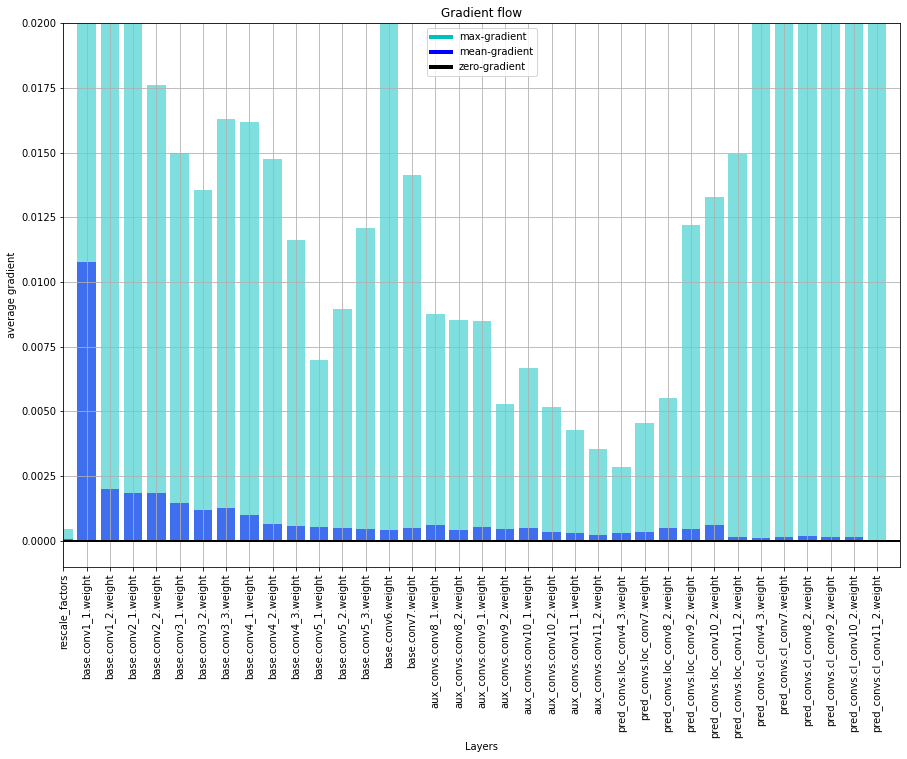

Epoch: [87][200/3697]	Batch Time 0.420 (0.431)	Data Time 0.000 (0.009)	Loss 3.1281 (3.1216)	Loss_c 2.7678 (2.7342)	Loss_l 0.3603 (0.3874)	
Epoch: [87][400/3697]	Batch Time 0.420 (0.427)	Data Time 0.000 (0.005)	Loss 3.2508 (3.1172)	Loss_c 2.8372 (2.7272)	Loss_l 0.4135 (0.3901)	
Epoch: [87][600/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.0850 (3.1131)	Loss_c 2.7579 (2.7252)	Loss_l 0.3271 (0.3878)	
Epoch: [87][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.9553 (3.1244)	Loss_c 2.5943 (2.7355)	Loss_l 0.3609 (0.3888)	
Epoch: [87][1000/3697]	Batch Time 0.434 (0.424)	Data Time 0.000 (0.002)	Loss 3.4531 (3.1190)	Loss_c 3.0328 (2.7309)	Loss_l 0.4202 (0.3881)	


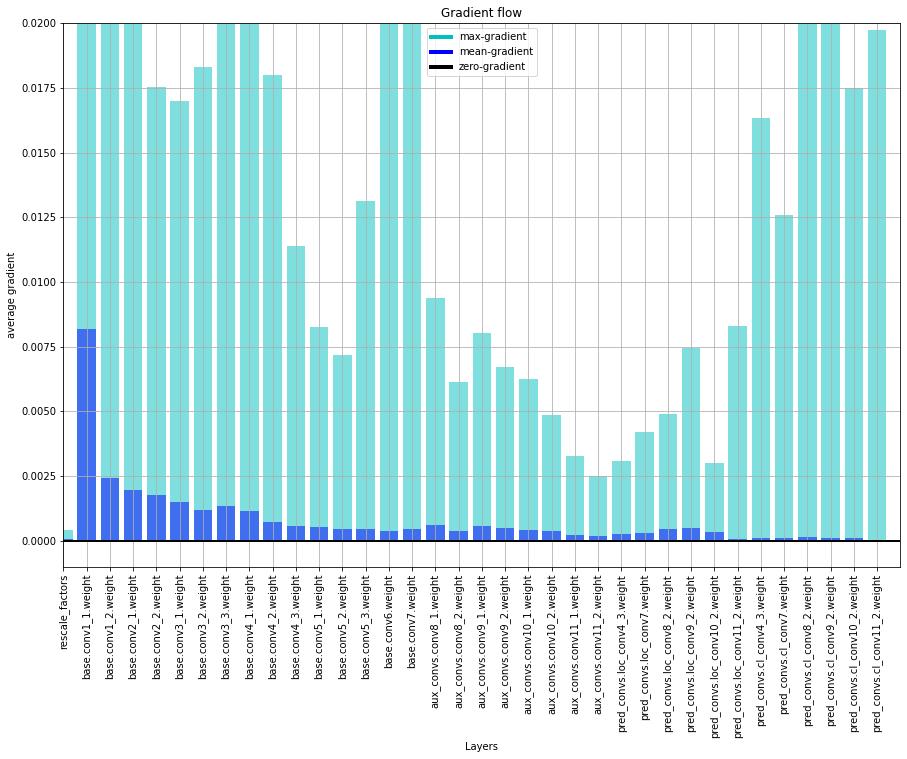

Epoch: [87][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.4696 (3.1187)	Loss_c 3.0641 (2.7303)	Loss_l 0.4055 (0.3884)	
Epoch: [87][1400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1756 (3.1209)	Loss_c 2.8091 (2.7320)	Loss_l 0.3664 (0.3889)	
Epoch: [87][1600/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.002)	Loss 2.9137 (3.1181)	Loss_c 2.5530 (2.7290)	Loss_l 0.3607 (0.3891)	
Epoch: [87][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.4691 (3.1180)	Loss_c 3.0790 (2.7289)	Loss_l 0.3901 (0.3891)	
Epoch: [87][2000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 2.9644 (3.1197)	Loss_c 2.5935 (2.7305)	Loss_l 0.3709 (0.3892)	


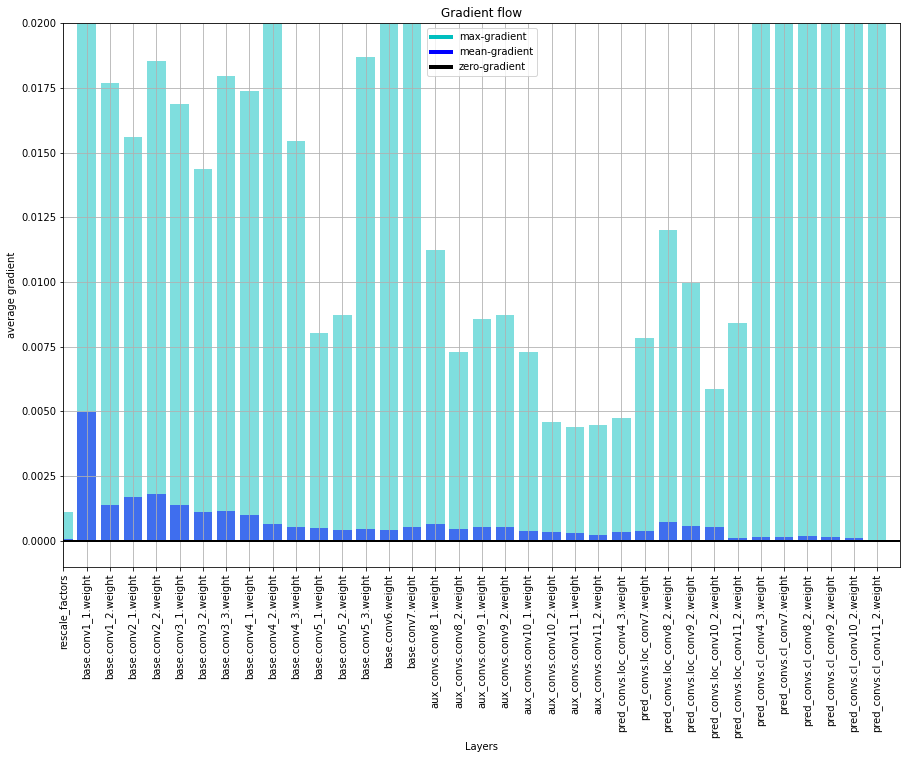

Epoch: [87][2200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.2907 (3.1211)	Loss_c 2.8009 (2.7312)	Loss_l 0.4898 (0.3898)	
Epoch: [87][2400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1721 (3.1195)	Loss_c 2.8173 (2.7297)	Loss_l 0.3548 (0.3898)	
Epoch: [87][2600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0554 (3.1197)	Loss_c 2.6750 (2.7299)	Loss_l 0.3804 (0.3899)	
Epoch: [87][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3336 (3.1217)	Loss_c 2.8937 (2.7313)	Loss_l 0.4400 (0.3904)	
Epoch: [87][3000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3050 (3.1212)	Loss_c 2.9263 (2.7309)	Loss_l 0.3787 (0.3903)	


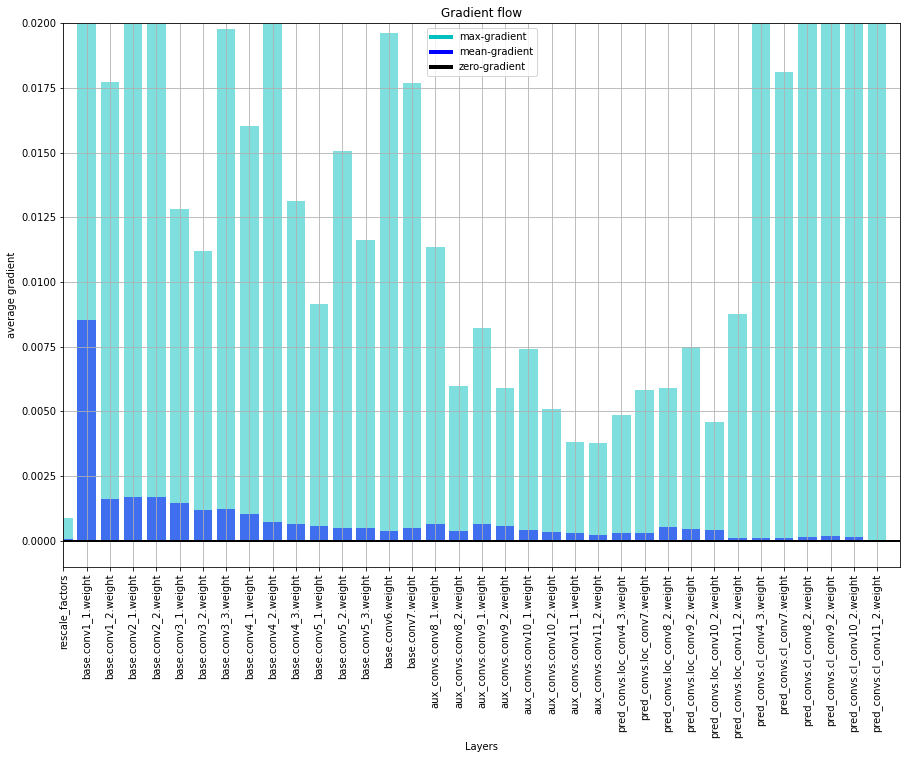

Epoch: [87][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0986 (3.1222)	Loss_c 2.6998 (2.7316)	Loss_l 0.3988 (0.3906)	
Epoch: [87][3400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3786 (3.1226)	Loss_c 2.9829 (2.7317)	Loss_l 0.3958 (0.3909)	
Epoch: [87][3600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.1249 (3.1236)	Loss_c 2.7427 (2.7326)	Loss_l 0.3823 (0.3910)	
Epoch: [88][0/3697]	Batch Time 2.101 (2.101)	Data Time 1.643 (1.643)	Loss 3.3231 (3.3231)	Loss_c 2.9600 (2.9600)	Loss_l 0.3631 (0.3631)	


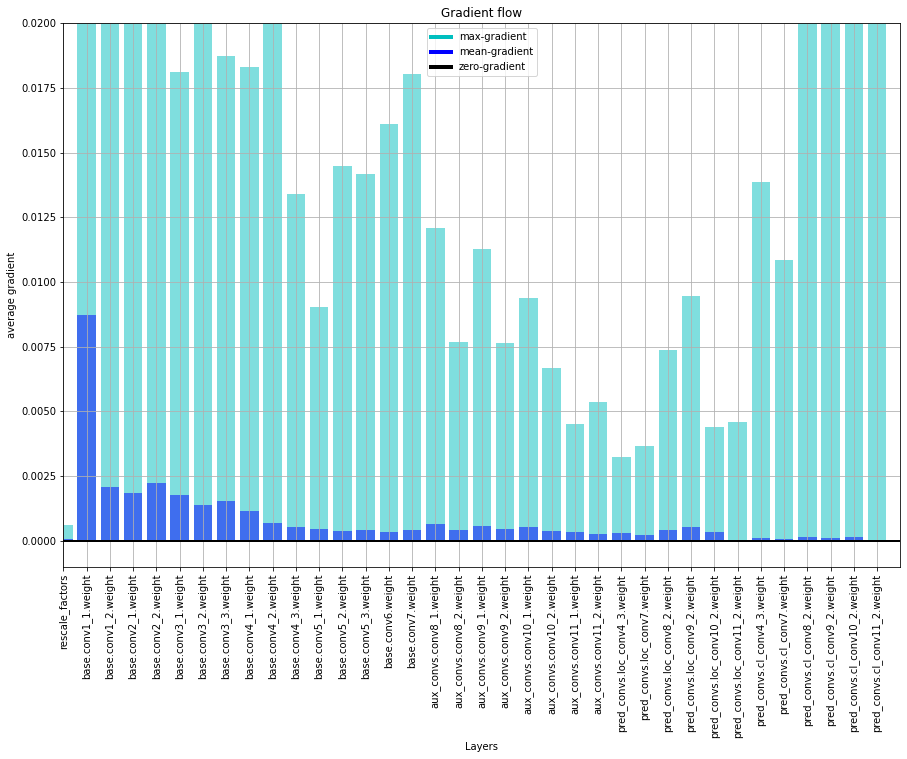

Epoch: [88][200/3697]	Batch Time 0.421 (0.432)	Data Time 0.000 (0.010)	Loss 3.0304 (3.1232)	Loss_c 2.6841 (2.7337)	Loss_l 0.3463 (0.3895)	
Epoch: [88][400/3697]	Batch Time 0.420 (0.427)	Data Time 0.000 (0.005)	Loss 3.3530 (3.1287)	Loss_c 2.9243 (2.7371)	Loss_l 0.4287 (0.3916)	
Epoch: [88][600/3697]	Batch Time 0.423 (0.425)	Data Time 0.000 (0.004)	Loss 3.1944 (3.1286)	Loss_c 2.8283 (2.7372)	Loss_l 0.3661 (0.3914)	
Epoch: [88][800/3697]	Batch Time 0.422 (0.425)	Data Time 0.000 (0.003)	Loss 3.1478 (3.1246)	Loss_c 2.8248 (2.7345)	Loss_l 0.3229 (0.3901)	
Epoch: [88][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.9622 (3.1218)	Loss_c 2.6365 (2.7317)	Loss_l 0.3257 (0.3901)	


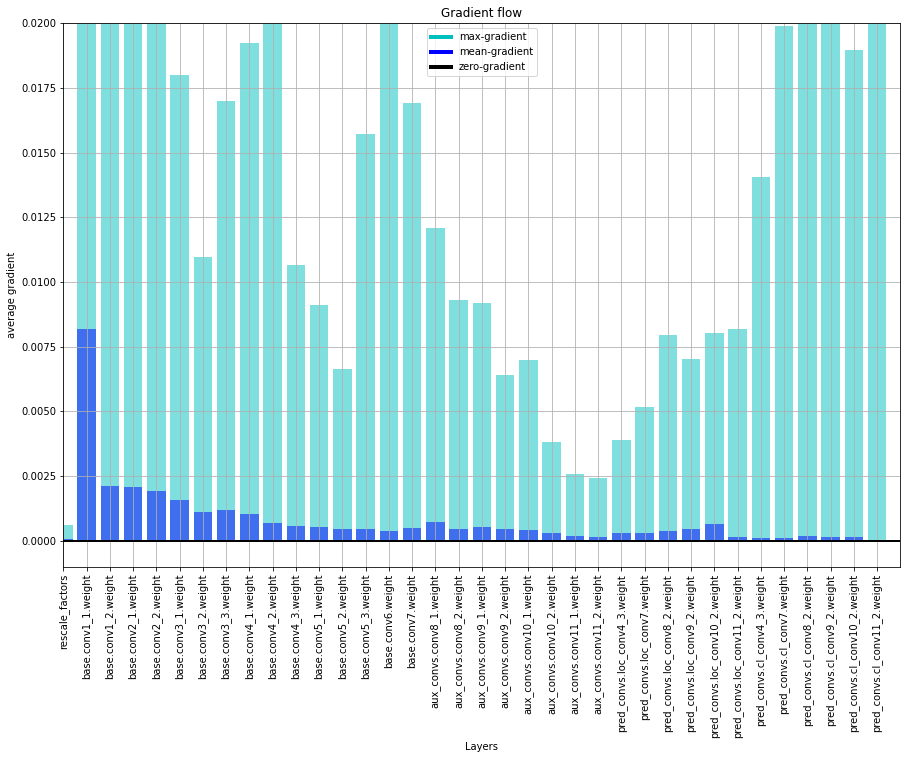

Epoch: [88][1200/3697]	Batch Time 0.426 (0.424)	Data Time 0.000 (0.002)	Loss 3.1436 (3.1245)	Loss_c 2.7359 (2.7342)	Loss_l 0.4077 (0.3903)	
Epoch: [88][1400/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.1927 (3.1241)	Loss_c 2.7965 (2.7341)	Loss_l 0.3962 (0.3900)	
Epoch: [88][1600/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 2.9598 (3.1238)	Loss_c 2.6070 (2.7339)	Loss_l 0.3528 (0.3899)	
Epoch: [88][1800/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.3673 (3.1233)	Loss_c 2.9492 (2.7333)	Loss_l 0.4181 (0.3899)	
Epoch: [88][2000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.3657 (3.1252)	Loss_c 2.9758 (2.7350)	Loss_l 0.3899 (0.3902)	


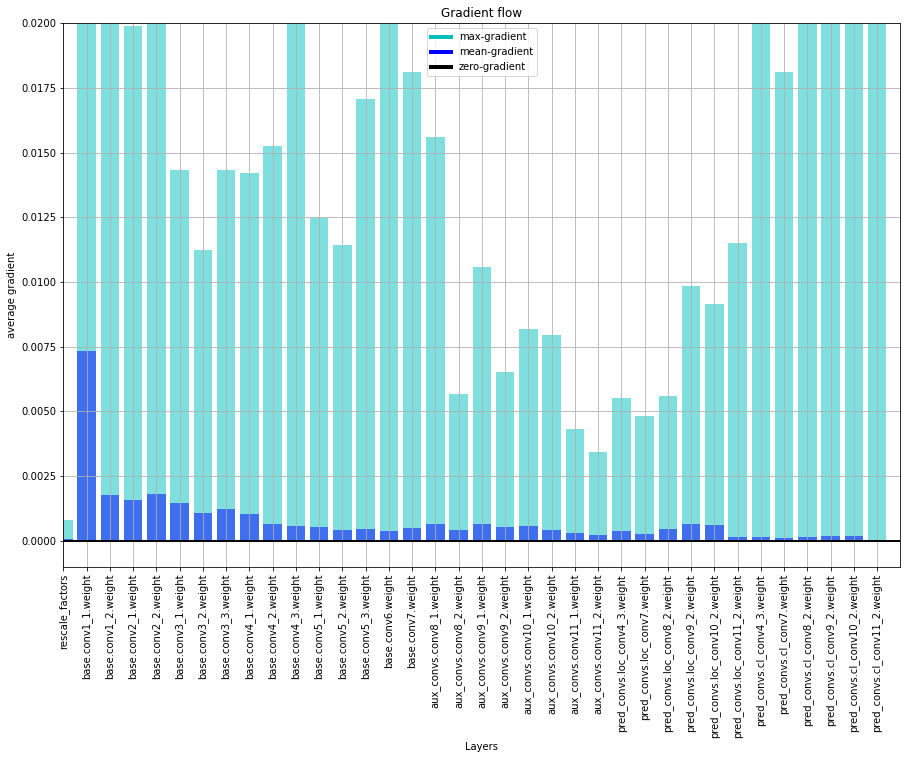

Epoch: [88][2200/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 2.9001 (3.1246)	Loss_c 2.4954 (2.7345)	Loss_l 0.4047 (0.3901)	
Epoch: [88][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0145 (3.1245)	Loss_c 2.6541 (2.7342)	Loss_l 0.3604 (0.3903)	
Epoch: [88][2600/3697]	Batch Time 0.423 (0.423)	Data Time 0.000 (0.001)	Loss 2.9786 (3.1244)	Loss_c 2.6266 (2.7343)	Loss_l 0.3519 (0.3901)	
Epoch: [88][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2923 (3.1250)	Loss_c 2.8622 (2.7351)	Loss_l 0.4301 (0.3899)	
Epoch: [88][3000/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.001)	Loss 3.2064 (3.1254)	Loss_c 2.8198 (2.7354)	Loss_l 0.3865 (0.3900)	


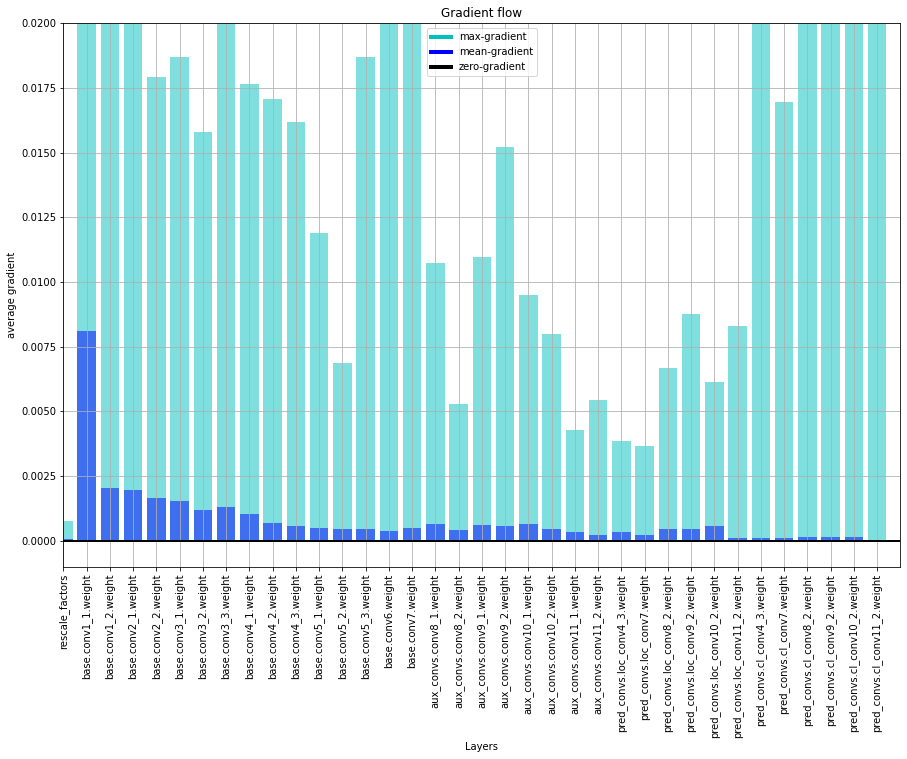

Epoch: [88][3200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2043 (3.1246)	Loss_c 2.8079 (2.7347)	Loss_l 0.3965 (0.3899)	
Epoch: [88][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.2252 (3.1242)	Loss_c 2.8435 (2.7344)	Loss_l 0.3817 (0.3899)	
Epoch: [88][3600/3697]	Batch Time 0.424 (0.423)	Data Time 0.000 (0.001)	Loss 2.7028 (3.1247)	Loss_c 2.4041 (2.7346)	Loss_l 0.2988 (0.3900)	
Epoch: [89][0/3697]	Batch Time 1.663 (1.663)	Data Time 1.239 (1.239)	Loss 3.0957 (3.0957)	Loss_c 2.7179 (2.7179)	Loss_l 0.3778 (0.3778)	


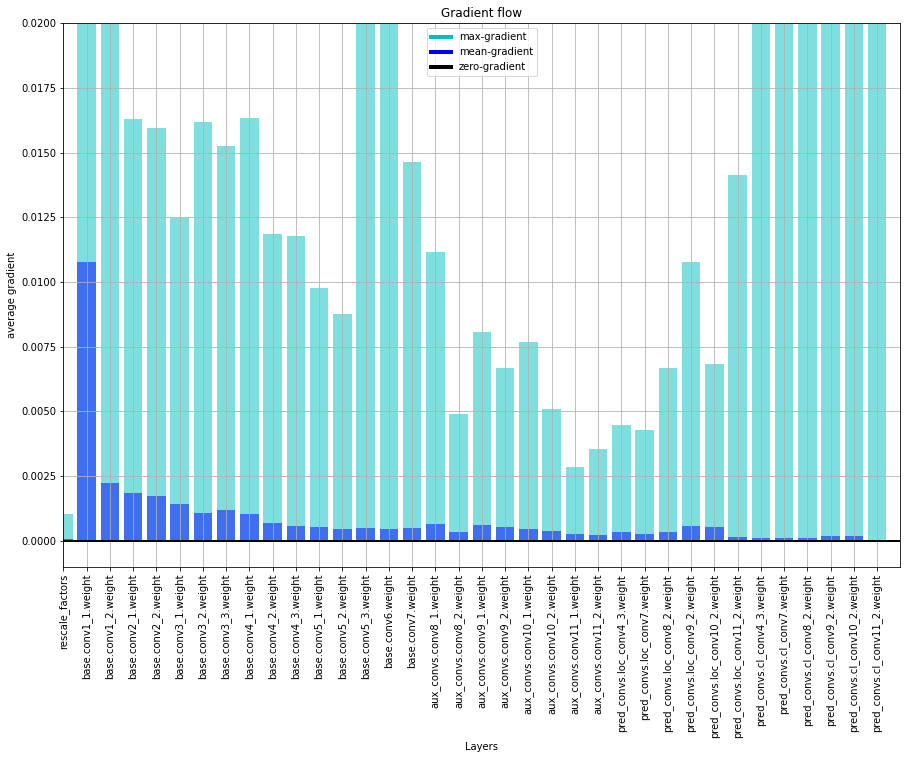

Epoch: [89][200/3697]	Batch Time 0.422 (0.431)	Data Time 0.000 (0.009)	Loss 3.1219 (3.0948)	Loss_c 2.7415 (2.7065)	Loss_l 0.3804 (0.3884)	
Epoch: [89][400/3697]	Batch Time 0.421 (0.426)	Data Time 0.000 (0.004)	Loss 3.0352 (3.1142)	Loss_c 2.6168 (2.7235)	Loss_l 0.4183 (0.3907)	
Epoch: [89][600/3697]	Batch Time 0.420 (0.425)	Data Time 0.000 (0.003)	Loss 3.5250 (3.1231)	Loss_c 3.0602 (2.7317)	Loss_l 0.4648 (0.3914)	
Epoch: [89][800/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 2.8576 (3.1242)	Loss_c 2.5796 (2.7329)	Loss_l 0.2780 (0.3913)	
Epoch: [89][1000/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.002)	Loss 3.8288 (3.1284)	Loss_c 3.1664 (2.7364)	Loss_l 0.6624 (0.3919)	


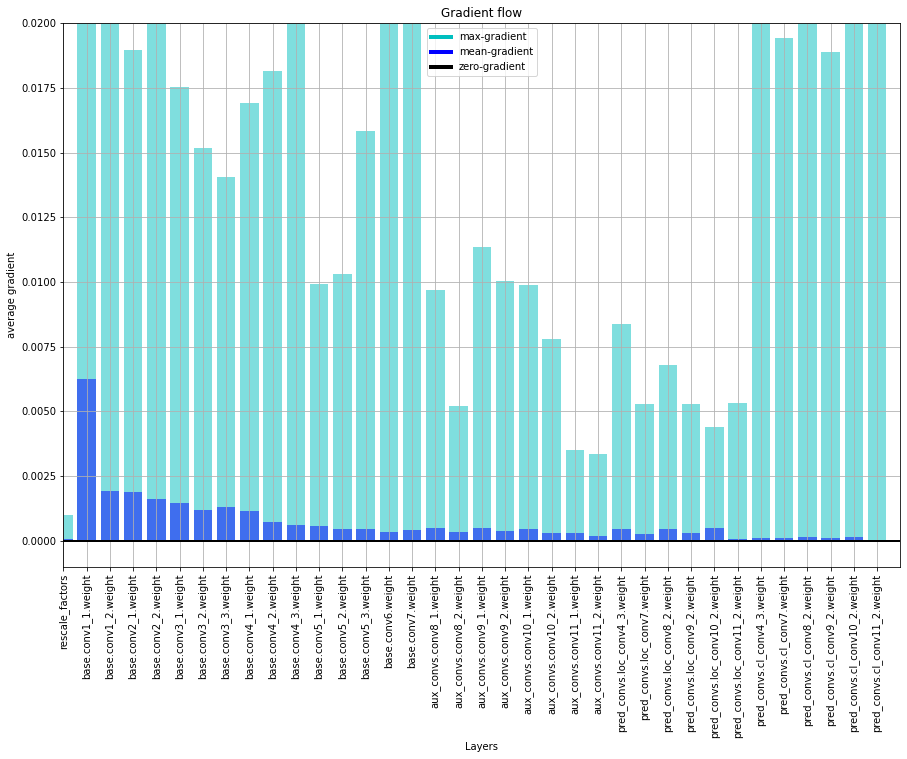

Epoch: [89][1200/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.002)	Loss 3.0541 (3.1274)	Loss_c 2.6618 (2.7358)	Loss_l 0.3924 (0.3916)	
Epoch: [89][1400/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.002)	Loss 3.0069 (3.1229)	Loss_c 2.6282 (2.7320)	Loss_l 0.3787 (0.3909)	
Epoch: [89][1600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.0260 (3.1240)	Loss_c 2.6240 (2.7330)	Loss_l 0.4019 (0.3909)	
Epoch: [89][1800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9451 (3.1218)	Loss_c 2.5821 (2.7315)	Loss_l 0.3630 (0.3903)	
Epoch: [89][2000/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 3.2727 (3.1236)	Loss_c 2.8729 (2.7331)	Loss_l 0.3998 (0.3905)	


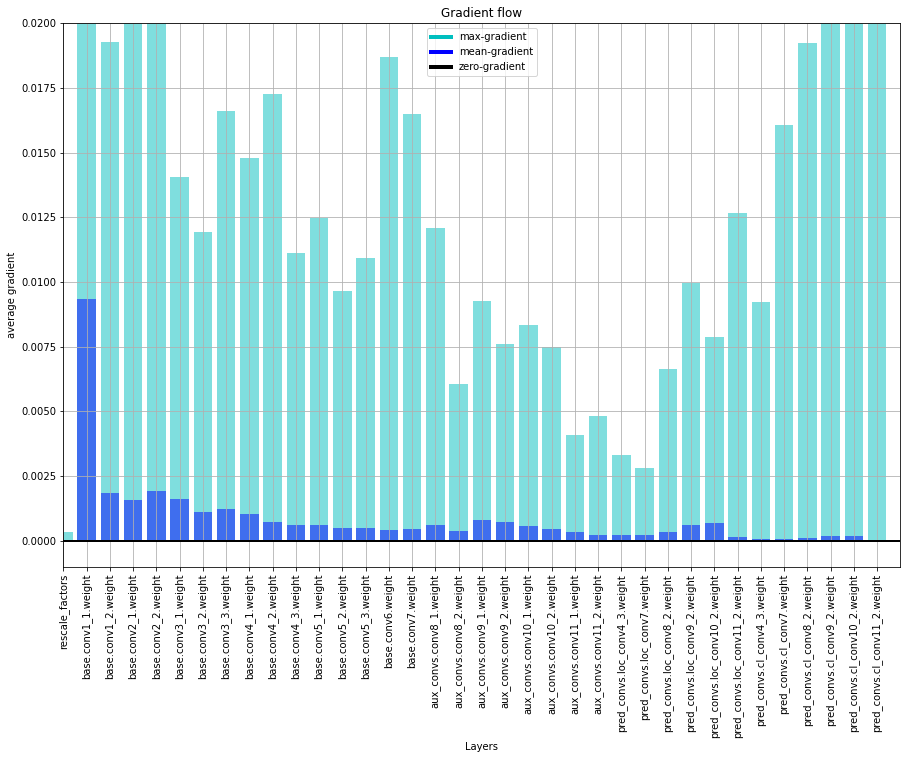

Epoch: [89][2200/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9943 (3.1251)	Loss_c 2.6388 (2.7346)	Loss_l 0.3555 (0.3904)	
Epoch: [89][2400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9383 (3.1240)	Loss_c 2.5480 (2.7338)	Loss_l 0.3903 (0.3901)	
Epoch: [89][2600/3697]	Batch Time 0.420 (0.423)	Data Time 0.000 (0.001)	Loss 3.3594 (3.1243)	Loss_c 2.9334 (2.7339)	Loss_l 0.4260 (0.3904)	
Epoch: [89][2800/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.9485 (3.1235)	Loss_c 2.6083 (2.7332)	Loss_l 0.3403 (0.3903)	
Epoch: [89][3000/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 2.8778 (3.1223)	Loss_c 2.5483 (2.7319)	Loss_l 0.3296 (0.3904)	


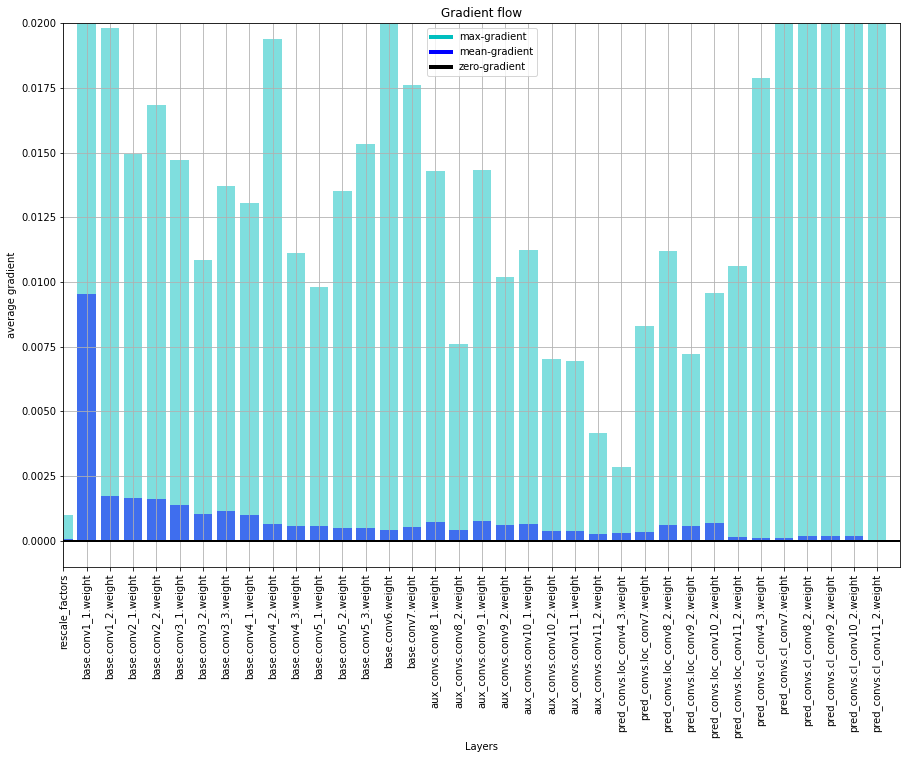

Epoch: [89][3200/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.5802 (3.1251)	Loss_c 3.0712 (2.7342)	Loss_l 0.5090 (0.3908)	
Epoch: [89][3400/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.001)	Loss 3.0737 (3.1269)	Loss_c 2.6978 (2.7356)	Loss_l 0.3759 (0.3913)	
Epoch: [89][3600/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.7732 (3.1256)	Loss_c 2.4659 (2.7344)	Loss_l 0.3074 (0.3911)	
Epoch: [90][0/3697]	Batch Time 1.866 (1.866)	Data Time 1.413 (1.413)	Loss 2.8356 (2.8356)	Loss_c 2.5052 (2.5052)	Loss_l 0.3304 (0.3304)	


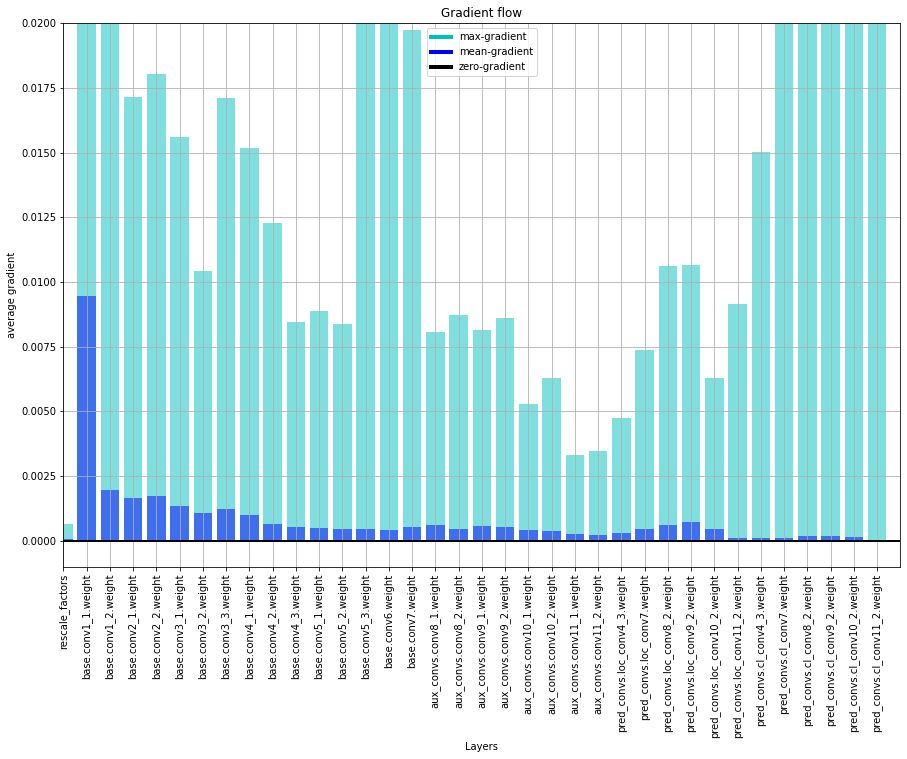

Epoch: [90][200/3697]	Batch Time 0.421 (0.432)	Data Time 0.000 (0.009)	Loss 3.3481 (3.1475)	Loss_c 2.9008 (2.7539)	Loss_l 0.4473 (0.3936)	
Epoch: [90][400/3697]	Batch Time 0.421 (0.427)	Data Time 0.000 (0.005)	Loss 3.4582 (3.1412)	Loss_c 2.9113 (2.7470)	Loss_l 0.5468 (0.3942)	
Epoch: [90][600/3697]	Batch Time 0.420 (0.425)	Data Time 0.000 (0.003)	Loss 3.9524 (3.1378)	Loss_c 3.3253 (2.7429)	Loss_l 0.6271 (0.3949)	
Epoch: [90][800/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.1771 (3.1324)	Loss_c 2.7459 (2.7389)	Loss_l 0.4312 (0.3936)	
Epoch: [90][1000/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.3030 (3.1320)	Loss_c 2.8835 (2.7388)	Loss_l 0.4195 (0.3932)	


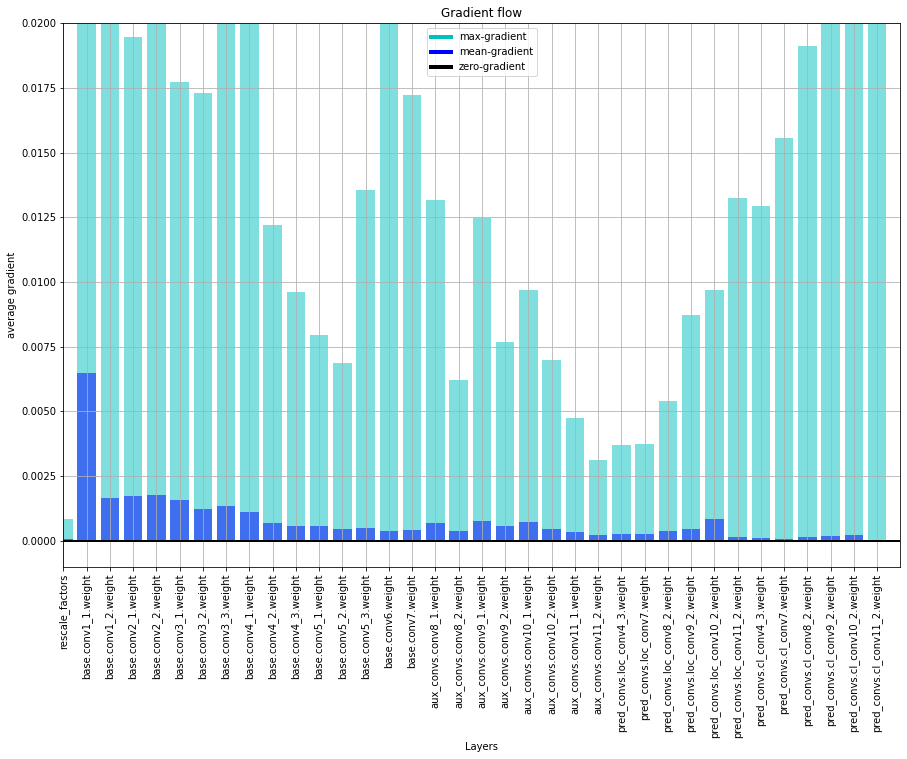

Epoch: [90][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.3585 (3.1307)	Loss_c 2.9351 (2.7387)	Loss_l 0.4234 (0.3919)	
Epoch: [90][1400/3697]	Batch Time 0.425 (0.423)	Data Time 0.000 (0.002)	Loss 3.0600 (3.1306)	Loss_c 2.6903 (2.7389)	Loss_l 0.3697 (0.3917)	
Epoch: [90][1600/3697]	Batch Time 0.421 (0.423)	Data Time 0.000 (0.002)	Loss 3.3827 (3.1324)	Loss_c 2.8002 (2.7401)	Loss_l 0.5825 (0.3923)	
Epoch: [90][1800/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 3.2300 (3.1312)	Loss_c 2.7991 (2.7391)	Loss_l 0.4309 (0.3922)	
Epoch: [90][2000/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 3.0913 (3.1308)	Loss_c 2.7065 (2.7387)	Loss_l 0.3848 (0.3921)	


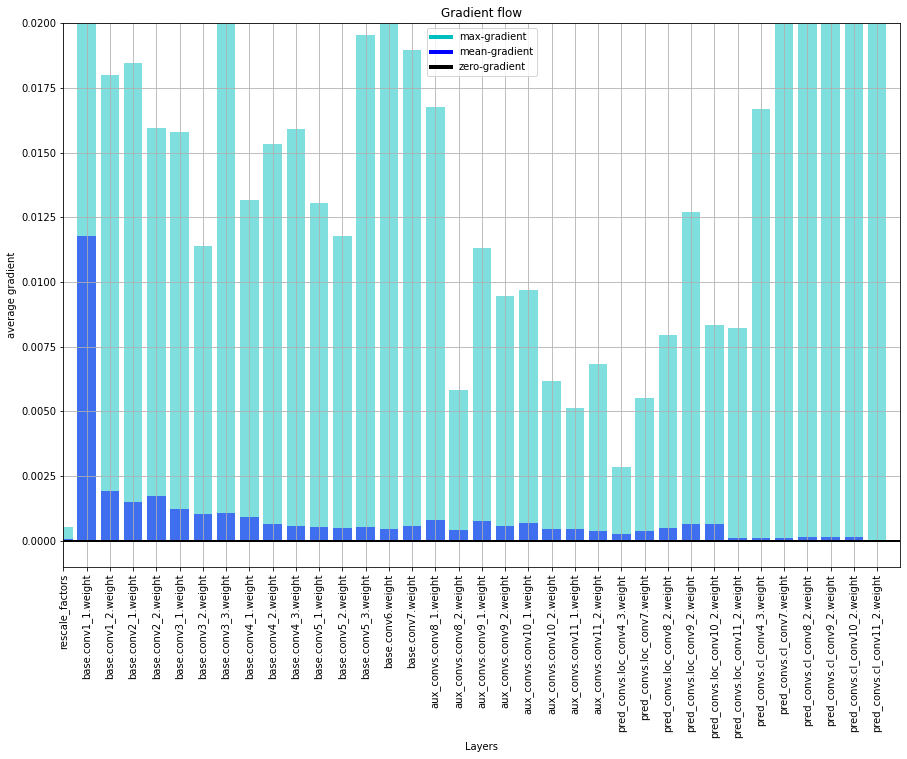

Epoch: [90][2200/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 3.6530 (3.1329)	Loss_c 3.1737 (2.7404)	Loss_l 0.4793 (0.3925)	
Epoch: [90][2400/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.001)	Loss 3.3948 (3.1328)	Loss_c 2.9518 (2.7401)	Loss_l 0.4429 (0.3927)	
Epoch: [90][2600/3697]	Batch Time 0.425 (0.424)	Data Time 0.000 (0.001)	Loss 2.9486 (3.1328)	Loss_c 2.6599 (2.7402)	Loss_l 0.2887 (0.3926)	
Epoch: [90][2800/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.001)	Loss 3.2763 (3.1330)	Loss_c 2.7883 (2.7403)	Loss_l 0.4880 (0.3927)	
Epoch: [90][3000/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.001)	Loss 3.0869 (3.1334)	Loss_c 2.6734 (2.7407)	Loss_l 0.4135 (0.3927)	


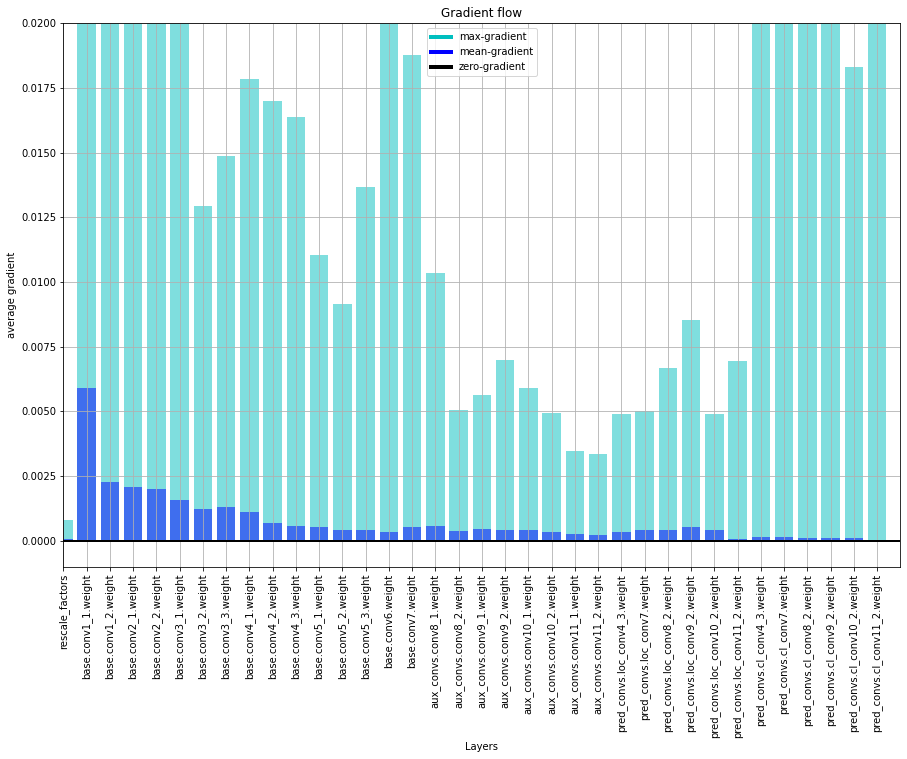

Epoch: [90][3200/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 3.2655 (3.1324)	Loss_c 2.8907 (2.7402)	Loss_l 0.3749 (0.3922)	
Epoch: [90][3400/3697]	Batch Time 0.424 (0.424)	Data Time 0.000 (0.001)	Loss 3.6292 (3.1312)	Loss_c 3.2242 (2.7392)	Loss_l 0.4050 (0.3920)	
Epoch: [90][3600/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.001)	Loss 2.9400 (3.1300)	Loss_c 2.5958 (2.7381)	Loss_l 0.3442 (0.3919)	
DECAYING learning rate.
 The new LR is 0.000002

Epoch: [91][0/3697]	Batch Time 1.924 (1.924)	Data Time 1.472 (1.472)	Loss 3.3168 (3.3168)	Loss_c 2.8979 (2.8979)	Loss_l 0.4189 (0.4189)	
Same in rescale_factors


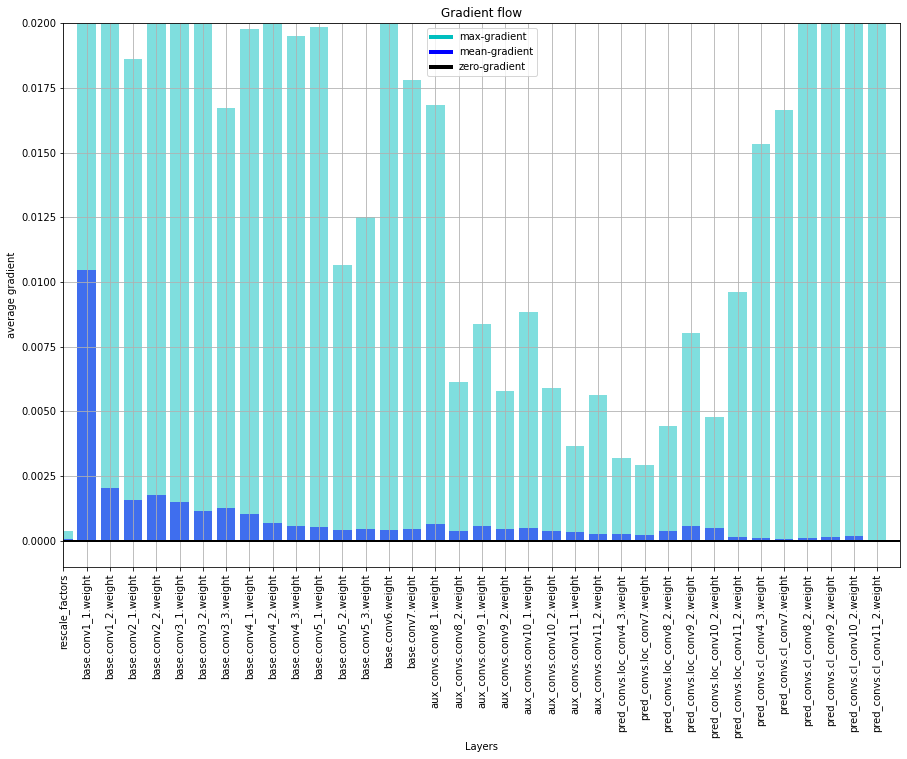

Epoch: [91][200/3697]	Batch Time 0.420 (0.433)	Data Time 0.000 (0.010)	Loss 3.6990 (3.1256)	Loss_c 3.2081 (2.7369)	Loss_l 0.4908 (0.3888)	
Epoch: [91][400/3697]	Batch Time 0.421 (0.428)	Data Time 0.000 (0.005)	Loss 3.4477 (3.1188)	Loss_c 2.9190 (2.7299)	Loss_l 0.5287 (0.3889)	
Epoch: [91][600/3697]	Batch Time 0.422 (0.426)	Data Time 0.000 (0.003)	Loss 3.1686 (3.1171)	Loss_c 2.7878 (2.7266)	Loss_l 0.3808 (0.3904)	
Epoch: [91][800/3697]	Batch Time 0.421 (0.425)	Data Time 0.000 (0.003)	Loss 3.1671 (3.1267)	Loss_c 2.6939 (2.7343)	Loss_l 0.4732 (0.3924)	
Epoch: [91][1000/3697]	Batch Time 0.422 (0.424)	Data Time 0.000 (0.002)	Loss 3.1608 (3.1277)	Loss_c 2.7879 (2.7359)	Loss_l 0.3729 (0.3918)	
Same in rescale_factors


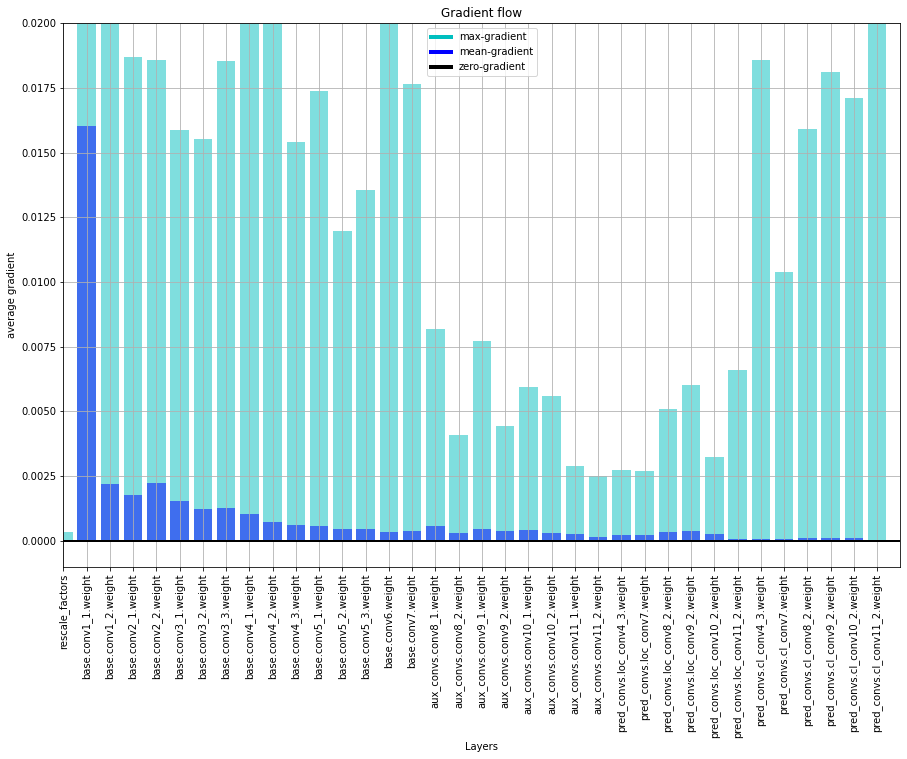

Epoch: [91][1200/3697]	Batch Time 0.421 (0.424)	Data Time 0.000 (0.002)	Loss 3.2710 (3.1270)	Loss_c 2.8443 (2.7354)	Loss_l 0.4267 (0.3916)	
Epoch: [91][1400/3697]	Batch Time 0.423 (0.424)	Data Time 0.000 (0.002)	Loss 2.9276 (3.1241)	Loss_c 2.5888 (2.7328)	Loss_l 0.3388 (0.3913)	
Epoch: [91][1600/3697]	Batch Time 0.420 (0.424)	Data Time 0.000 (0.002)	Loss 3.4153 (3.1215)	Loss_c 2.9455 (2.7312)	Loss_l 0.4698 (0.3903)	
Epoch: [91][1800/3697]	Batch Time 0.422 (0.423)	Data Time 0.000 (0.001)	Loss 2.9403 (3.1242)	Loss_c 2.6038 (2.7334)	Loss_l 0.3366 (0.3908)	
Epoch: [91][2000/3697]	Batch Time 0.443 (0.424)	Data Time 0.000 (0.001)	Loss 3.1336 (3.1249)	Loss_c 2.7195 (2.7342)	Loss_l 0.4142 (0.3908)	
Same in rescale_factors


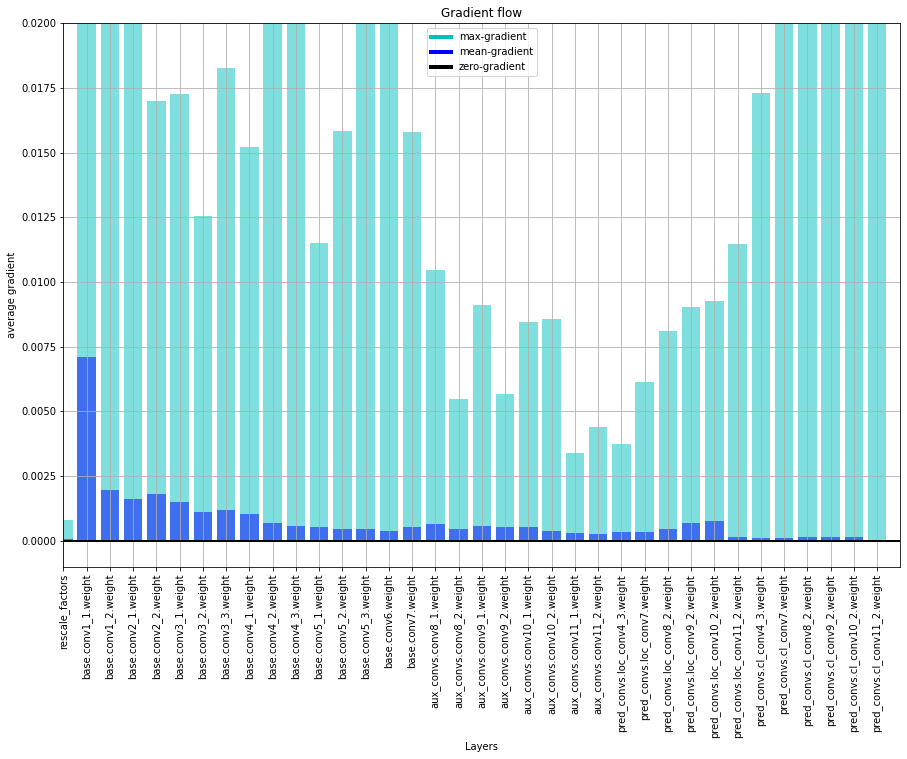

KeyboardInterrupt: 

In [8]:
if checkpoint is None:
    start_epoch = 0
    model = SSD300(n_classes = n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases
    biases = []
    not_biases = []
    for param_name, param in model.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params = [{'params': biases, 'lr': 2 * lr}, {'params': not_biases}], lr = lr, momentum = momentum, weight_decay = weight_decay)
    #optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoing from epoch %d.\n' % start_epoch)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    adjust_learning_rate(optimizer, 1.0)
    '''checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
    model = checkpoint['model']
    biases = []
    not_biases = []
    optimizer = checkpoint['optimizer']
    adjust_learning_rate(optimizer, 0.2)'''

model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy = model.priors_cxcy).to(device)

# Dataloaders
train_dataset = CocoDetectionForSSD(root=path2data, annFile=path2json, transform=None, target_transform=None, split='TRAIN')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn_SSD, num_workers = workers, pin_memory = True)

epochs = iterations // (len(train_dataset) // 32)
lr_decay_point = [it // (len(train_dataset) // 32) for it in lr_decay_point]

for epoch in range(start_epoch, epochs):
    if epoch in lr_decay_point:
        adjust_learning_rate(optimizer, lr_decay_ratio)
    save_checkpoint(epoch, model, optimizer)
    train(train_loader = train_loader, model = model, criterion = criterion, optimizer = optimizer, epoch = epoch)